# 1. Introduction
The pipeline performs systematic DiD with increasing complexity


Needs this files to be uploaded:


*   6 consilde Flash datasets
*   comp_socio_df



In [19]:
import pandas as pd
import requests
from pathlib import Path
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import os

from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import warnings
import re
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick

from matplotlib.colors import LogNorm

## 1.1 Define pipeline variables

In [20]:
# All major variable sets

pre_start = pd.Timestamp("2023-04-01 00:00:00") # Same time periods for both; missing Months 2 and 3
pre_end   = pd.Timestamp("2023-12-23 23:59:59")

post_start = pd.Timestamp("2024-04-01 00:00:00")
post_end   = pd.Timestamp("2024-12-23 23:59:59")

# Temperature
start_date = "2023-04-01"
end_date = "2024-12-23"

# Hours
hour_start = 16
hour_end = 19

out_peak_start = 9
out_peak_end = 23

out_mid_peak_start = 10
out_mid_peak_end = 20

# Socioeconomic and cluster information
comp_socio_file = "comp_socio_df_02.csv"
# comp_socio_file = "comp_socio_df.csv"


# 2. Load Data

## 2.1 Temperature


In [21]:
def fetch_hourly_temperature(start_date, end_date, latitude=51.5074, longitude=-0.1278):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m",
        "timezone": "Europe/London"
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    df = pd.DataFrame({
        "time": pd.to_datetime(data['hourly']['time']),
        "temperature": data['hourly']['temperature_2m']
    })
    return df

# Fetch temperature data
df_temp = fetch_hourly_temperature(start_date, end_date)
df_weather = df_temp

# Extract date and hour
df_weather['Hour'] = df_weather['time'].dt.hour
df_weather['Date'] = df_weather['time'].dt.date


# 1. Filter to 4–7pm only
df_temp_peak = df_weather[df_weather['Hour'].between(hour_start, hour_end)].copy()

# 2. Daily average temperature for peak hours
df_temp_daily = df_temp_peak.groupby('Date')['temperature'].mean().reset_index()
df_temp_daily.columns = ['Date', 'Temp_avg']

# 3. Daily average temperature over all hours
df_daily_all = df_weather.groupby('Date')['temperature'].mean().reset_index()
df_daily_all.columns = ['Date', 'Daily_Temp']

# 4. Merge both on Date
df_temp_daily = df_temp_daily.merge(df_daily_all, on='Date')

# Preview
print(df_temp_daily.head())


         Date  Temp_avg  Daily_Temp
0  2023-04-01    11.050    9.708333
1  2023-04-02    10.500    7.962500
2  2023-04-03     9.250    5.579167
3  2023-04-04    11.875    5.745833
4  2023-04-05    10.550    6.591667


## 2.2 Electricity

In [22]:
import pandas as pd
import os
from pathlib import Path
from functools import reduce

DATA_DIR = Path(r"C:\Users\gerva\OneDrive\Documentos\GitHub\ST498_CAPSTONE\FLASH\toShare")
fin_DIR = Path("/Users/finbarrhodes/Documents/GitHub/ST498_CAPSTONE/FLASH/toShare")
none_dir = Path("")

dire = none_dir

# =============================================
# PART 1: WEEKDAY ANALYSIS (Monday-Friday)
# =============================================

print("=" * 60)
print("PART 1: CREATING WEEKDAY ANALYSIS (Monday-Friday)")
print("=" * 60)

# ----------------------------- #
#  (1)  Helpers
# ----------------------------- #
def load_half_hour_csv(fname: str) -> pd.DataFrame:
    """Read wide half‑hour file → long panel with datetime."""
    df = (pd.read_csv(dire / fname)
            .rename(columns={'Unnamed: 0': 'Time'}))
    df['Time'] = pd.to_datetime(df['Time'])
    return df.melt(id_vars='Time',
                   var_name='ANON_ID',
                   value_name='ELEC_KWH')

def tag_window(df, start, end, treat, post_flag):
    """Restrict to [start,end] & add treatment/post dummies."""
    mask = (df['Time'].between(start, end))
    out  = df.loc[mask].copy()
    out['Treatment'] = treat
    out['Post']      = post_flag
    return out

# ----------------------------- #
#  (2)  Load   PRE  (Feb‑23 → Jan‑24) - WEEKDAYS ONLY
# ----------------------------- #
pre_rng   = (pre_start, pre_end)
df_pre_ctl = tag_window(load_half_hour_csv("controlePreConsolide.csv"),
                        *pre_rng, treat=0, post_flag=0)
df_pre_trt = tag_window(load_half_hour_csv("interventionPreConsolide.csv"),
                        *pre_rng, treat=1, post_flag=0)
df_pre = pd.concat([df_pre_ctl, df_pre_trt], ignore_index=True)

# Filter PRE data to Monday-Friday only (weekday 0-4)
df_pre = df_pre[df_pre['Time'].dt.weekday.between(0, 4)].copy()
print(f"Pre weekday data shape: {df_pre.shape}")

# ----------------------------- #
#  (3)  Load   POST  (Apr‑24 → Dec‑24) - Already weekdays only
# ----------------------------- #
post_rng  = (post_start, post_end)
df_post_ctl = tag_window(load_half_hour_csv("controleConsolide.csv"),
                         *post_rng, treat=0, post_flag=1)
df_post_trt = tag_window(load_half_hour_csv("interventionConsolide.csv"),
                         *post_rng, treat=1, post_flag=1)
df_post = pd.concat([df_post_ctl, df_post_trt], ignore_index=True)
print(f"Post data shape: {df_post.shape}")

# ----------------------------- #
#  (4)  Keep only HHs present in **both** periods (WEEKDAY ANALYSIS)
# ----------------------------- #
common_ids_weekday = set(df_pre['ANON_ID']).intersection(df_post['ANON_ID'])
df_all_weekday = pd.concat([df_pre, df_post], ignore_index=True)
df_all_weekday = df_all_weekday[df_all_weekday['ANON_ID'].isin(common_ids_weekday)].reset_index(drop=True)

print(f"Combined weekday data shape: {df_all_weekday.shape}")
print(f"Common households (weekday): {len(common_ids_weekday)}")

# Verify we only have weekdays
weekday_check = df_all_weekday['Time'].dt.weekday.value_counts().sort_index()
print(f"Weekday distribution:\n{weekday_check}")

# ----------------------------- #
#  (5)  Create Weekday Peak Analysis
# ----------------------------- #
df_all_weekday['Date'] = df_all_weekday['Time'].dt.date
df_all_weekday['Hour'] = df_all_weekday['Time'].dt.hour

# Keep peak hours (e.g., 4–7pm)
df_peak_all_weekday = df_all_weekday[df_all_weekday['Hour'].between(hour_start, hour_end)].copy()

# Group by Date & ANON_ID
df_peak_agg_weekday = (
    df_peak_all_weekday.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(peak_kwh=('ELEC_KWH', 'mean'))
)


# Filter hours 0–16 and 19–23
df_0_16 = df_all_weekday[df_all_weekday['Hour'].between(out_peak_start, hour_start)]
df_19_23 = df_all_weekday[df_all_weekday['Hour'].between(hour_end, out_peak_end)]

df_off_peak = pd.concat([df_0_16, df_19_23], axis=0)

df_outside_peak_agg_weekday = (
    df_off_peak.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(out_peak=('ELEC_KWH', 'mean'))
)

# Filter hours 0–16 and 19–23
df_12_16 = df_all_weekday[df_all_weekday['Hour'].between(out_mid_peak_start, hour_start)]
df_19_23 = df_all_weekday[df_all_weekday['Hour'].between(hour_end, out_mid_peak_end)]
df_daily_peak = pd.concat([df_12_16, df_19_23], axis=0)
df_out_mid_peak_agg_weekday = (
    df_daily_peak.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(out_mid_peak=('ELEC_KWH', 'mean'))
)



dfs_to_merge_preak = [df_peak_agg_weekday, df_outside_peak_agg_weekday,df_out_mid_peak_agg_weekday]

# Merge with temperature
df_peak_merged = reduce(lambda left, right: pd.merge(left, right, on=['Date', 'ANON_ID', 'Treatment', 'Post'], how='outer'), dfs_to_merge_preak)
df_peak_merged = pd.merge(df_peak_merged, df_temp_daily, on='Date', how='left')
df_peak_merged['Month'] = pd.to_datetime(df_peak_merged['Date']).dt.month
df_peak_merged['Year'] = pd.to_datetime(df_peak_merged['Date']).dt.year

print(f"Original df_peak_merged shape: {df_peak_merged.shape}")

# Clean and finalize weekday dataset
df_peak_merged_masked = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_avg', 'ANON_ID'])
print(f"Final df_peak_merged_masked shape: {df_peak_merged_masked.shape}")
print(f"✓ WEEKDAY ANALYSIS COMPLETE - df_peak_merged_masked ready")

# =============================================
# PART 2: SUNDAY ANALYSIS (Independent)
# =============================================

print("\n" + "=" * 60)
print("PART 2: CREATING SUNDAY ANALYSIS (Independent)")
print("=" * 60)

# ----------------------------- #
#  (6)  Sunday Helper Functions
# ----------------------------- #
def read_pre_sunday_windows(file_name, start_date, end_date):
    """Reads a 'Pre' file (Mon–Sun), keeps only Sunday & calculates multiple time windows."""
    df = pd.read_csv(dire / file_name)
    df = df.rename(columns={'Unnamed: 0': 'Time'})
    df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")
    print(f"[INFO] Pre Sunday file: {file_name} => min={df['Time'].min()}, max={df['Time'].max()}")

    # Filter by date range and Sunday only
    df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]
    df = df[df['Time'].dt.weekday == 6]  # Sunday => weekday==6

    # Melt to long format
    df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
    df_long.drop_duplicates(subset=['Time','ANON_ID'], inplace=True)

    # Calculate multiple time windows
    windows = {
        'sunday8_12': (8, 12),   # 8am-12pm
        'sunday8_16': (8, 16),   # 8am-4pm
        'sunday8_20': (8, 20),   # 8am-8pm
        'sunday8_24': (8, 24)    # 8am-12am
    }

    results = []
    for window_name, (start_hour, end_hour) in windows.items():
        # Filter to time window
        df_window = df_long[
            (df_long['Time'].dt.hour >= start_hour) &
            (df_long['Time'].dt.hour < end_hour)
        ].copy()

        # Calculate average per ANON_ID
        df_agg = df_window.groupby('ANON_ID', as_index=False)['ELEC_KWH'].mean()
        df_agg = df_agg.rename(columns={'ELEC_KWH': window_name})
        results.append(df_agg)

    # Merge all windows
    df_final = results[0]
    for df_window in results[1:]:
        df_final = pd.merge(df_final, df_window, on='ANON_ID', how='outer')

    return df_final

def read_post_sunday_windows(file_name, start_date, end_date):
    """Reads a 'Post' Sunday file (already Sunday-only), calculates multiple time windows."""
    df = pd.read_csv(dire / file_name)
    df = df.rename(columns={'Unnamed: 0': 'Time'})
    df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d %H:%M:%S")
    print(f"[INFO] Post Sunday file: {file_name} => min={df['Time'].min()}, max={df['Time'].max()}")

    # Filter by date range
    df = df[(df['Time'] >= start_date) & (df['Time'] <= end_date)]

    # Melt to long format
    df_long = df.melt(id_vars=['Time'], var_name='ANON_ID', value_name='ELEC_KWH')
    df_long.drop_duplicates(subset=['Time','ANON_ID'], inplace=True)

    # Calculate multiple time windows
    windows = {
        'sunday8_12': (8, 12),   # 8am-12pm
        'sunday8_16': (8, 16),   # 8am-4pm
        'sunday8_20': (8, 20),   # 8am-8pm
        'sunday8_24': (8, 24)    # 8am-12am
    }

    results = []
    for window_name, (start_hour, end_hour) in windows.items():
        # Filter to time window
        df_window = df_long[
            (df_long['Time'].dt.hour >= start_hour) &
            (df_long['Time'].dt.hour < end_hour)
        ].copy()

        # Calculate average per ANON_ID
        df_agg = df_window.groupby('ANON_ID', as_index=False)['ELEC_KWH'].mean()
        df_agg = df_agg.rename(columns={'ELEC_KWH': window_name})
        results.append(df_agg)

    # Merge all windows
    df_final = results[0]
    for df_window in results[1:]:
        df_final = pd.merge(df_final, df_window, on='ANON_ID', how='outer')

    return df_final



# ----------------------------- #
#  (7)  Create Independent Sunday Dataset for Daily Analysis
# ----------------------------- #

# Load PRE period data (all days) and filter to Sundays for daily analysis
df_pre_sunday_daily_ctl = tag_window(load_half_hour_csv("controlePreConsolide.csv"),
                                    *pre_rng, treat=0, post_flag=0)
df_pre_sunday_daily_trt = tag_window(load_half_hour_csv("interventionPreConsolide.csv"),
                                    *pre_rng, treat=1, post_flag=0)
df_pre_sunday_daily = pd.concat([df_pre_sunday_daily_ctl, df_pre_sunday_daily_trt], ignore_index=True)

# Filter to Sundays only
df_pre_sunday_daily = df_pre_sunday_daily[df_pre_sunday_daily['Time'].dt.weekday == 6].copy()

# Load POST period Sunday data (already Sunday-only)
df_post_sunday_daily_ctl = tag_window(load_half_hour_csv("controleConsolideSunday.csv"),
                                     *post_rng, treat=0, post_flag=1)
df_post_sunday_daily_trt = tag_window(load_half_hour_csv("interventionConsolideSunday.csv"),
                                     *post_rng, treat=1, post_flag=1)
df_post_sunday_daily = pd.concat([df_post_sunday_daily_ctl, df_post_sunday_daily_trt], ignore_index=True)

# Combine all Sunday daily data
df_all_sunday_daily = pd.concat([df_pre_sunday_daily, df_post_sunday_daily], ignore_index=True)

# Find common IDs for Sunday analysis (independent from weekday analysis)
common_ids_sunday = set(df_pre_sunday_daily['ANON_ID']).intersection(df_post_sunday_daily['ANON_ID'])
df_all_sunday_daily = df_all_sunday_daily[df_all_sunday_daily['ANON_ID'].isin(common_ids_sunday)].reset_index(drop=True)
df_all_sunday_daily_true = df_all_sunday_daily.copy()

print(f"Sunday daily data shape: {df_all_sunday_daily.shape}")
print(f"Common households (Sunday): {len(common_ids_sunday)}")

# Ensure datetime components are available
df_all_sunday_daily_true['Date'] = df_all_sunday_daily_true['Time'].dt.date
df_all_sunday_daily_true['Hour'] = df_all_sunday_daily_true['Time'].dt.hour

# --- 1. Create sunday8_12 ---
df_sunday8_12 = df_all_sunday_daily_true[df_all_sunday_daily_true['Hour'].between(8, 11)]
df_agg_8_12 = (
    df_sunday8_12.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(sunday8_12=('ELEC_KWH', 'mean'))
)

# --- 2. Create sunday8_16 ---
df_sunday8_16 = df_all_sunday_daily_true[df_all_sunday_daily_true['Hour'].between(8, 15)]
df_agg_8_16 = (
    df_sunday8_16.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(sunday8_16=('ELEC_KWH', 'mean'))
)

# --- 3. Create sunday8_20 ---
df_sunday8_20 = df_all_sunday_daily_true[df_all_sunday_daily_true['Hour'].between(8, 19)]
df_agg_8_20 = (
    df_sunday8_20.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(sunday8_20=('ELEC_KWH', 'mean'))
)

# --- 4. Create sunday8_24 ---
df_sunday8_24 = df_all_sunday_daily_true[df_all_sunday_daily_true['Hour'].between(8, 23)]
df_agg_8_24 = (
    df_sunday8_24.groupby(['Date', 'ANON_ID', 'Treatment', 'Post'], as_index=False)
    .agg(sunday8_24=('ELEC_KWH', 'mean'))
)

# --- 5. Merge all into one DataFrame ---
from functools import reduce

dfs_to_merge = [df_agg_8_12, df_agg_8_16, df_agg_8_20, df_agg_8_24]
df_merged_all = reduce(lambda left, right: pd.merge(left, right, on=['Date', 'ANON_ID', 'Treatment', 'Post'], how='outer'), dfs_to_merge)

# Final DataFrame:
df_merged_all.head()

# ----------------------------- #
#  (9)  Create Final Sunday Dataset
# ----------------------------- #

# Merge Sunday daily data with temperature
df_peak_merged_sunday = pd.merge(df_merged_all, df_temp_daily, on='Date', how='left')
df_peak_merged_sunday['Month'] = pd.to_datetime(df_peak_merged_sunday['Date']).dt.month
df_peak_merged_sunday['Year'] = pd.to_datetime(df_peak_merged_sunday['Date']).dt.year

# Clean Sunday dataset
df_peak_merged_sunday_clean = df_peak_merged_sunday.dropna(subset=['Temp_avg', 'ANON_ID'])

df_peak_merged_masked_sunday = df_peak_merged_sunday_clean

# Final column selection for Sunday dataset
desired_columns = ['Date', 'ANON_ID', 'Treatment', 'Post', 'sunday8_12', 'sunday8_16',
                  'sunday8_20', 'sunday8_24', 'Temp_avg', 'Daily_Temp', 'Month', 'Year']

existing_cols = df_peak_merged_masked_sunday.columns.tolist()
final_columns = [col for col in desired_columns if col in existing_cols]
df_peak_merged_masked_sunday = df_peak_merged_masked_sunday[final_columns]
df_peak_merged_masked_sunday


# =============================================
# FINAL SUMMARY
# =============================================

print("\n" + "=" * 60)
print("PIPELINE COMPLETE - FINAL SUMMARY")
print("=" * 60)

print(f"\n📊 WEEKDAY DATASET (df_peak_merged_masked):")
print(f"   Shape: {df_peak_merged_masked.shape}")
print(f"   Households: {df_peak_merged_masked['ANON_ID'].nunique()}")
print(f"   Columns: {list(df_peak_merged_masked.columns)}")
print(f"   Date range: {df_peak_merged_masked['Date'].min()} to {df_peak_merged_masked['Date'].max()}")

print(f"\n📊 SUNDAY DATASET (df_peak_merged_masked_sunday):")
print(f"   Shape: {df_peak_merged_masked_sunday.shape}")
print(f"   Households: {df_peak_merged_masked_sunday['ANON_ID'].nunique()}")
print(f"   Columns: {list(df_peak_merged_masked_sunday.columns)}")
print(f"   Date range: {df_peak_merged_masked_sunday['Date'].min()} to {df_peak_merged_masked_sunday['Date'].max()}")

# Verify Sunday data only contains Sundays
sunday_dates = pd.to_datetime(df_peak_merged_masked_sunday['Date'])
sunday_weekdays = sunday_dates.dt.weekday.value_counts().sort_index()
print(f"   Weekday verification: {dict(sunday_weekdays)}")

print(f"\n✅ Both datasets are ready for analysis!")
print(f"   - Weekday analysis: Monday-Friday peak consumption")
print(f"   - Sunday analysis: Sunday consumption with 4 time windows")

PART 1: CREATING WEEKDAY ANALYSIS (Monday-Friday)
Pre weekday data shape: (6382157, 5)
Post data shape: (12972112, 5)
Combined weekday data shape: (14189046, 5)
Common households (weekday): 706
Weekday distribution:
Time
0    2578844
1    2559488
2    2572984
3    2568540
4    2556706
5    1352484
Name: count, dtype: int64
Original df_peak_merged shape: (294468, 11)
Final df_peak_merged_masked shape: (281928, 11)
✓ WEEKDAY ANALYSIS COMPLETE - df_peak_merged_masked ready

PART 2: CREATING SUNDAY ANALYSIS (Independent)
Sunday daily data shape: (2542212, 5)
Common households (Sunday): 702

PIPELINE COMPLETE - FINAL SUMMARY

📊 WEEKDAY DATASET (df_peak_merged_masked):
   Shape: (281928, 11)
   Households: 706
   Columns: ['Date', 'ANON_ID', 'Treatment', 'Post', 'peak_kwh', 'out_peak', 'out_mid_peak', 'Temp_avg', 'Daily_Temp', 'Month', 'Year']
   Date range: 2023-04-03 to 2024-12-23

📊 SUNDAY DATASET (df_peak_merged_masked_sunday):
   Shape: (52968, 12)
   Households: 702
   Columns: ['Date'

## 2.3 Complemented Socioeconomic Data

In [23]:
# -----------------------------
#  Load Complemented Socioeconomic data
# -----------------------------
socio_df = pd.read_csv(comp_socio_file)

# -----------------------------
#  Add to df_peak_merged_masked
# -----------------------------
print(f"\n Before dropping missing values; unique households {(df_peak_merged_masked['ANON_ID'].nunique())}")

# Keep data with socioeconomic features
common_ids_02  = set(df_peak_merged_masked['ANON_ID']).intersection(socio_df['ANON_ID'])
df_peak_merged = df_peak_merged_masked[df_peak_merged_masked['ANON_ID'].isin(common_ids_02)].reset_index(drop=True)
print(f"\n The original shape of df_peak_merged {(df_peak_merged.shape)}")


# Ensure no missing values and correct alignment
df_peak_merged_masked = df_peak_merged.dropna(subset=['peak_kwh', 'Temp_avg', 'ANON_ID'])
print(f"\n After dropping missing values; the shape of df_peak_merged {(df_peak_merged_masked.shape)}")
print(f"\n After dropping missing values; unique households {(df_peak_merged_masked['ANON_ID'].nunique())}")
df_peak_merged_masked.head()

# -----------------------------
#  Add to df_peak_merged_masked_sunday
# -----------------------------

print(f"\n Before dropping missing values; unique households {(df_peak_merged_masked_sunday['ANON_ID'].nunique())}")

# Keep data with socioeconomic features
common_ids_02_sun  = set(df_peak_merged_masked_sunday['ANON_ID']).intersection(socio_df['ANON_ID'])
df_peak_merged_sun = df_peak_merged_masked_sunday[df_peak_merged_masked_sunday['ANON_ID'].isin(common_ids_02_sun)].reset_index(drop=True)
print(f"\n The original shape of df_peak_merged {(df_peak_merged_sun.shape)}")


# Ensure no missing values and correct alignment
df_peak_merged_masked_sunday = df_peak_merged_sun.dropna(subset=['sunday8_12',	'sunday8_16',	'sunday8_20',	'sunday8_24', 'Temp_avg', 'ANON_ID'])
print(f"\n After dropping missing values; the shape of df_peak_merged {(df_peak_merged_masked_sunday.shape)}")
print(f"\n After dropping missing values; unique households {(df_peak_merged_masked_sunday['ANON_ID'].nunique())}")



 Before dropping missing values; unique households 706

 The original shape of df_peak_merged (251248, 11)

 After dropping missing values; the shape of df_peak_merged (251248, 11)

 After dropping missing values; unique households 624

 Before dropping missing values; unique households 702

 The original shape of df_peak_merged (47086, 12)

 After dropping missing values; the shape of df_peak_merged (45824, 12)

 After dropping missing values; unique households 624


## 2.4 Carbon Intensity PENDING ATM!

In [ ]:
# carbon = pd.read_csv("carbon_electricity_data_clean.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'carbon_electricity_data_clean.csv'

In [ ]:
carbon2 = pd.read_csv("carbon_full_day_clean.csv")

In [ ]:
carbon_df = carbon2
carbon_df.tail()

In [ ]:
# Your existing code
carbon_df = carbon

# First, let's see what columns we actually have
print("Original carbon_df columns:")
print(carbon_df.columns.tolist())
print("\nFirst few rows:")
print(carbon_df.head())

# Rename columns like df_peak_merged
carbon_df['Treatment'] = carbon_df['treatment'].map({'Control': 0, 'Intervention':1})
carbon_df = carbon_df.drop(columns=['treatment'])

carbon_df['Post'] = carbon_df['period'].map({'Pre': 0, 'Post':1})
carbon_df = carbon_df.drop(columns=['period'])

# Drop actual_intensity column if it exists
if 'actual_intensity' in carbon_df.columns:
    carbon_df = carbon_df.drop(columns=['actual_intensity'])

print("\nColumns after initial processing:")
print(carbon_df.columns.tolist())

# Intersect ANON_ID and check for HH count
print(f"\nThe original shape of carbon_df: {carbon_df.shape}")
common_ids_carbon_socio = set(carbon_df['ANON_ID']).intersection(df_peak_merged_masked['ANON_ID'])
carbon_df_masked = carbon_df[carbon_df['ANON_ID'].isin(common_ids_carbon_socio)].reset_index(drop=True)
print(f"After intersection with df_peak_merged_masked: {carbon_df.shape}")


unique_hh = carbon_df_masked['ANON_ID'].unique()
unique_hh_tot = len(unique_hh)
print(f"The count of households in carbon_df: {unique_hh_tot}")

# Check unique dates in carbon
unique_date = carbon_df_masked['date'].unique()
unique_date_tot = len(unique_date)
print(f"The count of Date in carbon: {unique_date_tot}")

# Check unique dates in df_peak_merged_masked
unique_date_2 = df_peak_merged_masked['Date'].unique()
unique_date_2_tot = len(unique_date_2)
print(f"The count of Date in df_peak_merged_masked: {unique_date_2_tot}")


# Check what carbon-related columns we have before renaming
carbon_related_cols = [col for col in carbon_df_masked.columns if 'carbon' in col.lower() or 'co2' in col.lower() or 'emission' in col.lower()]
print(f"\nCarbon-related columns found: {carbon_related_cols}")

# Rename columns - let's be more flexible with the carbon column name
rename_dict = {'date': 'Date'}


# Find the carbon emissions column (could be various names)
possible_carbon_names = ['carbon_emissions', 'carbon_emission', 'emissions', 'co2_emissions', 'CO2_emissions', 'g_CO2e']
carbon_col_name = None

for possible_name in possible_carbon_names:
    if possible_name in carbon_df_masked.columns:
        carbon_col_name = possible_name
        rename_dict[possible_name] = 'g_CO2e'
        break

if carbon_col_name is None:
    print("⚠️  Could not find carbon emissions column. Available columns:")
    print(carbon_df_masked.columns.tolist())
    print("Please check the exact column name in your CSV")
    # Let's try to guess from remaining columns
    remaining_cols = [col for col in carbon_df_masked.columns if col not in ['ANON_ID', 'Date', 'Treatment', 'Post']]
    print(f"Remaining columns that might be carbon data: {remaining_cols}")
    if remaining_cols:
        print(f"Assuming '{remaining_cols[0]}' is the carbon emissions column...")
        carbon_col_name = remaining_cols[0]
        rename_dict[carbon_col_name] = 'g_CO2e'

carbon_df_masked = carbon_df_masked.rename(columns=rename_dict)

print(f"\nColumns after renaming:")
print(carbon_df_masked.columns.tolist())

# Convert dates
df_peak_merged_masked['Date']      = pd.to_datetime(df_peak_merged_masked['Date'],    errors='coerce').dt.date
carbon_df_masked['Date']               = pd.to_datetime(carbon_df_masked['Date'],           errors='coerce').dt.date

# Allow only df_peak_merged_masked dates
allowed_dates = set(df_peak_merged_masked['Date'].unique())
carbon_df_masked = carbon_df_masked[carbon_df_masked['Date'].isin(allowed_dates)].copy()
print("Dates in carbon_peak after filtering:", carbon_df_masked['Date'].nunique())

# Allow only df_peak_merged_masked dates
allowed_dates_02 = set(carbon_df_masked['Date'].unique())
df_peak_merged_masked = df_peak_merged_masked[df_peak_merged_masked['Date'].isin(allowed_dates_02)].copy()
print("Dates in df_peak_merged_masked after filtering:", df_peak_merged_masked['Date'].nunique())
print("Dates in carbon_peak after filtering:", carbon_df_masked['Date'].nunique())


# ----------------------------------------------------------------------
# AGGREGATE CARBON DATA (6 ENTRIES PER DATE PER HOUSEHOLD → 1 ENTRY)
# ----------------------------------------------------------------------
print(f"\n" + "="*60)
print("AGGREGATING CARBON DATA BY DATE AND HOUSEHOLD")
print("="*60)

# Convert Date to datetime if not already
carbon_df_masked['Date'] = pd.to_datetime(carbon_df_masked['Date'])

# Check the 6 entries per date per household structure
print(f"Verifying data structure...")
sample_check = carbon_df_masked.groupby(['ANON_ID', 'Date']).size().value_counts().sort_index()
print(f"Entries per household-date combination:")
print(sample_check)

# Aggregate the 6 entries per date per household to get daily averages
print(f"\nAggregating 6 entries per date per household...")
carbon_daily = carbon_df_masked.groupby(['ANON_ID', 'Date', 'Treatment', 'Post']).agg({
    'g_CO2e': 'mean'  # Average carbon emissions across the 6 daily periods
}).reset_index()

print(f"Shape before aggregation: {carbon_df_masked.shape}")
print(f"Shape after daily aggregation: {carbon_daily.shape}")
print(f"Expected shape after aggregation: {carbon_df_masked.shape[0] // 6} (should be ~6x smaller)")

# Extract Month from Date to match df_peak_merged structure
carbon_daily['Month'] = carbon_daily['Date'].dt.month

print(f"Carbon data date range: {carbon_daily['Date'].min()} to {carbon_daily['Date'].max()}")
print(f"Carbon data months: {sorted(carbon_daily['Month'].unique())}")


# --------------------------------------------------------------------------
# CHECK ALIGNMENT WITH DF_PEAK_MERGED
# --------------------------------------------------------------------------
print(f"\n" + "="*50)
print("CHECKING ALIGNMENT WITH DF_PEAK_MERGED")
print("="*50)

# Check household overlap
peak_households = set(df_peak_merged['ANON_ID'].unique())
carbon_households = set(carbon_daily['ANON_ID'].unique())

common_households = peak_households.intersection(carbon_households)
peak_only = peak_households - carbon_households
carbon_only = carbon_households - peak_households

print(f"Households in df_peak_merged: {len(peak_households):,}")
print(f"Households in carbon_daily: {len(carbon_households):,}")
print(f"Common households: {len(common_households):,}")
print(f"Only in peak data: {len(peak_only):,}")
print(f"Only in carbon data: {len(carbon_only):,}")

# Check month overlap
peak_months = set(df_peak_merged['Month'].astype(int).unique())
carbon_months = set(carbon_daily['Month'].unique())

print(f"\nMonths in df_peak_merged: {sorted(peak_months)}")
print(f"Months in carbon_daily: {sorted(carbon_months)}")
print(f"Common months: {sorted(peak_months.intersection(carbon_months))}")





In [ ]:
# ─── 1. Ensure Date is datetime64 on both sides ───────────────────────────────
df_peak_merged['Date']   = pd.to_datetime(df_peak_merged['Date'],   errors='coerce')
carbon_daily['Date']     = pd.to_datetime(carbon_daily['Date'],     errors='coerce')

# ─── 2. Normalize the time component (zero it out) ────────────────────────────
df_peak_merged['Date']   = df_peak_merged['Date'].dt.normalize()
carbon_daily['Date']     = carbon_daily['Date'].dt.normalize()

# ─── 3. Align the other key dtypes ─────────────────────────────────────────────
df_peak_merged['ANON_ID']   = df_peak_merged['ANON_ID'].astype(str).str.strip()
carbon_daily['ANON_ID']     = carbon_daily['ANON_ID'].astype(str).str.strip()

for col in ['Treatment','Post']:
    df_peak_merged[col] = df_peak_merged[col].astype(int)
    carbon_daily[col]   = carbon_daily[col].astype(int)

# ─── 4. (Optional) Drop any accidental duplicates in carbon_daily ──────────────
carbon_daily_unique = carbon_daily.drop_duplicates(
    subset=['Date','ANON_ID','Treatment','Post']
)

# ─── 5. Merge ─────────────────────────────────────────────────────────────────
df_final = df_peak_merged.merge(
    carbon_daily_unique[['Date','ANON_ID','Treatment','Post','g_CO2e']],
    on=['Date','ANON_ID','Treatment','Post'],
    how='left'
)

print("df_final shape:", df_final.shape)
print("Missing g_CO2e values:", df_final['g_CO2e'].isna().sum())


# IMPORTANT ----------
# THIS WAS AN EASY FIX TO REMOVE Obs
# Option 1: create a new DataFrame without missing g_CO2e
df_final_clean = df_final.dropna(subset=['g_CO2e']).reset_index(drop=True)

print("df_final shape:", df_final_clean.shape)
print("Missing g_CO2e values:", df_final_clean['g_CO2e'].isna().sum())



In [ ]:

# 1️⃣ Overall descriptive statistics and missingness
numeric = df_final.select_dtypes(include=[np.number])
print("— Overall descriptive statistics:")
print(numeric.describe().T)

missing = df_final.isna().sum().to_frame('missing')
missing['missing_pct'] = missing['missing'] / len(df_final) * 100
print("\n— Missing values by column:")
print(missing)

# 2️⃣ Grouped summaries by Treatment and Post
group = df_final.groupby(['Treatment', 'Post']).agg({
    'g_CO2e':       ['count', 'mean', 'std', 'median'],
    'peak_kwh':     ['mean',  'std',  'median'],
    'Temp_avg':['mean', 'std', 'median']
})
# flatten MultiIndex
group.columns = ['_'.join(col) for col in group.columns]
print("\n— Summary by Treatment & Post:")
print(group)

# 3️⃣ Distribution plots
plt.figure()
numeric['g_CO2e'].hist(bins=50)
plt.title("Histogram of g_CO2e")
plt.xlabel("g_CO2e")
plt.ylabel("Frequency")
plt.show()

plt.figure()
numeric['peak_kwh'].hist(bins=50)
plt.title("Histogram of peak_kwh")
plt.xlabel("peak_kwh")
plt.ylabel("Frequency")
plt.show()

# 4️⃣ Relationship of consumption vs emissions
plt.figure()
plt.scatter(df_final['peak_kwh'], df_final['g_CO2e'], alpha=0.3)
plt.title("peak_kwh vs g_CO2e")
plt.xlabel("peak_kwh")
plt.ylabel("g_CO2e")
plt.show()

# 5️⃣ Missingness pattern by group
missing_by_group = (
    df_final
      .assign(missing_CO2 = df_final['g_CO2e'].isna().astype(int))
      .groupby(['Treatment','Post'])['missing_CO2']
      .mean()
      .to_frame('prop_missing_CO2')
)
print("\n— Proportion of missing g_CO2e by Treatment & Post:")
print(missing_by_group)


# 3.Complete Difference in Difference Pipeline

## 3.1 Define Progressive Pipeline



In [24]:
class SimpleDiDRobustnessPipeline:
    """
    Enhanced step-by-step robustness pipeline for DiD analysis with:
    - Progressive model complexity (Steps 1-6)
    - Full monthly heterogeneity analysis (Step 8)
    - Sup-t uniform confidence bands for multiple testing
    - Enhanced diagnostic plots (hexbin, binned residuals)
    - Optional socio×post controls for different study designs
    """

    def __init__(self, data: pd.DataFrame, outcome_var: str = 'peak_kwh',
                 treatment_var: str = 'Treatment', post_var: str = 'Post',
                 month_var: str = 'Month', cluster_var: str = 'ANON_ID',
                 temp_var: str = 'Temp_avg'):

        self.data = data.copy()
        self.outcome_var = outcome_var
        self.treatment_var = treatment_var
        self.post_var = post_var
        self.month_var = month_var
        self.cluster_var = cluster_var
        self.temp_var = temp_var
        self.results = {}

        # Ensure proper data types
        self.data[cluster_var] = self.data[cluster_var].astype(str)
        self.data[month_var] = self.data[month_var].astype(str)
        self.data[treatment_var] = self.data[treatment_var].astype(int)
        self.data[post_var] = self.data[post_var].astype(int)

        print(f"Data shape: {self.data.shape}")
        print(f"Months available: {sorted(self.data[month_var].unique())}")

    def _run_model(self, formula: str, model_name: str, description: str = ""):
        """Run a single model and store results"""
        try:
            print(f"\nRunning: {model_name}")
            if description:
                print(f"Description: {description}")
            print(f"Formula: {formula}")

            # Run regression with clustered standard errors
            model = smf.ols(formula=formula, data=self.data).fit(
                cov_type='cluster',
                cov_kwds={'groups': self.data[self.cluster_var]}
            )

            # Store results
            self.results[model_name] = {
                'model': model,
                'formula': formula,
                'description': description,
                'n_obs': int(model.nobs),
                'r_squared': model.rsquared,
                'aic': model.aic,
                'bic': model.bic
            }

            print(f"✓ Success: N={model.nobs}, R²={model.rsquared:.4f}")

            # Print full model summary
            print("\nFULL MODEL SUMMARY:")
            print("="*80)
            print(model.summary())
            print("="*80)

            return model

        except Exception as e:
            print(f"✗ Error in {model_name}: {e}")
            return None

    def step1_basic_did(self):
        """Step 1: Basic DiD (entire period as single treatment)"""
        print("="*60)
        print("STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES")
        print("="*60)

        # Simple DiD: outcome ~ treatment + post + treatment*post + temperature
        formula = f"{self.outcome_var} ~ {self.treatment_var} + {self.post_var} + {self.temp_var} + {self.treatment_var}:{self.post_var}"

        model = self._run_model(
            formula=formula,
            model_name="basic_did",
            description="Basic DiD treating entire post period as single treatment"
        )

        if model:
            # Extract DiD coefficient
            did_coef = model.params[f'{self.treatment_var}:{self.post_var}']
            did_se = model.bse[f'{self.treatment_var}:{self.post_var}']
            did_pval = model.pvalues[f'{self.treatment_var}:{self.post_var}']

            print(f"\nBasic DiD Results:")
            print(f"Treatment Effect: {did_coef:.4f} (SE: {did_se:.4f})")
            print(f"P-value: {did_pval:.4f}")
            print(f"Significant: {'Yes' if did_pval < 0.05 else 'No'}")

        return model

    def step2_monthly_did(self):
        """Step 2: Your monthly DiD specification"""
        print("="*60)
        print("STEP 2: MONTHLY DIFFERENCE-IN-DIFFERENCES")
        print("="*60)

        # Your exact formula
        formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var})"
        )

        model = self._run_model(
            formula=formula,
            model_name="monthly_did",
            description="Monthly DiD with separate treatment effects by month"
        )

        if model:
            # Extract monthly treatment effects - debug the parameter extraction
            print("\nAll parameters containing 'Treatment:Post':")
            treatment_post_params = [p for p in model.params.index if 'Treatment:Post' in p]
            for param in treatment_post_params:
                print(f"  {param}: {model.params[param]:.4f}")

            # Extract monthly treatment effects with correct pattern matching
            monthly_effects = {}
            for param in model.params.index:
                # Look for patterns like Treatment:Post:C(Month)[10], [11], etc. (without T.)
                if 'Treatment:Post:C(Month)' in param and '[' in param and ']' in param:
                    try:
                        # Extract month number - pattern is Treatment:Post:C(Month)[10] not [T.10]
                        month_part = param.split('Treatment:Post:C(Month)[')[1].split(']')[0]
                        month = month_part  # Just use the number directly

                        coef = model.params[param]
                        se = model.bse[param]
                        pval = model.pvalues[param]
                        monthly_effects[month] = {
                            'coefficient': coef,
                            'std_error': se,
                            'p_value': pval
                        }
                        print(f"Successfully extracted Month {month}: {coef:.4f}")
                    except Exception as e:
                        print(f"Error extracting month from {param}: {e}")

            print(f"\nMonthly Treatment Effects ({len(monthly_effects)} found):")
            if monthly_effects:
                for month, stats in sorted(monthly_effects.items(), key=lambda x: int(x[0])):
                    sig = "***" if stats['p_value'] < 0.001 else "**" if stats['p_value'] < 0.01 else "*" if stats['p_value'] < 0.05 else ""
                    print(f"Month {month}: {stats['coefficient']:.4f} (SE: {stats['std_error']:.4f}) {sig}")
            else:
                print("No monthly effects extracted - check parameter naming pattern")

            self.results['monthly_did']['monthly_effects'] = monthly_effects

        return model

    def step3_month_temperature_interaction(self):
        """Step 3: Add Month x Temperature interaction"""
        print("="*60)
        print("STEP 3: ADDING MONTH × TEMPERATURE INTERACTION")
        print("="*60)

        # Add Month x Temperature interaction to monthly DiD
        base_formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var})"
        )

        formula = base_formula + f" + C({self.month_var}):{self.temp_var}"

        model = self._run_model(
            formula=formula,
            model_name="monthly_did_temp_interact",
            description="Monthly DiD + Month × Temperature interaction"
        )

        return model

    def step4_temperature_thresholds(self, cold_threshold: float = None, hot_threshold: float = None):
        """Step 4: Add temperature threshold dummies"""
        print("="*60)
        print("STEP 4: ADDING TEMPERATURE THRESHOLD DUMMIES")
        print("="*60)

        # Calculate thresholds based on unique temperature values, not observations
        unique_temps = self.data[self.temp_var].dropna().unique()
        print(f"Unique temperature values: {len(unique_temps)}")
        print(f"Temperature range: {unique_temps.min():.2f} to {unique_temps.max():.2f}")

        if cold_threshold is None:
            cold_threshold = np.percentile(unique_temps, 10)
        if hot_threshold is None:
            hot_threshold = np.percentile(unique_temps, 90)

        print(f"Cold threshold (10th percentile of unique temps): {cold_threshold:.2f}")
        print(f"Hot threshold (90th percentile of unique temps): {hot_threshold:.2f}")

        # Create threshold dummies
        self.data['extreme_cold'] = (self.data[self.temp_var] <= cold_threshold).astype(int)
        self.data['extreme_hot'] = (self.data[self.temp_var] >= hot_threshold).astype(int)

        # Count unique days, not observations
        if 'date' in self.data.columns or 'Date' in self.data.columns:
            date_col = 'date' if 'date' in self.data.columns else 'Date'
            cold_days = self.data[self.data['extreme_cold'] == 1][date_col].nunique()
            hot_days = self.data[self.data['extreme_hot'] == 1][date_col].nunique()
            total_days = self.data[date_col].nunique()

            print(f"Extreme cold days: {cold_days} out of {total_days} total days ({cold_days/total_days:.1%})")
            print(f"Extreme hot days: {hot_days} out of {total_days} total days ({hot_days/total_days:.1%})")
            print(f"Extreme cold observations: {self.data['extreme_cold'].sum()}")
            print(f"Extreme hot observations: {self.data['extreme_hot'].sum()}")
        else:
            print(f"Extreme cold observations: {self.data['extreme_cold'].sum()}")
            print(f"Extreme hot observations: {self.data['extreme_hot'].sum()}")
            print("Note: Cannot count unique days without date column")

        # Add to previous specification
        base_formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var}) "
            f"+ C({self.month_var}):{self.temp_var}"
        )

        formula = base_formula + " + extreme_cold + extreme_hot"

        model = self._run_model(
            formula=formula,
            model_name="monthly_did_temp_thresholds",
            description="Monthly DiD + Temperature interactions + Extreme temperature dummies"
        )

        return model

    def step5_lagged_temperature(self, max_lag: int = 2):
        """Step 5: Add lagged temperature with error handling"""
        print("="*60)
        print("STEP 5: ADDING LAGGED TEMPERATURE VARIABLES")
        print("="*60)

        # Create lagged temperature variables with error handling
        lag_vars_created = []
        original_length = len(self.data)

        for lag in range(1, max_lag + 1):
            lag_var = f'{self.temp_var}_lag{lag}'

            try:
                # Sort by ID and time to ensure proper lagging
                if 'date' in self.data.columns or 'Date' in self.data.columns:
                    date_col = 'date' if 'date' in self.data.columns else 'Date'
                    self.data = self.data.sort_values([self.cluster_var, date_col])
                else:
                    print(f"Warning: No date column found. Assuming data is already sorted by time within ID.")
                    self.data = self.data.sort_values([self.cluster_var])

                # Create lagged variable
                self.data[lag_var] = self.data.groupby(self.cluster_var)[self.temp_var].shift(lag)

                # Check for missing values
                missing_count = self.data[lag_var].isna().sum()
                print(f"Created {lag_var}: {missing_count} missing values")

                if missing_count < len(self.data) * 0.9:  # If less than 90% missing
                    lag_vars_created.append(lag_var)
                    print(f"✓ {lag_var} added to main dataframe")
                else:
                    print(f"Warning: Too many missing values in {lag_var}, skipping")
                    self.data.drop(columns=[lag_var], inplace=True)

            except Exception as e:
                print(f"Error creating {lag_var}: {e}")
                continue

        if not lag_vars_created:
            print("No lagged variables successfully created, skipping lagged specification")
            return None

        print(f"Successfully created lagged variables: {lag_vars_created}")
        print(f"These variables are now permanently added to self.data")

        # Drop rows with missing lagged values for this specific model
        print(f"Original data length: {original_length}")
        data_before_drop = len(self.data)

        # Create a subset without missing lag values for this specification
        data_subset = self.data.dropna(subset=lag_vars_created).copy()
        print(f"Data length for lagged model (after dropping missing lags): {len(data_subset)}")

        if len(data_subset) < original_length * 0.5:
            print("Warning: Too much data lost due to missing lags, skipping lagged specification")
            return None

        # Add to previous specification
        base_formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var}) "
            f"+ C({self.month_var}):{self.temp_var} + extreme_cold + extreme_hot"
        )

        # Add lagged variables
        lag_terms = " + " + " + ".join(lag_vars_created)
        formula = base_formula + lag_terms

        try:
            print(f"Running lagged model with {len(data_subset)} observations")
            # Run model on subset without missing values
            model = smf.ols(formula=formula, data=data_subset).fit(
                cov_type='cluster',
                cov_kwds={'groups': data_subset[self.cluster_var]}
            )

            # Store results
            self.results["monthly_did_full"] = {
                'model': model,
                'formula': formula,
                'description': f"Full specification with lagged temperature: {', '.join(lag_vars_created)}",
                'n_obs': int(model.nobs),
                'r_squared': model.rsquared,
                'aic': model.aic,
                'bic': model.bic
            }

            print(f"✓ Success: N={model.nobs}, R²={model.rsquared:.4f}")

            # Print full model summary
            print("\nFULL MODEL SUMMARY:")
            print("="*80)
            print(model.summary())
            print("="*80)

            return model

        except Exception as e:
            print(f"✗ Error in lagged model: {e}")
            return None

    def step6_temperature_squared(self):
        """Step 6: Add temperature squared term for non-linear temperature effects"""
        print("="*60)
        print("STEP 6: ADDING TEMPERATURE SQUARED (QUADRATIC TERM)")
        print("="*60)

        # Create temperature squared variable
        temp_squared_var = f'{self.temp_var}_squared'
        self.data[temp_squared_var] = self.data[self.temp_var] ** 2

        print(f"Created {temp_squared_var}")
        print(f"Temperature range: {self.data[self.temp_var].min():.2f} to {self.data[self.temp_var].max():.2f}")
        print(f"Temperature squared range: {self.data[temp_squared_var].min():.2f} to {self.data[temp_squared_var].max():.2f}")

        # Add to previous specification (including lagged variables if they exist)
        base_formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var}) "
            f"+ C({self.month_var}):{self.temp_var} + extreme_cold + extreme_hot"
        )

        # Check if lagged variables exist and add them
        lag_vars = [col for col in self.data.columns if 'lag' in col.lower() and self.temp_var in col]
        if lag_vars:
            lag_terms = " + " + " + ".join(lag_vars)
            base_formula += lag_terms
            print(f"Including lagged variables: {lag_vars}")

        # Add temperature squared
        formula = base_formula + f" + {temp_squared_var}"

        # Decide whether to use full dataset or subset based on missing lags
        if lag_vars:
            # Use subset without missing lag values (like in step 5)
            data_subset = self.data.dropna(subset=lag_vars).copy()
            print(f"Using data subset without missing lags: {len(data_subset)} observations")
            data_to_use = data_subset
        else:
            # Use full dataset
            data_to_use = self.data
            print(f"Using full dataset: {len(data_to_use)} observations")

        try:
            # Run model
            model = smf.ols(formula=formula, data=data_to_use).fit(
                cov_type='cluster',
                cov_kwds={'groups': data_to_use[self.cluster_var]}
            )

            # Store results
            self.results["monthly_did_temp_squared"] = {
                'model': model,
                'formula': formula,
                'description': f"Full specification with temperature squared term",
                'n_obs': int(model.nobs),
                'r_squared': model.rsquared,
                'aic': model.aic,
                'bic': model.bic
            }

            print(f"✓ Success: N={model.nobs}, R²={model.rsquared:.4f}")

            # Print full model summary
            print("\nFULL MODEL SUMMARY:")
            print("="*80)
            print(model.summary())
            print("="*80)

            # Print temperature effects summary
            print(f"\nTEMPERATURE EFFECTS SUMMARY:")
            print("-" * 40)

            # Linear temperature effect
            if self.temp_var in model.params.index:
                temp_coef = model.params[self.temp_var]
                temp_se = model.bse[self.temp_var]
                temp_pval = model.pvalues[self.temp_var]
                print(f"Linear Temperature:   {temp_coef:8.6f} (SE: {temp_se:.6f}, p={temp_pval:.4f})")

            # Quadratic temperature effect
            if temp_squared_var in model.params.index:
                temp2_coef = model.params[temp_squared_var]
                temp2_se = model.bse[temp_squared_var]
                temp2_pval = model.pvalues[temp_squared_var]
                print(f"Quadratic Temperature: {temp2_coef:8.6f} (SE: {temp2_se:.6f}, p={temp2_pval:.4f})")

                # Calculate turning point (vertex of parabola)
                if temp_squared_var in model.params.index and self.temp_var in model.params.index:
                    if temp2_coef != 0:
                        turning_point = -temp_coef / (2 * temp2_coef)
                        print(f"Temperature turning point: {turning_point:.2f}°C")

                        # Check if turning point is within data range
                        temp_min, temp_max = self.data[self.temp_var].min(), self.data[self.temp_var].max()
                        if temp_min <= turning_point <= temp_max:
                            print(f"  (Within data range: {temp_min:.2f} to {temp_max:.2f})")
                        else:
                            print(f"  (Outside data range: {temp_min:.2f} to {temp_max:.2f})")

            return model

        except Exception as e:
            print(f"✗ Error in temperature squared model: {e}")
            return None

    def step7_socioeconomic_controls(self, socio_df: pd.DataFrame, key_controls: List[str] = None):
        """Step 7: Add socioeconomic controls"""
        print("="*60)
        print("STEP 7: ADDING SOCIOECONOMIC CONTROLS")
        print("="*60)

        # Default key controls if not specified
        if key_controls is None:
            key_controls = ['INCOME_CATEGORY', 'AGE_GROUP', 'HOUSEHOLD_SIZE', 'HOME_OWNERSHIP']

        # Check which controls are available
        available_controls = [col for col in key_controls if col in socio_df.columns]
        print(f"Available socioeconomic controls: {available_controls}")
        print(f"Total socio_df columns: {list(socio_df.columns)}")

        if not available_controls:
            print("No socioeconomic controls found in socio_df")
            return None

        # Merge socioeconomic data
        original_length = len(self.data)
        merged_data = self.data.merge(socio_df[['ANON_ID'] + available_controls],
                                    on='ANON_ID', how='left')

        print(f"Original data length: {original_length}")
        print(f"After merge length: {len(merged_data)}")

        # Check merge success
        missing_socio = merged_data[available_controls].isnull().sum()
        print(f"Missing values after merge:")
        for col in available_controls:
            missing_count = missing_socio[col]
            missing_pct = (missing_count / len(merged_data)) * 100
            print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

        # Update main data
        self.data = merged_data

        # Build formula with socioeconomic controls
        # Start with previous specification (temperature squared if it exists)
        base_formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var}) "
            f"+ C({self.month_var}):{self.temp_var} + extreme_cold + extreme_hot"
        )

        # Add lagged variables if they exist
        lag_vars = [col for col in self.data.columns if 'lag' in col.lower() and self.temp_var in col]
        if lag_vars:
            lag_terms = " + " + " + ".join(lag_vars)
            base_formula += lag_terms
            print(f"Including lagged variables: {lag_vars}")

        # Add temperature squared if it exists
        temp_squared_var = f'{self.temp_var}_squared'
        if temp_squared_var in self.data.columns:
            base_formula += f" + {temp_squared_var}"
            print(f"Including temperature squared: {temp_squared_var}")

        # Add socioeconomic controls
        socio_terms = []
        for control in available_controls:
            # Check if categorical or continuous
            unique_vals = self.data[control].nunique()
            if unique_vals <= 10 or self.data[control].dtype == 'object':
                # Categorical - use C() notation
                socio_terms.append(f"C({control})")
                print(f"Adding categorical control: {control} ({unique_vals} categories)")
            else:
                # Continuous
                socio_terms.append(control)
                print(f"Adding continuous control: {control}")

        if socio_terms:
            formula = base_formula + " + " + " + ".join(socio_terms)
        else:
            formula = base_formula
            print("No valid socioeconomic controls to add")

        # Decide whether to use full dataset or subset based on missing lags
        if lag_vars:
            # Use subset without missing lag values
            data_subset = self.data.dropna(subset=lag_vars + available_controls).copy()
            print(f"Using data subset without missing values: {len(data_subset)} observations")
            data_to_use = data_subset
        else:
            # Drop rows with missing socioeconomic data
            data_subset = self.data.dropna(subset=available_controls).copy()
            print(f"Using data without missing socioeconomic data: {len(data_subset)} observations")
            data_to_use = data_subset

        try:
            print(f"Current formula:  {(formula)}")
            # Run model
            model = smf.ols(formula=formula, data=data_to_use).fit(
                cov_type='cluster',
                cov_kwds={'groups': data_to_use[self.cluster_var]}
            )

            # Store results
            self.results["monthly_did_socio"] = {
                'model': model,
                'formula': formula,
                'description': f"Full specification with socioeconomic controls: {', '.join(available_controls)}",
                'n_obs': int(model.nobs),
                'r_squared': model.rsquared,
                'aic': model.aic,
                'bic': model.bic,
                'socio_controls': available_controls
            }

            print(f"✓ Success: N={model.nobs}, R²={model.rsquared:.4f}")

            # Print full model summary
            print("\nFULL MODEL SUMMARY:")
            print("="*80)
            print(model.summary())
            print("="*80)

            return model

        except Exception as e:
            print(f"✗ Error in socioeconomic model: {e}")
            return None

    def step8_full_monthly_heterogeneity(self, socio_df: pd.DataFrame,
                                       heterogeneity_vars: List[str] = None,
                                       include_socio_post_controls: bool = False):
        """
        Step 8: Full monthly heterogeneity analysis with optional socio×post controls

        Model specification:
        peak_kwh ~ C(Month)                                   # seasonality
                  + Post*C(Month)                             # common 2024 shocks
                  + Treatment*Post*C(Month)                   # month-specific ATT
                  + Treatment*Post*C(Month)*C(Income)         # income-specific deviations
                  + [Optional: C(Income)*Post]                # income×post controls
                  + Temperature terms (+ lags, thresholds…)   # precision controls

        Parameters:
        - socio_df: DataFrame with socioeconomic variables
        - heterogeneity_vars: Variables for heterogeneity analysis
        - include_socio_post_controls: Whether to include socio×post interactions
        """
        print("="*60)
        print("STEP 8: FULL MONTHLY HETEROGENEITY ANALYSIS")
        print("="*60)

        # Default heterogeneity variables
        if heterogeneity_vars is None:
            heterogeneity_vars = ['INCOME_CATEGORY']

        # Check available variables
        available_hetero_vars = [col for col in heterogeneity_vars if col in socio_df.columns]
        print(f"Testing monthly heterogeneity by: {available_hetero_vars}")
        print(f"Include socio×post controls: {include_socio_post_controls}")

        if not available_hetero_vars:
            print("No heterogeneity variables found in socio_df")
            return None

        # Merge socioeconomic data if needed
        if not any(col in self.data.columns for col in available_hetero_vars):
            print("Merging socioeconomic data...")
            merged_data = self.data.merge(socio_df[['ANON_ID'] + available_hetero_vars],
                                        on='ANON_ID', how='left')
            self.data = merged_data

        # Build base formula (from previous best specification)
        base_formula = (
            f"{self.outcome_var} ~ C({self.month_var}) + {self.treatment_var} + {self.post_var} + {self.temp_var} "
            f"+ {self.post_var}:C({self.month_var}) + {self.treatment_var}:{self.post_var}:C({self.month_var}) "
            f"+ C({self.month_var}):{self.temp_var} + extreme_cold + extreme_hot"
        )

        # Add existing controls (lags, squared terms)
        lag_vars = [col for col in self.data.columns if 'lag' in col.lower() and self.temp_var in col]
        if lag_vars:
            base_formula += " + " + " + ".join(lag_vars)
            print(f"Including lagged variables: {lag_vars}")

        temp_squared_var = f'{self.temp_var}_squared'
        if temp_squared_var in self.data.columns:
            base_formula += f" + {temp_squared_var}"
            print(f"Including temperature squared: {temp_squared_var}")

        # Build heterogeneity terms
        formula_parts = [base_formula]

        for var in available_hetero_vars:
            print(f"\nAdding heterogeneity terms for {var}:")

            # Main socio effect (time-invariant characteristics)
            main_effect = f"C({var})"
            formula_parts.append(main_effect)
            print(f"  1. Main effect: {main_effect}")

            # Optional: Socio × Post interactions (if not randomized or want extra precision)
            if include_socio_post_controls:
                socio_post = f"C({var}):{self.post_var}"
                formula_parts.append(socio_post)
                print(f"  2. Socio×Post control: {socio_post}")

            # Treatment × Socio × Post × Month (the key heterogeneity terms)
            monthly_hetero = f"{self.treatment_var}:{self.post_var}:C({self.month_var}):C({var})"
            formula_parts.append(monthly_hetero)
            print(f"  3. MAIN: Monthly heterogeneity: {monthly_hetero}")

            # Treatment × Socio × Month (PLACEBO)
            monthly_hetero_placebo = f"{self.treatment_var}:C({self.month_var}):C({var})"
            formula_parts.append(monthly_hetero_placebo)
            print(f"  3. PLACEBO: Monthly heterogeneity: {monthly_hetero_placebo}")

        # Combine all parts
        formula = " + ".join(formula_parts)

        # Clean data
        clean_data = self.data.dropna(subset=available_hetero_vars)
        if lag_vars:
            clean_data = clean_data.dropna(subset=lag_vars)

        print(f"\nSample size for monthly heterogeneity model: {len(clean_data):,}")

        # Check if we have enough variation
        for var in available_hetero_vars:
            var_counts = clean_data[var].value_counts()
            print(f"\n{var} distribution:")
            for cat, count in var_counts.head(10).items():
                pct = (count / len(clean_data)) * 100
                print(f"  {cat}: {count:,} ({pct:.1f}%)")
            if len(var_counts) > 10:
                print(f"  ... and {len(var_counts) - 10} more categories")

        try:
            print(f"Current formula:  {(formula)}")
            # Run model
            print(f"\nFitting model with {clean_data.shape[0]:,} observations...")
            model = smf.ols(formula=formula, data=clean_data).fit(
                cov_type='cluster',
                cov_kwds={'groups': clean_data[self.cluster_var]}
            )

            # Store results
            self.results["monthly_heterogeneity_full"] = {
                'model': model,
                'formula': formula,
                'description': f"Full monthly heterogeneity by: {', '.join(available_hetero_vars)}",
                'n_obs': int(model.nobs),
                'r_squared': model.rsquared,
                'aic': model.aic,
                'bic': model.bic,
                'heterogeneity_vars': available_hetero_vars,
                'include_socio_post_controls': include_socio_post_controls
            }

            print(f"✓ Model fitted successfully!")
            print(f"  Observations: {model.nobs:,}")
            print(f"  R²: {model.rsquared:.6f}")
            print(f"  Parameters: {len(model.params)}")

            # Analyze monthly heterogeneous effects
            self._analyze_monthly_heterogeneous_effects(model, available_hetero_vars)
                        # Print full model summary
            print("\nFULL MODEL SUMMARY:")
            print("="*80)
            print(model.summary())
            print("="*80)

            return model

        except Exception as e:
            print(f"✗ Error in monthly heterogeneity model: {e}")
            import traceback
            traceback.print_exc()
            return None
# analizar mes a mes
    def _analyze_monthly_heterogeneous_effects(self, model, heterogeneity_vars):
        """
        Analyze monthly heterogeneous treatment effects
        FIXED VERSION: Correctly identifies placebo terms

        With placebo terms, the absolute effect for each group is:
        ATT_g,m = Baseline_m + Placebo_g,m + Treatment_g,m

        Where:
        - Baseline_m: Monthly treatment effect for reference group (from monthly_did)
        - Placebo_g,m: Pre-treatment difference between group g and reference (Treatment:Month:Socio)
        - Treatment_g,m: Additional treatment effect for group g (Treatment:Post:Month:Socio)
        """

        print(f"\nMONTHLY HETEROGENEOUS TREATMENT EFFECTS ANALYSIS (WITH PLACEBO CORRECTION):")
        print("="*80)

        all_hetero_effects = {}

        for var in heterogeneity_vars:
            print(f"\n{var.upper()} MONTHLY HETEROGENEITY:")
            print("-" * 60)

            var_effects = {}

            # Find all Treatment:Post:C(Month):C(var) parameters (main treatment effects)
            main_hetero_pattern = f'Treatment:Post:C({self.month_var})'
            var_pattern = f':C({var})'

            main_hetero_params = [p for p in model.params.index
                                if main_hetero_pattern in p and var_pattern in p]

            # Find all Treatment:C(Month):C(var) parameters (placebo effects)
            # FIXED: More specific pattern to exclude Post terms
            all_params = model.params.index.tolist()
            placebo_params = []

            for param in all_params:
                # Must contain Treatment:C(Month) and C(var)
                if (f'Treatment:C({self.month_var})' in param and
                    f':C({var})' in param and
                    'Post' not in param):  # Exclude any parameter containing 'Post'
                    placebo_params.append(param)

            print(f"  Found {len(main_hetero_params)} main treatment terms")
            print(f"  Found {len(placebo_params)} placebo terms")

            # Debug: Print first few of each type
            if main_hetero_params:
                print(f"  Example main term: {main_hetero_params[0]}")
            if placebo_params:
                print(f"  Example placebo term: {placebo_params[0]}")

            if not main_hetero_params:
                print(f"  No main treatment parameters found for {var}")
                continue

            # Organize main treatment effects by month and category
            main_effects = {}
            for param in main_hetero_params:
                try:
                    # Parse: Treatment:Post:C(Month)[X]:C(var)[T.category]
                    month_match = re.search(r'C\(' + self.month_var + r'\)\[T\.([^\]]+)\]', param)
                    if not month_match:
                        # Try without T. prefix (sometimes it's just [month])
                        month_match = re.search(r'C\(' + self.month_var + r'\)\[([^\]]+)\]', param)
                    if not month_match:
                        continue
                    month = month_match.group(1)

                    var_match = re.search(r'C\(' + var + r'\)\[T\.([^\]]+)\]', param)
                    if not var_match:
                        # Try without T. prefix for categories too
                        var_match = re.search(r'C\(' + var + r'\)\[([^\]]+)\]', param)
                    if not var_match:
                        continue
                    category = var_match.group(1)

                    coef = model.params[param]
                    se = model.bse[param]
                    pval = model.pvalues[param]

                    if month not in main_effects:
                        main_effects[month] = {}

                    main_effects[month][category] = {
                        'main_coefficient': coef,
                        'main_std_error': se,
                        'main_p_value': pval,
                        'main_param_name': param
                    }

                except Exception as e:
                    print(f"    Error parsing main effect {param}: {e}")
                    continue

            # Organize placebo effects by month and category
            placebo_effects = {}
            for param in placebo_params:
                try:
                    # Parse: Treatment:C(Month)[X]:C(var)[T.category]
                    month_match = re.search(r'C\(' + self.month_var + r'\)\[T\.([^\]]+)\]', param)
                    if not month_match:
                        # Try without T. prefix
                        month_match = re.search(r'C\(' + self.month_var + r'\)\[([^\]]+)\]', param)
                    if not month_match:
                        continue
                    month = month_match.group(1)

                    var_match = re.search(r'C\(' + var + r'\)\[T\.([^\]]+)\]', param)
                    if not var_match:
                        # Try without T. prefix for categories
                        var_match = re.search(r'C\(' + var + r'\)\[([^\]]+)\]', param)
                    if not var_match:
                        continue
                    category = var_match.group(1)

                    coef = model.params[param]
                    se = model.bse[param]
                    pval = model.pvalues[param]

                    if month not in placebo_effects:
                        placebo_effects[month] = {}

                    placebo_effects[month][category] = {
                        'placebo_coefficient': coef,
                        'placebo_std_error': se,
                        'placebo_p_value': pval,
                        'placebo_param_name': param
                    }

                except Exception as e:
                    print(f"    Error parsing placebo effect {param}: {e}")
                    continue

            print(f"  Successfully parsed main effects for {len(main_effects)} months")
            print(f"  Successfully parsed placebo effects for {len(placebo_effects)} months")

            # Combine main and placebo effects
            monthly_effects = {}

            # Get all months and categories
            all_months = set(main_effects.keys())
            all_months.update(placebo_effects.keys())

            all_categories = set()
            for month_data in main_effects.values():
                all_categories.update(month_data.keys())
            for month_data in placebo_effects.values():
                all_categories.update(month_data.keys())

            print(f"  Processing {len(all_months)} months and {len(all_categories)} categories")

            for month in all_months:
                monthly_effects[month] = {}

                for category in all_categories:
                    # Get main treatment effect (default to 0 if not found)
                    main_coef = 0.0
                    main_se = 0.0
                    main_pval = 1.0
                    main_param = None

                    if month in main_effects and category in main_effects[month]:
                        main_data = main_effects[month][category]
                        main_coef = main_data['main_coefficient']
                        main_se = main_data['main_std_error']
                        main_pval = main_data['main_p_value']
                        main_param = main_data['main_param_name']

                    # Get placebo effect (default to 0 if not found)
                    placebo_coef = 0.0
                    placebo_se = 0.0
                    placebo_pval = 1.0
                    placebo_param = None

                    if month in placebo_effects and category in placebo_effects[month]:
                        placebo_data = placebo_effects[month][category]
                        placebo_coef = placebo_data['placebo_coefficient']
                        placebo_se = placebo_data['placebo_std_error']
                        placebo_pval = placebo_data['placebo_p_value']
                        placebo_param = placebo_data['placebo_param_name']

                    # Store both components (for get_heterogeneity_results_df compatibility)
                    monthly_effects[month][category] = {
                        # Main treatment effect (relative to reference group)
                        'coefficient': main_coef,
                        'std_error': main_se,
                        'p_value': main_pval,
                        'param_name': main_param,
                        # Placebo effect (pre-treatment difference)
                        'placebo_coefficient': placebo_coef,
                        'placebo_std_error': placebo_se,
                        'placebo_p_value': placebo_pval,
                        'placebo_param_name': placebo_param,
                        # Combined effect (for interpretation)
                        'total_relative_effect': main_coef + placebo_coef,
                        'total_relative_se': np.sqrt(main_se**2 + placebo_se**2),  # Approximation
                    }

            # Display results organized by month
            print(f"\nDETAILED BREAKDOWN BY MONTH:")
            print("="*80)

            for month in sorted(monthly_effects.keys(), key=lambda x: int(x) if x.isdigit() else float('inf')):
                print(f"\n  MONTH {month}:")
                print(f"  {'Category':<15} {'Main':<8} {'Placebo':<8} {'Total':<8} {'Main_SE':<8} {'Plac_SE':<8} {'Main_P':<8} {'Plac_P':<8}")
                print(f"  {'-'*15} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8}")

                for category, stats in monthly_effects[month].items():
                    main_coef = stats['coefficient']
                    main_se = stats['std_error']
                    main_pval = stats['p_value']

                    placebo_coef = stats['placebo_coefficient']
                    placebo_se = stats['placebo_std_error']
                    placebo_pval = stats['placebo_p_value']

                    total_coef = stats['total_relative_effect']

                    print(f"  {category:<15} {main_coef:<8.4f} {placebo_coef:<8.4f} {total_coef:<8.4f} "
                          f"{main_se:<8.4f} {placebo_se:<8.4f} {main_pval:<8.4f} {placebo_pval:<8.4f}")

            # Summary statistics
            print(f"\nSUMMARY STATISTICS:")
            print("="*50)

            total_main_sig = 0
            total_placebo_sig = 0
            total_categories = 0

            for month_data in monthly_effects.values():
                for category_data in month_data.values():
                    total_categories += 1
                    if category_data['p_value'] < 0.05:
                        total_main_sig += 1
                    if category_data['placebo_p_value'] < 0.05:
                        total_placebo_sig += 1

            print(f"Total category×month combinations: {total_categories}")
            print(f"Significant main treatment effects: {total_main_sig}")
            print(f"Significant placebo effects: {total_placebo_sig}")
            print(f"Placebo test: {total_placebo_sig}/{total_categories} significant pre-treatment differences")

            if total_placebo_sig > 0:
                print(f"⚠️  Warning: {total_placebo_sig} significant placebo effects detected!")
                print("   This suggests some pre-treatment differences between groups.")
            else:
                print("✅ Good: No significant placebo effects detected.")

            var_effects[var] = monthly_effects
            all_hetero_effects[var] = monthly_effects

        # Store for later analysis
        self.results["monthly_heterogeneity_full"]['monthly_hetero_effects'] = all_hetero_effects

        return all_hetero_effects


    def apply_sup_t_uniform_bands(self, model_name: str = "monthly_heterogeneity_full",
                                 confidence_level: float = 0.95):
        """
        Apply sup-t uniform confidence bands for monthly heterogeneity effects

        This addresses the multiple testing problem when examining many monthly×demographic
        treatment effects simultaneously by providing uniform confidence bands that
        control the family-wise error rate.

        Parameters:
        - model_name: Name of the model to analyze
        - confidence_level: Confidence level for uniform bands (default: 0.95)
        """
        print("="*60)
        print("SUP-T UNIFORM CONFIDENCE BANDS")
        print("="*60)

        if model_name not in self.results:
            print(f"Model {model_name} not found")
            return None

        model = self.results[model_name]['model']
        if not model:
            print(f"Model {model_name} failed to fit")
            return None

        # Get all monthly heterogeneity parameters
        hetero_effects = self.results[model_name].get('monthly_hetero_effects', {})

        if not hetero_effects:
            print("No monthly heterogeneity effects found")
            return None

        try:
            from scipy import stats
            import numpy as np

            # Collect all heterogeneity coefficients and their info
            all_coeffs = []
            all_ses = []
            all_param_names = []
            param_info = []  # Store month, variable, category info

            for var, monthly_data in hetero_effects.items():
                for month, categories in monthly_data.items():
                    for category, stats_dict in categories.items():
                        all_coeffs.append(stats_dict['coefficient'])
                        all_ses.append(stats_dict['std_error'])
                        all_param_names.append(stats_dict['param_name'])
                        param_info.append({
                            'variable': var,
                            'month': month,
                            'category': category
                        })

            all_coeffs = np.array(all_coeffs)
            all_ses = np.array(all_ses)

            print(f"Analyzing {len(all_coeffs)} monthly heterogeneity coefficients")

            # Calculate t-statistics
            t_stats = all_coeffs / all_ses

            # Degrees of freedom
            df = model.df_resid

            # For sup-t bands, we need the critical value that controls the maximum
            # of |t_i| across all coefficients simultaneously
            alpha = 1 - confidence_level

            # Monte Carlo simulation to find sup-t critical value
            # (This is a simplified version - in practice you'd want more sophisticated methods)
            n_simulations = 10000
            max_t_stats = []

            print("Computing sup-t critical value via simulation...")
            np.random.seed(42)  # For reproducibility

            for _ in range(n_simulations):
                # Generate random t-statistics
                random_t = np.random.standard_t(df, size=len(all_coeffs))
                max_t_stats.append(np.max(np.abs(random_t)))

            # Critical value is the (1-alpha) quantile of the maximum |t|
            sup_t_critical = np.percentile(max_t_stats, 100 * confidence_level)

            # Standard critical value for comparison
            standard_critical = stats.t.ppf(1 - alpha/2, df)

            print(f"Standard t critical value: {standard_critical:.3f}")
            print(f"Sup-t critical value: {sup_t_critical:.3f}")
            print(f"Inflation factor: {sup_t_critical/standard_critical:.2f}x")

            # Calculate uniform confidence intervals
            uniform_lower = all_coeffs - sup_t_critical * all_ses
            uniform_upper = all_coeffs + sup_t_critical * all_ses

            # Standard confidence intervals for comparison
            standard_lower = all_coeffs - standard_critical * all_ses
            standard_upper = all_coeffs + standard_critical * all_ses

            print(f"\nMONTHLY HETEROGENEITY WITH UNIFORM BANDS:")
            print("="*80)
            print(f"{'Variable':<15} {'Month':<6} {'Category':<15} {'Coeff':<8} {'SE':<6} {'Uniform CI':<20} {'Standard CI':<20} {'Sig'}")
            print("-" * 95)

            significant_uniform = 0
            significant_standard = 0

            for i, info in enumerate(param_info):
                coef = all_coeffs[i]
                se = all_ses[i]

                uniform_ci = f"[{uniform_lower[i]:.3f}, {uniform_upper[i]:.3f}]"
                standard_ci = f"[{standard_lower[i]:.3f}, {standard_upper[i]:.3f}]"

                # Check significance
                uniform_sig = not (uniform_lower[i] <= 0 <= uniform_upper[i])
                standard_sig = not (standard_lower[i] <= 0 <= standard_upper[i])

                if uniform_sig:
                    significant_uniform += 1
                    sig_marker = "***"
                elif standard_sig:
                    significant_standard += 1
                    sig_marker = "*"
                else:
                    sig_marker = ""

                print(f"{info['variable']:<15} {info['month']:<6} {info['category']:<15} "
                      f"{coef:<8.4f} {se:<6.4f} {uniform_ci:<20} {standard_ci:<20} {sig_marker}")

            print(f"\nSUMMARY:")
            print(f"Total coefficients tested: {len(all_coeffs)}")
            print(f"Significant (standard): {significant_standard}")
            print(f"Significant (uniform bands): {significant_uniform}")
            print(f"False positive control: Uniform bands control family-wise error rate at {confidence_level*100}%")

            # Store results
            uniform_results = {
                'coefficients': all_coeffs,
                'standard_errors': all_ses,
                'param_info': param_info,
                'sup_t_critical': sup_t_critical,
                'standard_critical': standard_critical,
                'uniform_lower': uniform_lower,
                'uniform_upper': uniform_upper,
                'standard_lower': standard_lower,
                'standard_upper': standard_upper,
                'significant_uniform': significant_uniform,
                'significant_standard': significant_standard
            }

            self.results[model_name]['uniform_bands'] = uniform_results

            return uniform_results

        except Exception as e:
            print(f"Error computing uniform bands: {e}")
            import traceback
            traceback.print_exc()
            return None

    def plot_monthly_heterogeneity_with_uniform_bands(self, model_name: str = "monthly_heterogeneity_full",
                                                     heterogeneity_var: str = None,
                                                     figsize=(15, 10)):
        """
        Plot monthly heterogeneity effects with uniform confidence bands

        Parameters:
        - model_name: Name of the heterogeneity model
        - heterogeneity_var: Which heterogeneity variable to plot (if None, plots first available)
        - figsize: Figure size
        """

        if model_name not in self.results:
            print(f"Model {model_name} not found")
            return

        # Get uniform bands
        if 'uniform_bands' not in self.results[model_name]:
            print("Computing uniform bands first...")
            self.apply_sup_t_uniform_bands(model_name)

        uniform_results = self.results[model_name].get('uniform_bands')
        hetero_effects = self.results[model_name].get('monthly_hetero_effects', {})

        if not uniform_results or not hetero_effects:
            print("No uniform bands or heterogeneity effects available")
            return

        # Select heterogeneity variable
        if heterogeneity_var is None:
            heterogeneity_var = list(hetero_effects.keys())[0]
            print(f"Plotting heterogeneity for: {heterogeneity_var}")

        if heterogeneity_var not in hetero_effects:
            print(f"Variable {heterogeneity_var} not found in heterogeneity effects")
            return

        monthly_data = hetero_effects[heterogeneity_var]

        # Get unique categories and months
        all_categories = set()
        all_months = set()

        for month, categories in monthly_data.items():
            all_months.add(int(month))
            all_categories.update(categories.keys())

        all_months = sorted(all_months)
        all_categories = sorted(all_categories)

        print(f"Plotting {len(all_categories)} categories across {len(all_months)} months")

        # Create subplots - one for each category
        n_categories = len(all_categories)
        n_cols = min(3, n_categories)
        n_rows = (n_categories + n_cols - 1) // n_cols

        if n_categories == 1:
            fig, axes = plt.subplots(1, 1, figsize=figsize)
            axes = [axes]
        else:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
            if n_rows == 1:
                axes = list(axes) if n_categories > 1 else [axes]
            else:
                axes = [ax for row in axes for ax in row]

        # Plot each category
        for i, category in enumerate(all_categories):
            if i >= len(axes):
                break

            ax = axes[i]

            # Extract data for this category
            months_data = []
            coeffs_data = []
            uniform_lower_data = []
            uniform_upper_data = []
            standard_lower_data = []
            standard_upper_data = []

            for month in all_months:
                month_str = str(month)
                if month_str in monthly_data and category in monthly_data[month_str]:
                    stats_dict = monthly_data[month_str][category]

                    # Find corresponding uniform band data
                    param_name = stats_dict['param_name']

                    # Find index in uniform results
                    param_idx = None
                    for j, info in enumerate(uniform_results['param_info']):
                        if (info['month'] == month_str and
                            info['category'] == category and
                            info['variable'] == heterogeneity_var):
                            param_idx = j
                            break

                    if param_idx is not None:
                        months_data.append(month)
                        coeffs_data.append(stats_dict['coefficient'])
                        uniform_lower_data.append(uniform_results['uniform_lower'][param_idx])
                        uniform_upper_data.append(uniform_results['uniform_upper'][param_idx])
                        standard_lower_data.append(uniform_results['standard_lower'][param_idx])
                        standard_upper_data.append(uniform_results['standard_upper'][param_idx])

            if not months_data:
                ax.text(0.5, 0.5, f'No data for\n{category}',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{category}', fontsize=10)
                continue

            # Plot uniform confidence bands (wider, blue)
            ax.fill_between(months_data, uniform_lower_data, uniform_upper_data,
                           alpha=0.3, color='blue', label='Uniform 95% CI')

            # Plot standard confidence bands (narrower, grey)
            ax.fill_between(months_data, standard_lower_data, standard_upper_data,
                           alpha=0.4, color='grey', label='Standard 95% CI')

            # Plot coefficients
            ax.plot(months_data, coeffs_data, 'ko-', linewidth=2, markersize=6,
                   label='Treatment Effect')

            # Add zero line
            ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

            # Formatting
            ax.set_title(f'{category}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Month', fontsize=10)
            ax.set_ylabel('Treatment Effect', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.set_xticks(all_months)

            if i == 0:  # Add legend to first subplot
                ax.legend(fontsize=9, loc='best')

        # Hide unused subplots
        for i in range(len(all_categories), len(axes)):
            axes[i].set_visible(False)

        plt.suptitle(f'Monthly Heterogeneity by {heterogeneity_var}\nwith Sup-t Uniform Confidence Bands',
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Print summary
        uniform_sig = uniform_results['significant_uniform']
        standard_sig = uniform_results['significant_standard']
        total_tests = len(uniform_results['coefficients'])

        print(f"\nHETEROGENEITY SUMMARY FOR {heterogeneity_var}:")
        print("="*50)
        print(f"Total monthly×category effects: {total_tests}")
        print(f"Significant (standard CI): {standard_sig}")
        print(f"Significant (uniform bands): {uniform_sig}")
        print(f"Reduction due to multiple testing: {standard_sig - uniform_sig}")

    def run_all_steps(self, cold_threshold: float = None, hot_threshold: float = None, max_lag: int = 2,
                     socio_df: pd.DataFrame = None, key_controls: List[str] = None):
        """Run all basic robustness steps sequentially (Steps 1-7)"""
        print("RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)")
        print("="*80)

        # Run all basic steps
        self.step1_basic_did()
        self.step2_monthly_did()
        self.step3_month_temperature_interaction()
        self.step4_temperature_thresholds(cold_threshold, hot_threshold)
        self.step5_lagged_temperature(max_lag)
        self.step6_temperature_squared()

        # Add socioeconomic controls if provided
        if socio_df is not None:
            self.step7_socioeconomic_controls(socio_df, key_controls)

        # Compare results
        self.compare_specifications()

        return self.results

    def compare_specifications(self):
        """Compare key coefficients across specifications"""
        print("\n" + "="*80)
        print("SPECIFICATION COMPARISON")
        print("="*80)

        comparison_data = []

        for spec_name, result in self.results.items():
            if result.get('model') is None:
                continue

            model = result['model']

            # Basic DiD coefficient (if exists)
            basic_did_coef = None
            basic_did_pval = None

            did_param = f'{self.treatment_var}:{self.post_var}'
            if did_param in model.params.index:
                basic_did_coef = model.params[did_param]
                basic_did_pval = model.pvalues[did_param]

            # Count significant monthly effects (if monthly DiD)
            monthly_sig_count = 0
            monthly_total_count = 0

            for param in model.params.index:
                if 'Treatment:Post:C(Month)' in param:
                    monthly_total_count += 1
                    if model.pvalues[param] < 0.05:
                        monthly_sig_count += 1

            comparison_data.append({
                'Specification': spec_name,
                'N': result['n_obs'],
                'R²': result['r_squared'],
                'AIC': result['aic'],
                'Basic_DiD_Coef': basic_did_coef,
                'Basic_DiD_Pval': basic_did_pval,
                'Monthly_Sig_Count': f"{monthly_sig_count}/{monthly_total_count}" if monthly_total_count > 0 else "N/A"
            })

        # Create comparison table
        comparison_df = pd.DataFrame(comparison_data)

        print("\nModel Comparison:")
        print("-" * 100)
        for _, row in comparison_df.iterrows():
            print(f"{row['Specification']:<25} | N: {row['N']:<6} | R²: {row['R²']:<6.4f} | AIC: {row['AIC']:<8.1f} | Monthly Sig: {row['Monthly_Sig_Count']}")

        # Apply multiple testing corrections for monthly effects
        if 'monthly_did' in self.results and self.results['monthly_did'].get('monthly_effects'):
            self._apply_multiple_testing_corrections()

    def _apply_multiple_testing_corrections(self):
        """Apply multiple testing corrections to monthly effects"""
        print("\n" + "="*80)
        print("MULTIPLE TESTING CORRECTIONS (Monthly Effects)")
        print("="*80)

        monthly_effects = self.results['monthly_did']['monthly_effects']
        p_values = [stats['p_value'] for stats in monthly_effects.values()]
        months = list(monthly_effects.keys())

        # Apply corrections
        bonf_rejected, bonf_pvals, _, _ = multipletests(p_values, method='bonferroni')
        bh_rejected, bh_pvals, _, _ = multipletests(p_values, method='fdr_bh')

        print(f"\nTotal monthly effects tested: {len(p_values)}")
        print(f"Significant (uncorrected): {sum(p < 0.05 for p in p_values)}")
        print(f"Significant (Bonferroni): {sum(bonf_rejected)}")
        print(f"Significant (Benjamini-Hochberg): {sum(bh_rejected)}")

        print(f"\nDetailed Results:")
        print(f"{'Month':<8} {'Coef':<10} {'P-val':<8} {'Bonf':<8} {'BH':<8} {'Status'}")
        print("-" * 60)

        for i, (month, stats) in enumerate(sorted(monthly_effects.items())):
            status = ""
            if bh_rejected[i]:
                status = "SIG (BH)"
            elif bonf_rejected[i]:
                status = "SIG (Bonf)"
            elif p_values[i] < 0.05:
                status = "SIG (Raw)"
            else:
                status = "Not Sig"

            print(f"{month:<8} {stats['coefficient']:<10.4f} {p_values[i]:<8.4f} {bonf_pvals[i]:<8.4f} {bh_pvals[i]:<8.4f} {status}")

    def plot_results(self, figsize=(15, 10)):
        """Create enhanced visualizations with hexbin and binned residuals"""

        if 'monthly_did' not in self.results or not self.results['monthly_did'].get('monthly_effects'):
            print("No monthly effects to plot")
            return

        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # Get the monthly DiD model for residuals
        monthly_model = self.results['monthly_did']['model']
        monthly_effects = self.results['monthly_did']['monthly_effects']

        # 1. IMPROVED: 2D Hexbin for Residuals vs Fitted Values
        ax1 = axes[0, 0]
        fitted_vals = monthly_model.fittedvalues
        residuals = monthly_model.resid

        # Create hexbin plot
        hb = ax1.hexbin(fitted_vals, residuals, gridsize=50, cmap='Blues', alpha=0.7)
        ax1.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
        ax1.set_xlabel('Fitted Values', fontsize=11)
        ax1.set_ylabel('Residuals', fontsize=11)
        ax1.set_title('Residuals vs Fitted Values (Hexbin)', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Add colorbar
        cb = plt.colorbar(hb, ax=ax1)
        cb.set_label('Count', fontsize=10)

        # Add trend line
        try:
            from scipy.stats import binned_statistic
            bin_means, bin_edges, _ = binned_statistic(fitted_vals, residuals, statistic='mean', bins=50)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax1.plot(bin_centers, bin_means, color='orange', linewidth=3, label='Trend', alpha=0.9)
            ax1.legend(fontsize=10)
        except:
            pass

        # 2. Model comparison (R-squared) - Keep as is
        ax2 = axes[0, 1]
        specs = list(self.results.keys())
        r_squareds = [self.results[spec]['r_squared'] for spec in specs if self.results[spec].get('model')]

        bars = ax2.bar(range(len(r_squareds)), r_squareds, alpha=0.7, color='steelblue')
        ax2.set_xlabel('Specification', fontsize=11)
        ax2.set_ylabel('R-squared', fontsize=11)
        ax2.set_title('Model Fit Comparison', fontsize=12, fontweight='bold')
        ax2.set_xticks(range(len(specs)))
        ax2.set_xticklabels([s.replace('_', '\n') for s in specs], rotation=45, fontsize=9)
        ax2.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for i, (bar, r2) in enumerate(zip(bars, r_squareds)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                    f'{r2:.4f}', ha='center', va='bottom', fontsize=8)

        # 3. Q-Q Plot for residuals normality - Keep as is
        ax3 = axes[1, 0]
        try:
            from scipy import stats
            # Sample residuals for Q-Q plot (too many points otherwise)
            sample_size = min(5000, len(residuals))
            sample_residuals = np.random.choice(residuals, sample_size, replace=False)

            stats.probplot(sample_residuals, dist="norm", plot=ax3)
            ax3.set_title('Q-Q Plot: Residuals vs Normal', fontsize=12, fontweight='bold')
            ax3.grid(True, alpha=0.3)
        except Exception as e:
            # Fallback: histogram of residuals
            ax3.hist(residuals, bins=50, alpha=0.7, edgecolor='black', color='lightblue')
            ax3.set_xlabel('Residuals', fontsize=11)
            ax3.set_ylabel('Frequency', fontsize=11)
            ax3.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
            ax3.grid(True, alpha=0.3)

        # 4. IMPROVED: Binned Residual Plot
        ax4 = axes[1, 1]

        try:
            from scipy.stats import binned_statistic

            # Create bins based on fitted values
            n_bins = 20
            bin_means, bin_edges, bin_numbers = binned_statistic(
                fitted_vals, residuals, statistic='mean', bins=n_bins
            )
            bin_stds, _, _ = binned_statistic(
                fitted_vals, residuals, statistic='std', bins=n_bins
            )
            bin_counts, _, _ = binned_statistic(
                fitted_vals, residuals, statistic='count', bins=n_bins
            )

            # Calculate bin centers
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

            # Calculate standard errors
            bin_ses = bin_stds / np.sqrt(bin_counts)

            # Remove bins with too few observations
            valid_bins = bin_counts >= 10
            bin_centers = bin_centers[valid_bins]
            bin_means = bin_means[valid_bins]
            bin_ses = bin_ses[valid_bins]
            bin_counts = bin_counts[valid_bins]

            # Create twin axis for counts
            ax4_twin = ax4.twinx()

            # Plot grey bars for bin counts
            bar_width = (bin_centers[1] - bin_centers[0]) * 0.8 if len(bin_centers) > 1 else 0.01
            ax4_twin.bar(bin_centers, bin_counts, width=bar_width, alpha=0.3,
                        color='grey', label='Obs. per bin')
            ax4_twin.set_ylabel('Observations per bin', fontsize=10, color='grey')
            ax4_twin.tick_params(axis='y', labelcolor='grey')

            # Plot red points with error bars for mean residuals
            ax4.errorbar(bin_centers, bin_means, yerr=bin_ses,
                        fmt='o', color='red', markersize=6, capsize=4, capthick=2,
                        elinewidth=2, label='Mean residual ± 1 SE')

            # Add zero line
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)

            # Formatting
            ax4.set_xlabel('Fitted Values', fontsize=11)
            ax4.set_ylabel('Mean Residual', fontsize=11)
            ax4.set_title('Binned Residual Plot', fontsize=12, fontweight='bold')
            ax4.grid(True, alpha=0.3)
            ax4.legend(loc='upper left', fontsize=9)

            # Add text with bin info
            ax4.text(0.02, 0.98, f'Bins: {len(bin_centers)}\nMin obs/bin: {int(bin_counts.min())}',
                    transform=ax4.transAxes, fontsize=9, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        except Exception as e:
            # Fallback: simple scatter
            print(f"Error creating binned residual plot: {e}")
            ax4.scatter(fitted_vals, residuals, alpha=0.5, s=1)
            ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
            ax4.set_xlabel('Fitted Values', fontsize=11)
            ax4.set_ylabel('Residuals', fontsize=11)
            ax4.set_title('Residuals vs Fitted (Fallback)', fontsize=12, fontweight='bold')
            ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print diagnostic summary
        print(f"\nDIAGNOSTIC SUMMARY:")
        print("="*50)
        print(f"Model: {list(self.results.keys())[-1] if self.results else 'N/A'}")
        print(f"Observations: {len(residuals):,}")
        print(f"Residual std: {residuals.std():.6f}")
        print(f"Mean absolute residual: {np.abs(residuals).mean():.6f}")

        # Test for heteroskedasticity (simple version)
        try:
            correlation = np.corrcoef(fitted_vals, np.abs(residuals))[0, 1]
            print(f"Fitted-|Residual| correlation: {correlation:.4f}")
            if abs(correlation) > 0.1:
                print("  → Potential heteroskedasticity detected")
            else:
                print("  → No strong heteroskedasticity pattern")
        except:
            pass

    def plot_monthly_treatment_effects(self, figsize=(12, 8), correction_method='bonferroni',
                                      show_total_effects=False, heterogeneity_var=None):
        """
        Create the specific plot requested: Monthly treatment effects with 95% CI (grey) and corrected CI (blue)

        Parameters:
        - figsize: Tuple for figure size
        - correction_method: 'bonferroni', 'scheffe', 'both', or 'none'
        - show_total_effects: If True, add subplot showing total effects for all profiles (ATT_g,m)
        - heterogeneity_var: Which heterogeneity variable to use (auto-detected if None)
        """

        if 'monthly_did' not in self.results or not self.results['monthly_did'].get('monthly_effects'):
            print("No monthly effects available for plotting")
            return

        monthly_effects = self.results['monthly_did']['monthly_effects']

        if not monthly_effects:
            print("Monthly effects dictionary is empty")
            return

        # Prepare baseline data
        months = sorted([int(m) for m in monthly_effects.keys()])
        coeffs = [monthly_effects[str(m)]['coefficient'] for m in months]
        ses = [monthly_effects[str(m)]['std_error'] for m in months]
        p_values = [monthly_effects[str(m)]['p_value'] for m in months]

        # Check if we can show total effects
        can_show_total = (show_total_effects and
                         'monthly_heterogeneity_full' in self.results and
                         self.results['monthly_heterogeneity_full'].get('monthly_hetero_effects'))

        # Determine subplot layout
        if can_show_total and correction_method != 'both':
            # Two subplots: original + total effects
            fig, (ax_main, ax_total) = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
        elif can_show_total and correction_method == 'both':
            # Three subplots: bonferroni + scheffe + total effects
            fig, (ax1, ax2, ax_total) = plt.subplots(1, 3, figsize=(figsize[0]*2, figsize[1]))
            axes_main = [ax1, ax2]
        else:
            # Original behavior
            can_show_total = False
            if correction_method == 'both':
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
                axes_main = [ax1, ax2]
            else:
                fig, ax_main = plt.subplots(figsize=figsize)

        # Calculate confidence intervals
        ci_95_lower = [coef - 1.96 * se for coef, se in zip(coeffs, ses)]
        ci_95_upper = [coef + 1.96 * se for coef, se in zip(coeffs, ses)]

        # Handle no correction case
        if correction_method == 'none':
            # Plot standard 95% CI only
            ax_main.fill_between(months, ci_95_lower, ci_95_upper,
                               alpha=0.4, color='blue', label='Standard 95% CI')

            # Plot treatment effects (black line)
            ax_main.plot(months, coeffs, color='blue', linewidth=2, marker='o',
                        markersize=8, label='Treatment Effect')

            # Add horizontal line at zero
            ax_main.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

            # Customize plot
            ax_main.set_xlabel('Month', fontsize=12)
            ax_main.set_ylabel('Treatment Effect in kWh', fontsize=12)
            title = 'Monthly Treatment Effects (No Multiple Testing Correction)'
            if not can_show_total:
                title = 'Monthly Treatment Effects (No Multiple Testing Correction)'
            else:
                title = 'Baseline Profile Effects (No Correction)'
            ax_main.set_title(title, fontsize=14, fontweight='bold')
            ax_main.grid(True, alpha=0.3)
            ax_main.legend(fontsize=11)
            ax_main.set_xticks(months)

            # # Add significance markers (uncorrected)
            # for i, (month, coef, pval) in enumerate(zip(months, coeffs, p_values)):
            #     if pval < 0.01:
            #         ax_main.text(month, coef + max(ses) * 0.5, '**',
            #                    ha='center', va='bottom', fontweight='bold', color='black')
            #     elif pval < 0.05:
            #         ax_main.text(month, coef + max(ses) * 0.3, '*',
            #                    ha='center', va='bottom', fontweight='bold', color='black')

            # # Add text box with summary
            # sig_uncorrected = sum(1 for p in p_values if p < 0.05)
            # textstr = f'Significant effects (uncorrected):\n{sig_uncorrected}/{len(months)}'
            # props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            # ax_main.text(0.02, 0.98, textstr, transform=ax_main.transAxes, fontsize=10,
            #             verticalalignment='top', bbox=props)

        else:
            # Original correction logic for bonferroni, scheffe, both
            model = self.results['monthly_did']['model']
            k = len(months)  # number of tests

            if correction_method == 'both':
                methods = ['bonferroni', 'scheffe']
                axes = axes_main
            else:
                methods = [correction_method]
                axes = [ax_main]

            for idx, (ax, method) in enumerate(zip(axes, methods)):

                if method == 'bonferroni':
                    # Bonferroni-adjusted CI
                    from scipy import stats
                    bonf_alpha = 0.05 / k
                    critical_val = stats.norm.ppf(1 - bonf_alpha/2)
                    ci_corrected_lower = [coef - critical_val * se for coef, se in zip(coeffs, ses)]
                    ci_corrected_upper = [coef + critical_val * se for coef, se in zip(coeffs, ses)]
                    corrected_pvals = [min(p * k, 1.0) for p in p_values]  # Bonferroni p-values
                    correction_label = 'Bonferroni-adjusted 95% CI'

                elif method == 'scheffe':
                    # Scheffé-adjusted CI
                    from scipy import stats
                    df_resid = model.df_resid
                    f_critical = stats.f.ppf(0.95, k, df_resid)
                    scheffe_critical = np.sqrt(k * f_critical)
                    ci_corrected_lower = [coef - scheffe_critical * se for coef, se in zip(coeffs, ses)]
                    ci_corrected_upper = [coef + scheffe_critical * se for coef, se in zip(coeffs, ses)]

                    # Scheffé p-values: transform t-statistics to F-statistics
                    t_stats = [coef/se for coef, se in zip(coeffs, ses)]
                    f_stats = [t**2 / k for t in t_stats]  # Convert t² to F under Scheffé
                    corrected_pvals = [1 - stats.f.cdf(f, k, df_resid) for f in f_stats]
                    correction_label = 'Scheffé-adjusted 95% CI'

                # Plot corrected CI (blue, wider)
                ax.fill_between(months, ci_corrected_lower, ci_corrected_upper,
                               alpha=0.3, color='blue', label=correction_label)

                # Plot standard 95% CI (grey, narrower)
                ax.fill_between(months, ci_95_lower, ci_95_upper,
                               alpha=0.4, color='grey', label='Standard 95% CI')

                # Plot treatment effects (black line)
                ax.plot(months, coeffs, color='black', linewidth=2, marker='o',
                       markersize=8, label='Treatment Effect')

                # Add horizontal line at zero
                ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

                # Customize plot
                ax.set_xlabel('Month', fontsize=12)
                ax.set_ylabel('Treatment Effect on Peak kWh', fontsize=12)
                if can_show_total:
                    title = f'Baseline Profile ({method.title()} Correction)'
                else:
                    title = f'Monthly Treatment Effects ({method.title()} Correction)'
                ax.set_title(title, fontsize=14, fontweight='bold')
                ax.grid(True, alpha=0.3)
                ax.legend(fontsize=11)
                ax.set_xticks(months)

                # Add significance markers
                for i, (month, coef, pval) in enumerate(zip(months, coeffs, corrected_pvals)):
                    if pval < 0.05:  # Corrected significant
                        ax.text(month, coef + max(ses) * 0.5, '***',
                               ha='center', va='bottom', fontweight='bold', color='blue')
                    elif p_values[i] < 0.05:  # Standard significant
                        ax.text(month, coef + max(ses) * 0.3, '*',
                               ha='center', va='bottom', fontweight='bold', color='grey')

                # Add text box with summary
                sig_standard = sum(1 for p in p_values if p < 0.05)
                sig_corrected = sum(1 for p in corrected_pvals if p < 0.05)

                textstr = f'Significant effects:\nStandard: {sig_standard}/{k}\n{method.title()}: {sig_corrected}/{k}'
                props = dict(boxstyle='round', facecolor='white', alpha=0.8)
                ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                       verticalalignment='top', bbox=props)

        # Add total effects subplot if requested
        if can_show_total:
            self._plot_total_effects_subplot(ax_total, heterogeneity_var, months)

        plt.tight_layout()
        plt.show()

        # Print summary (original format)
        if correction_method != 'none':
            methods_to_print = methods if correction_method == 'both' else [correction_method]

            for method in methods_to_print:
                print(f"\nMONTHLY TREATMENT EFFECTS SUMMARY ({method.upper()} CORRECTION):")
                print("="*60)

                # Recalculate for printing
                if method == 'bonferroni':
                    from scipy import stats
                    bonf_alpha = 0.05 / k
                    critical_val = stats.norm.ppf(1 - bonf_alpha/2)
                    ci_corrected_lower = [coef - critical_val * se for coef, se in zip(coeffs, ses)]
                    ci_corrected_upper = [coef + critical_val * se for coef, se in zip(coeffs, ses)]
                    corrected_pvals = [min(p * k, 1.0) for p in p_values]
                else:  # scheffe
                    from scipy import stats
                    df_resid = model.df_resid
                    f_critical = stats.f.ppf(0.95, k, df_resid)
                    scheffe_critical = np.sqrt(k * f_critical)
                    ci_corrected_lower = [coef - scheffe_critical * se for coef, se in zip(coeffs, ses)]
                    ci_corrected_upper = [coef + scheffe_critical * se for coef, se in zip(coeffs, ses)]
                    t_stats = [coef/se for coef, se in zip(coeffs, ses)]
                    f_stats = [t**2 / k for t in t_stats]
                    corrected_pvals = [1 - stats.f.cdf(f, k, df_resid) for f in f_stats]

                print(f"{'Month':<6} {'Effect':<8} {'SE':<6} {'P-val':<8} {'95%CI':<16} {method.title():<16} {'Sig'}")
                print("-" * 70)

                for i, month in enumerate(months):
                    coef = coeffs[i]
                    se = ses[i]
                    pval = corrected_pvals[i]
                    ci_95 = f"[{ci_95_lower[i]:.3f}, {ci_95_upper[i]:.3f}]"
                    ci_corr = f"[{ci_corrected_lower[i]:.3f}, {ci_corrected_upper[i]:.3f}]"

                    if pval < 0.05:
                        sig = "***"
                    elif p_values[i] < 0.05:
                        sig = "*"
                    else:
                        sig = ""

                    print(f"{month:<6} {coef:<8.4f} {se:<6.4f} {pval:<8.4f} {ci_95:<16} {ci_corr:<16} {sig}")
        else:
            # Print summary for no correction case
            print(f"\nMONTHLY TREATMENT EFFECTS SUMMARY (NO CORRECTION):")
            print("="*60)
            print(f"{'Month':<6} {'Effect':<8} {'SE':<6} {'P-val':<8} {'95%CI':<16} {'Sig'}")
            print("-" * 60)

            for i, month in enumerate(months):
                coef = coeffs[i]
                se = ses[i]
                pval = p_values[i]
                ci_95 = f"[{ci_95_lower[i]:.3f}, {ci_95_upper[i]:.3f}]"

                if pval < 0.01:
                    sig = "**"
                elif pval < 0.05:
                    sig = "*"
                else:
                    sig = ""

                print(f"{month:<6} {coef:<8.4f} {se:<6.4f} {pval:<8.4f} {ci_95:<16} {sig}")

    def _plot_total_effects_subplot(self, ax, heterogeneity_var, months):
        """Helper function to plot total effects (Absolute ATT_g,m) for all profiles"""

        # Get heterogeneity effects
        hetero_effects = self.results['monthly_heterogeneity_full']['monthly_hetero_effects']
        baseline_effects = self.results['monthly_did']['monthly_effects']

        # Auto-detect heterogeneity variable if not specified
        if heterogeneity_var is None:
            heterogeneity_var = list(hetero_effects.keys())[0]

        if heterogeneity_var not in hetero_effects:
            ax.text(0.5, 0.5, f'Variable {heterogeneity_var}\nnot found',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Total Effects (ATT_g,m)', fontsize=14, fontweight='bold')
            return

        cluster_data = hetero_effects[heterogeneity_var]

        # Get all available profiles
        all_profiles = set(['0'])  # Always include reference
        for month_data in cluster_data.values():
            all_profiles.update(month_data.keys())
        all_profiles = sorted(all_profiles, key=lambda x: int(x) if x.isdigit() else float('inf'))

        # Color scheme for profiles
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

        for i, profile in enumerate(all_profiles):
            profile_coeffs = []

            for month in months:
                month_str = str(month)

                if profile == '0':
                    # Reference group - use baseline effects
                    coef = baseline_effects[month_str]['coefficient']
                else:
                    # Other profiles - baseline + deviation
                    baseline_coef = baseline_effects[month_str]['coefficient']

                    if (month_str in cluster_data and
                        profile in cluster_data[month_str]):
                        deviation = cluster_data[month_str][profile]['coefficient']
                        coef = baseline_coef + deviation
                    else:
                        # No heterogeneity data for this month/profile
                        coef = baseline_coef

                profile_coeffs.append(coef)

            color = colors[i % len(colors)]
            linewidth = 3 if profile == '0' else 2
            linestyle = '-' if profile == '0' else '--'
            alpha = 0.8 if profile == '0' else 0.6

            # Plot treatment effects line
            label = f'Profile {profile} (Ref)' if profile == '0' else f'Profile {profile}'
            ax.plot(months, profile_coeffs, color=color, linewidth=linewidth, linestyle=linestyle,
                   marker='o', markersize=6, label=label, alpha=alpha)

        # Add horizontal line at zero
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)

        # Customize plot
        ax.set_xlabel('Month', fontsize=12)
        ax.set_ylabel('Total Treatment Effect (ATT_g,m)', fontsize=12)
        ax.set_title(f'Total Effects by Profile\n({heterogeneity_var})', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='best')
        ax.set_xticks(months)

        # Add summary text
        total_profiles = len(all_profiles)
        textstr = f'Profiles: {total_profiles}\nRef: Profile 0 (solid)\nOthers: dashed'
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
               verticalalignment='top', bbox=props)
        """
        Create monthly treatment effects plot with option to show all profiles

        Parameters:
        - figsize: Tuple for figure size
        - correction_method: 'bonferroni', 'scheffe', 'both', or 'none'
        - show_all_profiles: If True and heterogeneity results exist, show all profiles
        - heterogeneity_var: Which heterogeneity variable to use (auto-detected if None)
        """

        if 'monthly_did' not in self.results or not self.results['monthly_did'].get('monthly_effects'):
            print("No monthly effects available for plotting")
            return

        # Get baseline monthly effects (Profile 0/Reference group)
        baseline_effects = self.results['monthly_did']['monthly_effects']

        if not baseline_effects:
            print("Monthly effects dictionary is empty")
            return

        # Check if we should show all profiles
        show_profiles = (show_all_profiles and
                        'monthly_heterogeneity_full' in self.results and
                        self.results['monthly_heterogeneity_full'].get('monthly_hetero_effects'))

        if show_profiles:
            # Get heterogeneity effects
            hetero_effects = self.results['monthly_heterogeneity_full']['monthly_hetero_effects']

            # Auto-detect heterogeneity variable if not specified
            if heterogeneity_var is None:
                heterogeneity_var = list(hetero_effects.keys())[0]
                print(f"Using heterogeneity variable: {heterogeneity_var}")

            if heterogeneity_var not in hetero_effects:
                print(f"Heterogeneity variable {heterogeneity_var} not found. Available: {list(hetero_effects.keys())}")
                show_profiles = False

        # Prepare baseline data
        months = sorted([int(m) for m in baseline_effects.keys()])
        baseline_coeffs = [baseline_effects[str(m)]['coefficient'] for m in months]
        baseline_ses = [baseline_effects[str(m)]['std_error'] for m in months]
        baseline_pvals = [baseline_effects[str(m)]['p_value'] for m in months]

        if show_profiles:
            # Calculate total effects for all profiles
            cluster_data = hetero_effects[heterogeneity_var]

            # Get all available profiles
            all_profiles = set(['0'])  # Always include reference
            for month_data in cluster_data.values():
                all_profiles.update(month_data.keys())
            all_profiles = sorted(all_profiles, key=lambda x: int(x) if x.isdigit() else float('inf'))

            # Prepare data for all profiles
            profile_data = {}

            for profile in all_profiles:
                profile_coeffs = []
                profile_ses = []
                profile_pvals = []

                for month in months:
                    month_str = str(month)

                    if profile == '0':
                        # Reference group - use baseline effects
                        coef = baseline_effects[month_str]['coefficient']
                        se = baseline_effects[month_str]['std_error']
                        pval = baseline_effects[month_str]['p_value']
                    else:
                        # Other profiles - baseline + deviation
                        baseline_coef = baseline_effects[month_str]['coefficient']

                        if (month_str in cluster_data and
                            profile in cluster_data[month_str]):
                            deviation = cluster_data[month_str][profile]['coefficient']
                            dev_se = cluster_data[month_str][profile]['std_error']
                            dev_pval = cluster_data[month_str][profile]['p_value']

                            # Total effect (note: SEs don't simply add)
                            coef = baseline_coef + deviation
                            se = np.sqrt(baseline_effects[month_str]['std_error']**2 + dev_se**2)  # Approximation
                            pval = dev_pval  # Use deviation p-value for significance
                        else:
                            # No heterogeneity data for this month/profile
                            coef = baseline_coef
                            se = baseline_effects[month_str]['std_error']
                            pval = 1.0  # Not significant

                    profile_coeffs.append(coef)
                    profile_ses.append(se)
                    profile_pvals.append(pval)

                profile_data[profile] = {
                    'coefficients': profile_coeffs,
                    'std_errors': profile_ses,
                    'p_values': profile_pvals
                }

    def get_heterogeneity_results_df(self, heterogeneity_var=None, key_controls=None):
        """
        Extract heterogeneity results into a clean DataFrame for plotting
        UPDATED VERSION: Handles placebo terms for unbiased ATT estimation

        With placebo terms, the absolute effect for each group is:
        ATT_g,m = Baseline_m + Placebo_g,m + Treatment_g,m

        Parameters:
        - heterogeneity_var: Which heterogeneity variable to extract (auto-detected if None)
        - key_controls: List of control variables to include in output (optional)

        Returns:
        - results_HTE_df: DataFrame with columns:
          ['cluster', 'month', 'relative_effect', 'relative_se', 'relative_pval',
          'absolute_effect', 'absolute_se', 'absolute_pval', 'placebo_effect', 'placebo_se', 'placebo_pval'] + any key_controls
        """

        if 'monthly_heterogeneity_full' not in self.results:
            print("No heterogeneity results found. Run step8_full_monthly_heterogeneity first.")
            return None

        if not self.results['monthly_heterogeneity_full'].get('monthly_hetero_effects'):
            print("No monthly heterogeneity effects found")
            return None

        # Get data
        hetero_effects = self.results['monthly_heterogeneity_full']['monthly_hetero_effects']
        baseline_effects = self.results['monthly_did']['monthly_effects']

        # Auto-detect heterogeneity variable if not specified
        if heterogeneity_var is None:
            heterogeneity_var = list(hetero_effects.keys())[0]
            print(f"Using heterogeneity variable: {heterogeneity_var}")

        if heterogeneity_var not in hetero_effects:
            print(f"Heterogeneity variable {heterogeneity_var} not found. Available: {list(hetero_effects.keys())}")
            return None

        cluster_data = hetero_effects[heterogeneity_var]

        # Get months and clusters
        months = sorted([int(m) for m in baseline_effects.keys()])

        # Get all available clusters
        all_clusters = set(['0'])  # Always include reference
        for month_data in cluster_data.values():
            all_clusters.update(month_data.keys())

        # Sort clusters - handle both numeric and string categories
        def sort_clusters(cluster_list):
            """Sort clusters, handling both numeric and string values"""
            numeric_clusters = []
            string_clusters = []

            for cluster in cluster_list:
                try:
                    # Try to convert to float first, then int
                    numeric_val = float(cluster)
                    if numeric_val.is_integer():
                        numeric_clusters.append((int(numeric_val), cluster))
                    else:
                        numeric_clusters.append((numeric_val, cluster))
                except (ValueError, TypeError):
                    # It's a string category
                    string_clusters.append(cluster)

            # Sort numeric clusters by value, string clusters alphabetically
            numeric_clusters.sort(key=lambda x: x[0])
            string_clusters.sort()

            # Combine: reference ('0') first, then numeric, then strings
            result = []
            for val, cluster in numeric_clusters:
                result.append(cluster)
            result.extend(string_clusters)

            return result

        all_clusters = sort_clusters(list(all_clusters))

        print(f"Found clusters: {all_clusters}")
        print(f"Found months: {months}")

        # Check for key_controls in the main dataset
        available_controls = []
        if key_controls is not None:
            available_controls = [col for col in key_controls if col in self.data.columns]
            if available_controls:
                print(f"Including key controls: {available_controls}")
            else:
                print(f"Warning: None of the key_controls {key_controls} found in data")

        # Build results list
        results_list = []

        for cluster in all_clusters:
            for month in months:
                month_str = str(month)

                if cluster == '0':
                    # Reference cluster
                    # Relative effect is always 0 (reference)
                    relative_effect = 0.0
                    relative_se = 0.0
                    relative_pval = 1.0

                    # Placebo effect is 0 (reference)
                    placebo_effect = 0.0
                    placebo_se = 0.0
                    placebo_pval = 1.0

                    # Absolute effect is just the baseline effect
                    absolute_effect = baseline_effects[month_str]['coefficient']
                    absolute_se = baseline_effects[month_str]['std_error']
                    absolute_pval = baseline_effects[month_str]['p_value']

                else:
                    # Other clusters
                    # Get baseline effect first
                    baseline_coef = baseline_effects[month_str]['coefficient']
                    baseline_se = baseline_effects[month_str]['std_error']

                    if (month_str in cluster_data and
                        cluster in cluster_data[month_str]):
                        # We have heterogeneity data
                        hetero_data = cluster_data[month_str][cluster]

                        # Main treatment effect (relative to reference)
                        relative_effect = hetero_data['coefficient']
                        relative_se = hetero_data['std_error']
                        relative_pval = hetero_data['p_value']

                        # Placebo effect (pre-treatment difference)
                        placebo_effect = hetero_data.get('placebo_coefficient', 0.0)
                        placebo_se = hetero_data.get('placebo_std_error', 0.0)
                        placebo_pval = hetero_data.get('placebo_p_value', 1.0)

                        # Absolute effect: Baseline + Placebo + Treatment
                        # ATT_g,m = Baseline_m + Placebo_g,m + Treatment_g,m
                        absolute_effect = baseline_coef + placebo_effect + relative_effect

                        # Standard error approximation (assumes independence)
                        absolute_se = np.sqrt(baseline_se**2 + placebo_se**2 + relative_se**2)

                        # Use main treatment p-value for significance
                        absolute_pval = relative_pval

                    else:
                        # No heterogeneity data for this month/cluster
                        relative_effect = 0.0
                        relative_se = 0.0
                        relative_pval = 1.0

                        placebo_effect = 0.0
                        placebo_se = 0.0
                        placebo_pval = 1.0

                        # Absolute effect same as baseline
                        absolute_effect = baseline_coef
                        absolute_se = baseline_se
                        absolute_pval = 1.0  # Not significant difference from baseline

                # Create base result dictionary
                result_row = {
                    'cluster': cluster,  # Keep as original string/numeric format
                    'cluster_numeric': 0 if cluster == '0' else len([c for c in all_clusters[:all_clusters.index(cluster)] if c != '0']),
                    'month': month,
                    # Main treatment effects (relative to reference)
                    'relative_effect': relative_effect,
                    'relative_se': relative_se,
                    'relative_pval': relative_pval,
                    # Placebo effects (pre-treatment differences)
                    'placebo_effect': placebo_effect,
                    'placebo_se': placebo_se,
                    'placebo_pval': placebo_pval,
                    # Absolute effects (total treatment effect)
                    'absolute_effect': absolute_effect,
                    'absolute_se': absolute_se,
                    'absolute_pval': absolute_pval,
                    # Confidence intervals
                    'relative_ci_lower': relative_effect - 1.96 * relative_se,
                    'relative_ci_upper': relative_effect + 1.96 * relative_se,
                    'placebo_ci_lower': placebo_effect - 1.96 * placebo_se,
                    'placebo_ci_upper': placebo_effect + 1.96 * placebo_se,
                    'absolute_ci_lower': absolute_effect - 1.96 * absolute_se,
                    'absolute_ci_upper': absolute_effect + 1.96 * absolute_se
                }

                # Add key controls if requested
                if available_controls:
                    # Find a representative row for this cluster
                    if cluster == '0':
                        # For reference, use first occurrence
                        cluster_sample = self.data.iloc[0]  # Fallback
                    else:
                        # Find rows matching this cluster value
                        cluster_mask = self.data[heterogeneity_var].astype(str) == str(cluster)
                        if cluster_mask.any():
                            cluster_sample = self.data[cluster_mask].iloc[0]
                        else:
                            cluster_sample = self.data.iloc[0]  # Fallback

                    for control in available_controls:
                        result_row[control] = cluster_sample[control]

                # Add to results
                results_list.append(result_row)

        # Convert to DataFrame
        results_HTE_df = pd.DataFrame(results_list)

        # Sort by cluster (using cluster_numeric for proper ordering) and month
        results_HTE_df = results_HTE_df.sort_values(['cluster_numeric', 'month']).reset_index(drop=True)

        print(f"\nDataFrame created with {len(results_HTE_df)} rows")
        print(f"Clusters: {results_HTE_df['cluster'].unique()}")
        print(f"Months: {sorted(results_HTE_df['month'].unique())}")

        # Placebo test summary
        if 'placebo_pval' in results_HTE_df.columns:
            total_placebo_sig = sum(results_HTE_df['placebo_pval'] < 0.05)
            total_tests = len(results_HTE_df[results_HTE_df['cluster'] != '0'])  # Exclude reference
            print(f"\nPlacebo test results:")
            print(f"Significant placebo effects: {total_placebo_sig}/{total_tests}")
            if total_placebo_sig > 0:
                print(f"⚠️  Warning: {total_placebo_sig} significant pre-treatment differences detected!")
            else:
                print("✅ Good: No significant placebo effects detected.")

        if available_controls:
            print(f"\nKey controls included: {available_controls}")
            # Show unique values for categorical controls
            for control in available_controls:
                unique_vals = results_HTE_df[control].nunique()
                if unique_vals <= 10:  # Show values for categorical variables
                    print(f"  {control}: {sorted(results_HTE_df[control].dropna().unique())}")
                else:
                    print(f"  {control}: {unique_vals} unique values (continuous)")

        # Display sample
        print(f"\nSample of results_HTE_df:")
        sample_cols = ['cluster', 'month', 'relative_effect', 'placebo_effect', 'absolute_effect']
        print(results_HTE_df[sample_cols].head(10))

        return results_HTE_df


# change plot size here
    def plot_heterogeneity_from_df(self, results_HTE_df, plot_type='both', figsize_per_plot=(15, 10)):
        """
        Create plots from the heterogeneity DataFrame
        FIXED VERSION: Handles string cluster names properly

        Parameters:
        - results_HTE_df: DataFrame from get_heterogeneity_results_df_fixed()
        - plot_type: 'relative', 'absolute', or 'both'
        - figsize_per_plot: Figure size for each plot type
        """

        if results_HTE_df is None or len(results_HTE_df) == 0:
            print("No data to plot")
            return

        clusters = results_HTE_df['cluster'].unique()
        months = sorted(results_HTE_df['month'].unique())

        # Sort clusters using the cluster_numeric column if available
        if 'cluster_numeric' in results_HTE_df.columns:
            cluster_order = results_HTE_df.groupby('cluster')['cluster_numeric'].first().sort_values()
            clusters = cluster_order.index.tolist()
        else:
            # Fallback sorting
            clusters = sorted(clusters, key=lambda x: (x != '0', str(x)))

        print(f"Plotting {len(clusters)} clusters across {len(months)} months")
        print(f"Clusters: {clusters}")

        if plot_type in ['relative', 'both']:
            # Plot 1: Relative effects (excluding cluster '0')
            relative_clusters = [c for c in clusters if c != '0']

            if len(relative_clusters) > 0:
                n_clusters = len(relative_clusters)
                n_cols = min(3, n_clusters)
                n_rows = (n_clusters + n_cols - 1) // n_cols

                fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize_per_plot)
                if n_rows == 1 and n_cols == 1:
                    axes = [axes]
                elif n_rows == 1:
                    axes = list(axes)
                else:
                    axes = axes.flatten()

                for i, cluster in enumerate(relative_clusters):
                    if i >= len(axes):
                        break

                    ax = axes[i]
                    cluster_data = results_HTE_df[results_HTE_df['cluster'] == cluster].copy()
                    cluster_data = cluster_data.sort_values('month')

                    # Plot confidence interval
                    ax.fill_between(cluster_data['month'],
                                  cluster_data['relative_ci_lower'],
                                  cluster_data['relative_ci_upper'],
                                  alpha=0.3, color='lightblue', label='95% CI')

                    # Plot effect line
                    ax.plot(cluster_data['month'], cluster_data['relative_effect'],
                          'bo-', linewidth=2, markersize=6, label='Relative Effect')

                    # Formatting
                    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)

                    # Truncate long cluster names for title
                    cluster_name = str(cluster)
                    if len(cluster_name) > 15:
                        cluster_name = cluster_name[:12] + "..."

                    ax.set_title(f'{cluster_name}\n(vs Reference)', fontweight='bold', fontsize=10)
                    ax.set_xlabel('Month')
                    ax.set_ylabel('Relative Effect')
                    ax.grid(True, alpha=0.3)
                    ax.set_ylim(-0.1,0.1)
                    ax.set_xticks(months)


                    if i == 0:
                        ax.legend(fontsize=9)



                # Hide unused subplots
                for i in range(len(relative_clusters), len(axes)):
                    axes[i].set_visible(False)

                plt.suptitle('Relative Treatment Effects (Deviations from Reference)',
                          fontsize=16, fontweight='bold')
                plt.tight_layout()

                plt.show()

        if plot_type in ['absolute', 'both']:
            # Plot 2: Absolute effects (all clusters)
            n_clusters = len(clusters)
            n_cols = min(3, n_clusters)
            n_rows = (n_clusters + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize_per_plot)
            if n_rows == 1 and n_cols == 1:
                axes = [axes]
            elif n_rows == 1:
                axes = list(axes)
            else:
                axes = axes.flatten()

            for i, cluster in enumerate(clusters):
                if i >= len(axes):
                    break

                ax = axes[i]
                cluster_data = results_HTE_df[results_HTE_df['cluster'] == cluster].copy()
                cluster_data = cluster_data.sort_values('month')

                # Choose color - reference cluster gets different color
                color = 'blue' if cluster == '0' else 'blue'
                alpha_fill = 0.3

                # Plot confidence interval
                ax.fill_between(cluster_data['month'],
                              cluster_data['absolute_ci_lower'],
                              cluster_data['absolute_ci_upper'],
                              alpha=alpha_fill, color=color, label='95% CI')

                # Plot effect line
                marker = 'o' if cluster == '0' else 'o'
                linewidth = 3 if cluster == '0' else 2
                ax.plot(cluster_data['month'], cluster_data['absolute_effect'],
                      color=color, marker=marker, linewidth=linewidth, markersize=6,
                      label='Absolute ATT')


                # Formatting
                ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

                # Handle cluster name display
                cluster_name = str(cluster)
                if cluster == '0':
                    title = 'Reference'
                else:
                    if len(cluster_name) > 12:
                        cluster_name = cluster_name[:9] + "..."
                    title = cluster_name

                ax.set_title(title, fontweight='bold', fontsize=10)
                ax.set_xlabel('Month')
                ax.set_ylabel('Absolute ATT')
                ax.grid(True, alpha=0.3)
                # Change ylim here
                ax.set_ylim(-0.1,0.1)
                ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
                ax.set_xticks(months)

                if i == 0:
                    ax.legend(fontsize=9)


            # Hide unused subplots
            for i in range(len(clusters), len(axes)):
                axes[i].set_visible(False)

            plt.suptitle('Absolute Treatment Effects (ATT) by Income Category\nRed = Reference, Blue = Other Categories',
                      fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()

        # Print summary
        print(f"\nHETEROGENEITY SUMMARY:")
        print("="*50)

        total_relative_sig = 0
        total_absolute_sig = 0
        total_tests = 0

        for cluster in clusters:
            cluster_data = results_HTE_df[results_HTE_df['cluster'] == cluster]
            rel_sig = sum(cluster_data['relative_pval'] < 0.05)
            abs_sig = sum(cluster_data['absolute_pval'] < 0.05)

            total_relative_sig += rel_sig
            total_absolute_sig += abs_sig
            total_tests += len(cluster_data)

            cluster_name = str(cluster) if len(str(cluster)) <= 15 else str(cluster)[:12] + "..."
            print(f"{cluster_name:<18} | Rel sig: {rel_sig}/{len(months)} | Abs sig: {abs_sig}/{len(months)}")

        print(f"\nTotal effects tested: {total_tests}")
        print(f"Significant relative effects: {total_relative_sig}")
        print(f"Significant absolute effects: {total_absolute_sig}")





    def debug_model_parameters(self, model_name: str = "monthly_did"):
        """Debug function to see all parameters in a model"""
        if model_name not in self.results or not self.results[model_name].get('model'):
            print(f"Model {model_name} not found or failed")
            return

        model = self.results[model_name]['model']
        print(f"\nDEBUGGING: All parameters in {model_name}")
        print("="*60)

        for i, param in enumerate(model.params.index):
            coef = model.params[param]
            se = model.bse[param]
            pval = model.pvalues[param]
            sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
            print(f"{i+1:2d}. {param:<50} | {coef:8.4f} ({se:6.4f}) {sig}")

        # Specifically look for monthly treatment effects
        print(f"\nLooking for monthly treatment effects:")
        monthly_count = 0
        for param in model.params.index:
            if 'Treatment' in param and 'Post' in param and 'Month' in param:
                monthly_count += 1
                coef = model.params[param]
                pval = model.pvalues[param]
                sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
                print(f"  {param}: {coef:.4f} (p={pval:.4f}) {sig}")

        print(f"\nTotal monthly treatment effects found: {monthly_count}")
        return model.params.index.tolist()

    def get_updated_dataframe(self):
        """Return the dataframe with all created variables (lagged temps, extreme dummies, etc.)"""
        print("Updated dataframe includes:")
        new_cols = []
        if 'extreme_cold' in self.data.columns:
            new_cols.append('extreme_cold')
        if 'extreme_hot' in self.data.columns:
            new_cols.append('extreme_hot')

        # Temperature squared
        temp_squared_cols = [col for col in self.data.columns if 'squared' in col.lower()]
        new_cols.extend(temp_squared_cols)

        # Lagged variables
        lag_cols = [col for col in self.data.columns if 'lag' in col.lower()]
        new_cols.extend(lag_cols)

        if new_cols:
            print(f"  New variables: {new_cols}")
        else:
            print("  No new variables created")

        print(f"  Total columns: {len(self.data.columns)}")
        print(f"  Total rows: {len(self.data)}")

        return self.data.copy()

def run_enhanced_robustness_pipeline(df_peak_merged, socio_df=None,
                                   cold_threshold=None, hot_threshold=None, max_lag=2,
                                   # Heterogeneity options
                                   test_heterogeneity=True,
                                   heterogeneity_vars=['INCOME_CATEGORY'],
                                   include_socio_post_controls=False,
                                   # Multiple testing options
                                   apply_uniform_bands=True,
                                   confidence_level=0.95,
                                   # Plotting options
                                   plot_monthly_effects=True,
                                   correction_method='bonferroni',
                                   # Controls
                                   key_controls=None,
                                   # Variable names
                                   temp_var='Temp_avg',
                                   outcome_var='peak_kwh',
                                   treatment_var='Treatment',
                                   post_var='Post',
                                   month_var='Month',
                                   cluster_var='ANON_ID'):
    """
    Enhanced robustness pipeline with full monthly heterogeneity and uniform bands

    Parameters:
    - df_peak_merged: Main dataset
    - socio_df: Socioeconomic dataset (required if test_heterogeneity=True)
    - cold_threshold, hot_threshold: Temperature thresholds
    - max_lag: Maximum temperature lags
    - test_heterogeneity: Whether to test monthly heterogeneity
    - heterogeneity_vars: Variables for heterogeneity analysis
    - include_socio_post_controls: Whether to include socio×post controls
    - apply_uniform_bands: Whether to apply sup-t uniform bands
    - confidence_level: Confidence level for uniform bands
    - plot_monthly_effects: Whether to create plots
    - correction_method: Correction method for basic monthly effects
    - key_controls: List of control variables to include in socioeconomic analysis
    - temp_var: Temperature variable name (default: 'Temp_avg')
    - outcome_var: Outcome variable name (default: 'peak_kwh')
    - treatment_var: Treatment variable name (default: 'Treatment')
    - post_var: Post-period variable name (default: 'Post')
    - month_var: Month variable name (default: 'Month')
    - cluster_var: Cluster/ID variable name (default: 'ANON_ID')

    Returns:
    - pipeline: Enhanced pipeline object
    - results: Dictionary of all results
    - updated_df: DataFrame with all engineered features
    """

    print("ENHANCED DiD ROBUSTNESS PIPELINE")
    print("="*80)
    print("Features:")
    print("✓ Progressive model complexity (Steps 1-6)")
    print("✓ Improved diagnostic plots (hexbin, binned residuals)")
    print("✓ Full monthly heterogeneity analysis")
    print("✓ Optional socio×post controls")
    print("✓ Sup-t uniform confidence bands")
    if key_controls:
        print(f"✓ Key controls: {key_controls}")
    print(f"✓ Temperature variable: {temp_var}")
    print("="*80)

    # Initialize pipeline with custom variable names
    pipeline = SimpleDiDRobustnessPipeline(
        data=df_peak_merged,
        outcome_var=outcome_var,
        treatment_var=treatment_var,
        post_var=post_var,
        month_var=month_var,
        cluster_var=cluster_var,
        temp_var=temp_var  # Now uses the specified temperature variable
    )

    # Run basic robustness steps (1-6)
    print("\nSTEP 1-6: BASIC ROBUSTNESS PROGRESSION")
    print("-" * 40)
    results = pipeline.run_all_steps(cold_threshold, hot_threshold, max_lag)

    # Add socioeconomic controls (Step 7) if data provided
    if socio_df is not None:
        print("\nSTEP 7: SOCIOECONOMIC CONTROLS")
        print("-" * 40)
        pipeline.step7_socioeconomic_controls(socio_df, key_controls)

    # Full monthly heterogeneity analysis (Enhanced Step 8)
    if test_heterogeneity and socio_df is not None:
        print("\nSTEP 8: FULL MONTHLY HETEROGENEITY")
        print("-" * 40)
        pipeline.step8_full_monthly_heterogeneity(
            socio_df=socio_df,
            heterogeneity_vars=heterogeneity_vars,
            include_socio_post_controls=include_socio_post_controls
        )

        # Apply uniform bands for multiple testing correction
        if apply_uniform_bands:
            print("\nSTEP 9: SUP-T UNIFORM BANDS")
            print("-" * 40)
            pipeline.apply_sup_t_uniform_bands(
                model_name="monthly_heterogeneity_full",
                confidence_level=confidence_level
            )

    # Create visualizations
    if plot_monthly_effects:
        print("\n" + "="*60)
        print("CREATING VISUALIZATIONS")
        print("="*60)

        # 1. Basic monthly effects (if no heterogeneity)
        if not test_heterogeneity or socio_df is None:
            print("Basic monthly treatment effects:")
            pipeline.plot_monthly_treatment_effects(correction_method=correction_method)

        # 2. Heterogeneity plots with uniform bands
        if test_heterogeneity and socio_df is not None and apply_uniform_bands:
            print("Monthly heterogeneity with uniform bands:")
            for var in heterogeneity_vars:
                pipeline.plot_monthly_heterogeneity_with_uniform_bands(
                    heterogeneity_var=var
                )

        # 3. Enhanced diagnostic plots
        print("Enhanced diagnostic plots:")
        pipeline.plot_results()

    # Final summary and comparison
    print("\n" + "="*60)
    print("FINAL SPECIFICATION COMPARISON")
    print("="*60)
    pipeline.compare_specifications()

    # Enhanced summary
    print("\n" + "="*60)
    print("ENHANCED PIPELINE SUMMARY")
    print("="*60)

    total_models = len([r for r in pipeline.results.values() if r.get('model')])
    print(f"Models fitted: {total_models}")

    if test_heterogeneity and 'monthly_heterogeneity_full' in pipeline.results:
        hetero_model = pipeline.results['monthly_heterogeneity_full']
        print(f"Heterogeneity model parameters: {len(hetero_model['model'].params) if hetero_model.get('model') else 'Failed'}")

        if apply_uniform_bands and 'uniform_bands' in hetero_model:
            uniform_results = hetero_model['uniform_bands']
            print(f"Uniform bands applied to: {len(uniform_results['coefficients'])} coefficients")
            print(f"Significant (standard): {uniform_results['significant_standard']}")
            print(f"Significant (uniform): {uniform_results['significant_uniform']}")

    # Feature engineering summary
    updated_df = pipeline.get_updated_dataframe()

    print(f"\nFeature engineering completed:")
    print(f"  Original columns: {len(df_peak_merged.columns)}")
    print(f"  Final columns: {len(updated_df.columns)}")
    print(f"  New features: {len(updated_df.columns) - len(df_peak_merged.columns)}")

    # Show how to extract heterogeneity results if analysis was run
    if test_heterogeneity and socio_df is not None:
        print(f"\n" + "="*60)
        print("NEXT STEPS: EXTRACT HETEROGENEITY RESULTS")
        print("="*60)
        print("To get clean DataFrame for plotting:")
        if key_controls:
            print(f"results_HTE_df = pipeline.get_heterogeneity_results_df(")
            print(f"    heterogeneity_var='{heterogeneity_vars[0]}',")
            print(f"    key_controls={key_controls}")
            print(f")")
        else:
            print(f"results_HTE_df = pipeline.get_heterogeneity_results_df(")
            print(f"    heterogeneity_var='{heterogeneity_vars[0]}'")
            print(f")")
        print("pipeline.plot_heterogeneity_from_df(results_HTE_df, plot_type='both')")

    return pipeline, pipeline.results, updated_df

# Complete hyperparameter example use

# run_enhanced_robustness_pipeline(
#                                   df_peak_merged, socio_df=None,
#                                    cold_threshold=None, hot_threshold=None, max_lag=2,
#                                    # Heterogeneity options
#                                    test_heterogeneity=True,
#                                    heterogeneity_vars=['INCOME_CATEGORY'],
#                                    include_socio_post_controls=False,
#                                    # Multiple testing options
#                                    apply_uniform_bands=True,
#                                    confidence_level=0.95,
#                                    # Plotting options
#                                    plot_monthly_effects=True,
#                                    correction_method='bonferroni',
#                                    # Controls
#                                    key_controls=None,
#                                    # Variable names
#                                    temp_var='Temp_avg',
#                                    outcome_var='peak_kwh',
#                                    treatment_var='Treatment',
#                                    post_var='Post',
#                                    month_var='Month',
#                                    cluster_var='ANON_ID')


In [17]:
socio_df.columns

Index(['ANON_ID', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
       'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
       'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
       'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
       'TARIFF_GROUP', 'Cluster_Comp04_k02', 'Cluster_Comp04_k03',
       'Cluster_Comp04_k04', 'Cluster_Comp04_k05', 'Cluster_Comp04_k06',
       'Cluster_Comp04_k07', 'Cluster_Comp04_k08', 'Cluster_Comp04_k09',
       'Cluster_Comp06_k02', 'Cluster_Comp06_k03', 'Cluster_Comp06_k04',
       'Cluster_Comp06_k05', 'Cluster_Comp06_k06', 'Cluster_Comp06_k07',
       'Cluster_Comp06_k08', 'Cluster_Comp06_k09', 'Group'],
      dtype='object')

## 3.2 Results for Mon-Fri

Monday to Friday dataframe is df_peak_merged

**Target options**

1.   peak_kwh = 4 - 7 pm
2.   out_peak = defined in 1.1 by out_peak_start to out_peak_end withouth 4 - 7 pm
3.   out_mid_peak = defined in 1.1 by out_mid_peak_start to out_mid_peak_end withouth 4 - 7 pm


**Temperature options**

1.   Temp_avg = Average temperature during 4 - 7 pm
2.   Daily_Temp = Average temperature in that day




### 3.2.1 Income

ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['HOUSEHOLD_SIZE', 'AGE_GROUP']
✓ Temperature variable: Temp_avg
Data shape: (251248, 11)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: peak_kwh ~ Treatment + Post + Temp_avg + Treatment:Post
✓ Success: N=251248.0, R²=0.0274

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.027
Model:                            OLS   Adj. R-sq

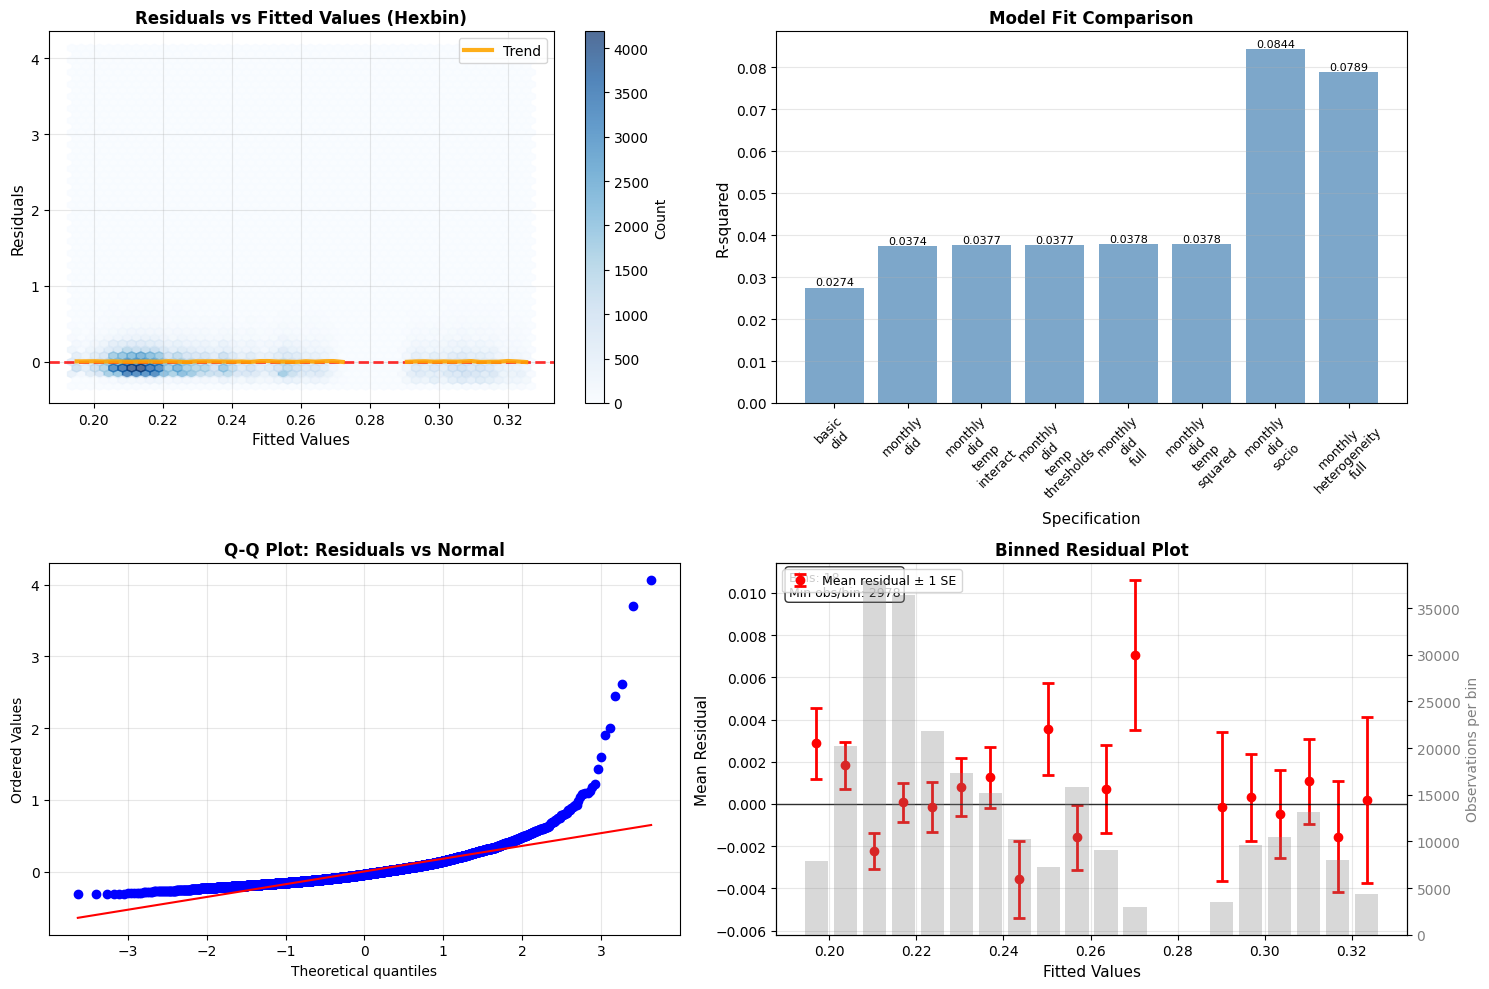


DIAGNOSTIC SUMMARY:
Model: monthly_heterogeneity_full
Observations: 251,248
Residual std: 0.185782
Mean absolute residual: 0.132623
Fitted-|Residual| correlation: 0.1296
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 251248 | R²: 0.0274 | AIC: -130178.5 | Monthly Sig: N/A
monthly_did               | N: 251248 | R²: 0.0374 | AIC: -132723.6 | Monthly Sig: 0/9
monthly_did_temp_interact | N: 251248 | R²: 0.0377 | AIC: -132766.3 | Monthly Sig: 0/9
monthly_did_temp_thresholds | N: 251248 | R²: 0.0377 | AIC: -132764.0 | Monthly Sig: 0/9
monthly_did_full          | N: 250000 | R²: 0.0378 | AIC: -131810.2 | Monthly Sig: 0/9
monthly_did_temp_squared  | N: 250000 | R²: 0.0378 | AIC: -131808.5 | Monthly Sig: 0/9
monthly_did_socio         | N: 250000 | R²: 0.0844 | AIC: -144191.5 | Monthly Sig: 0/

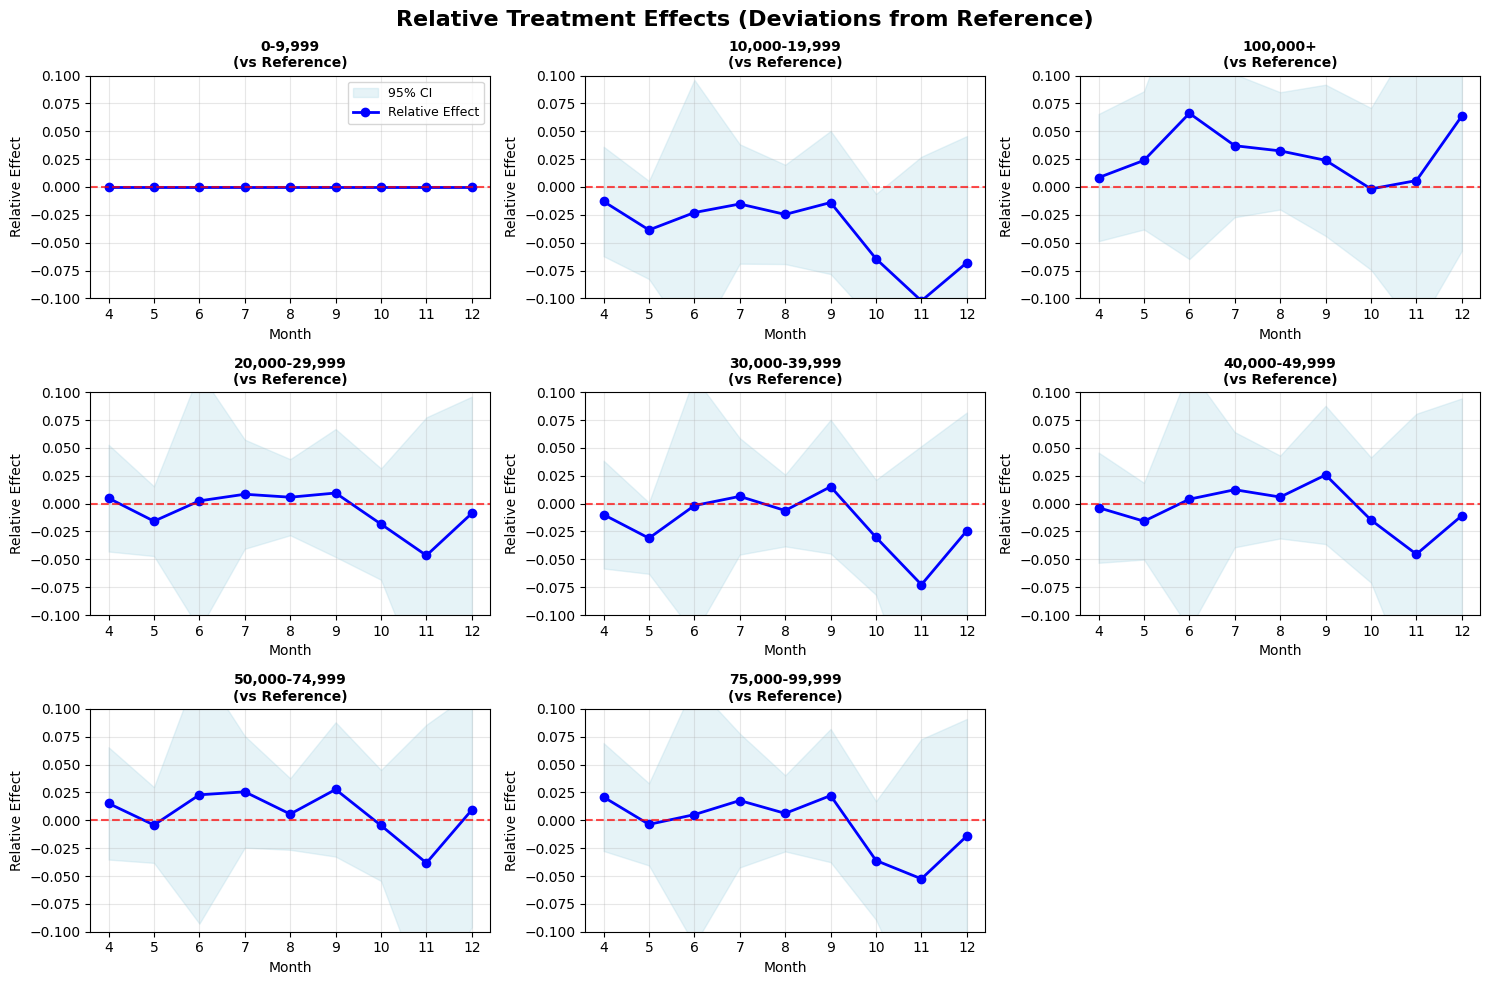

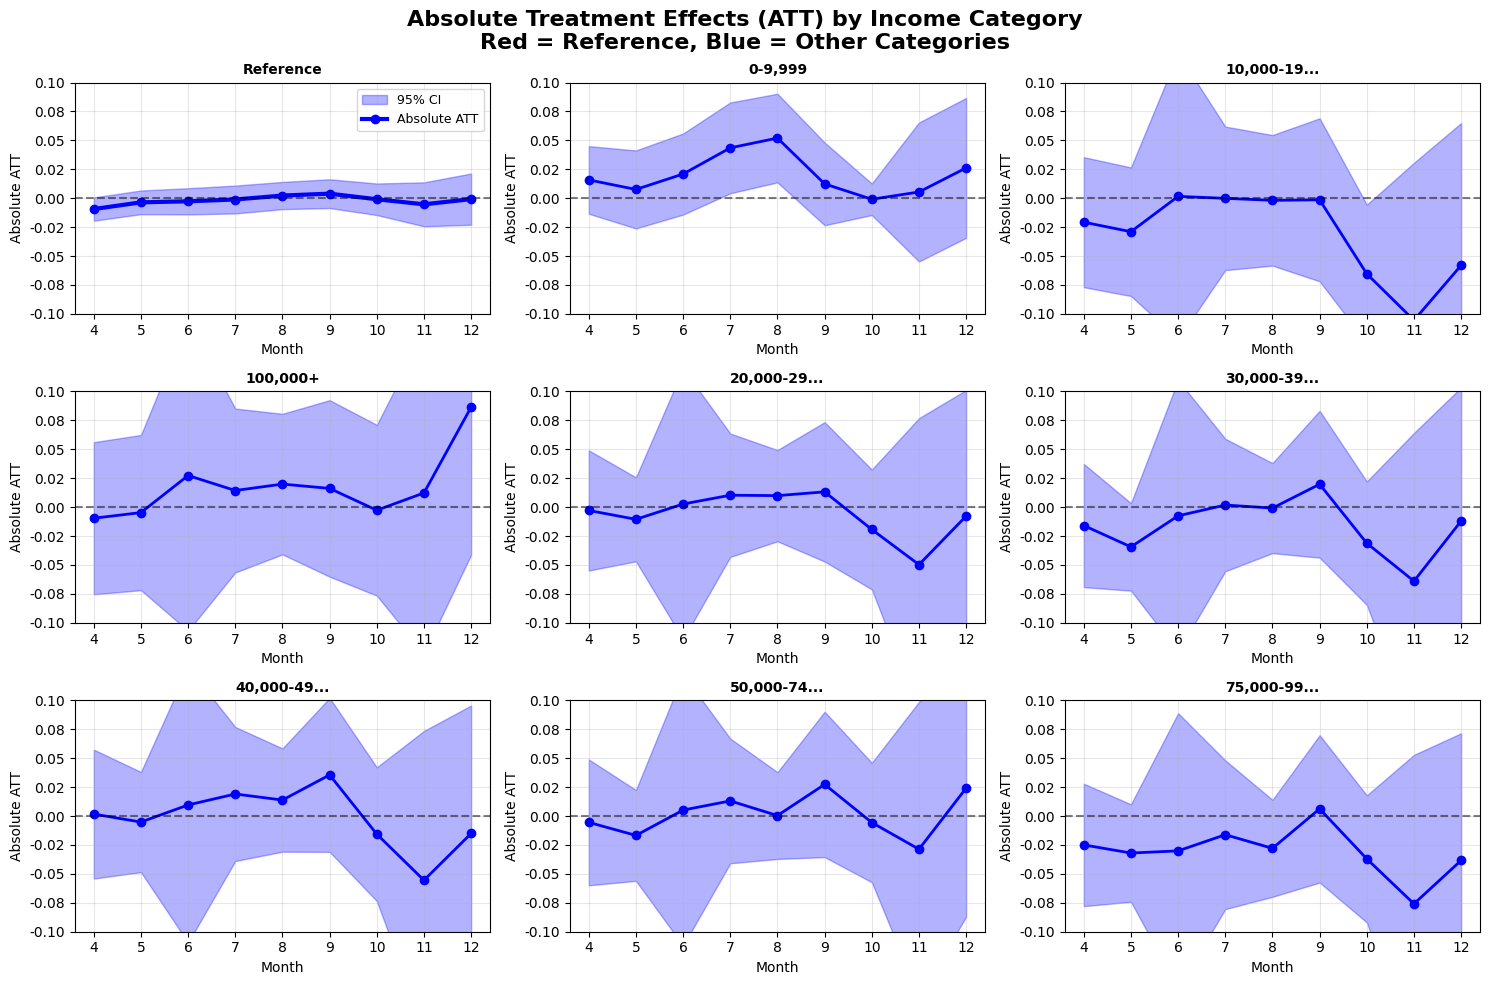


HETEROGENEITY SUMMARY:
0                  | Rel sig: 0/9 | Abs sig: 0/9
0-9,999            | Rel sig: 0/9 | Abs sig: 0/9
10,000-19,999      | Rel sig: 1/9 | Abs sig: 1/9
100,000+           | Rel sig: 0/9 | Abs sig: 0/9
20,000-29,999      | Rel sig: 0/9 | Abs sig: 0/9
30,000-39,999      | Rel sig: 0/9 | Abs sig: 0/9
40,000-49,999      | Rel sig: 0/9 | Abs sig: 0/9
50,000-74,999      | Rel sig: 0/9 | Abs sig: 0/9
75,000-99,999      | Rel sig: 0/9 | Abs sig: 0/9

Total effects tested: 81
Significant relative effects: 1
Significant absolute effects: 1


In [25]:
# Run the enhanced robustness pipeline with INCOME_CATEGORY as the heterogeneity variable

pipeline_income, results_income, updated_df_income = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged,
    socio_df=socio_df,
    test_heterogeneity=True,
    heterogeneity_vars=['INCOME_CATEGORY'],  # Changed from Cluster_Comp06_k07 to INCOME_CATEGORY
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP'],  # Removed INCOME_CATEGORY since it's now the heterogeneity variable
    include_socio_post_controls=False,
    apply_uniform_bands=False,
    temp_var='Temp_avg'
)

# Extract heterogeneity results with controls
results_HTE_df_income = pipeline_income.get_heterogeneity_results_df(
    heterogeneity_var='INCOME_CATEGORY',
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP']  # Don't include INCOME_CATEGORY here since it's the heterogeneity variable
)

# Create the plots
pipeline_income.plot_heterogeneity_from_df(results_HTE_df_income, plot_type='both')

### 3.2.2 Children at home

ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['HOUSEHOLD_SIZE', 'AGE_GROUP']
✓ Temperature variable: Temp_avg
Data shape: (251248, 11)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: peak_kwh ~ Treatment + Post + Temp_avg + Treatment:Post
✓ Success: N=251248.0, R²=0.0274

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.027
Model:                            OLS   Adj. R-sq

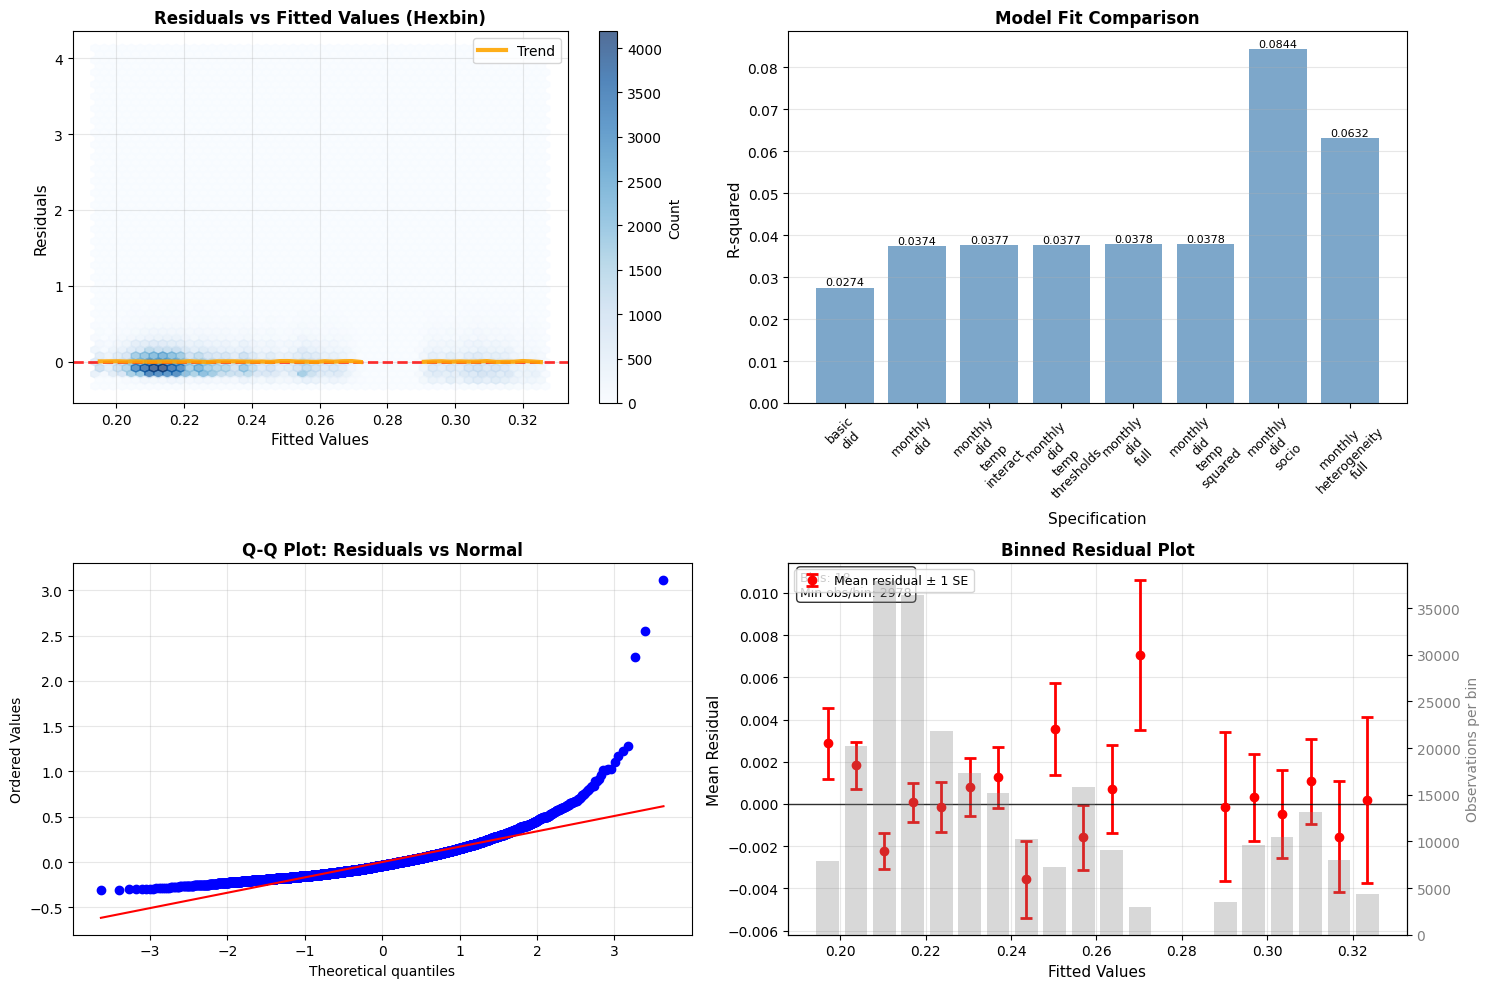


DIAGNOSTIC SUMMARY:
Model: monthly_heterogeneity_full
Observations: 251,248
Residual std: 0.185782
Mean absolute residual: 0.132623
Fitted-|Residual| correlation: 0.1296
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 251248 | R²: 0.0274 | AIC: -130178.5 | Monthly Sig: N/A
monthly_did               | N: 251248 | R²: 0.0374 | AIC: -132723.6 | Monthly Sig: 0/9
monthly_did_temp_interact | N: 251248 | R²: 0.0377 | AIC: -132766.3 | Monthly Sig: 0/9
monthly_did_temp_thresholds | N: 251248 | R²: 0.0377 | AIC: -132764.0 | Monthly Sig: 0/9
monthly_did_full          | N: 250000 | R²: 0.0378 | AIC: -131810.2 | Monthly Sig: 0/9
monthly_did_temp_squared  | N: 250000 | R²: 0.0378 | AIC: -131808.5 | Monthly Sig: 0/9
monthly_did_socio         | N: 250000 | R²: 0.0844 | AIC: -144191.5 | Monthly Sig: 0/

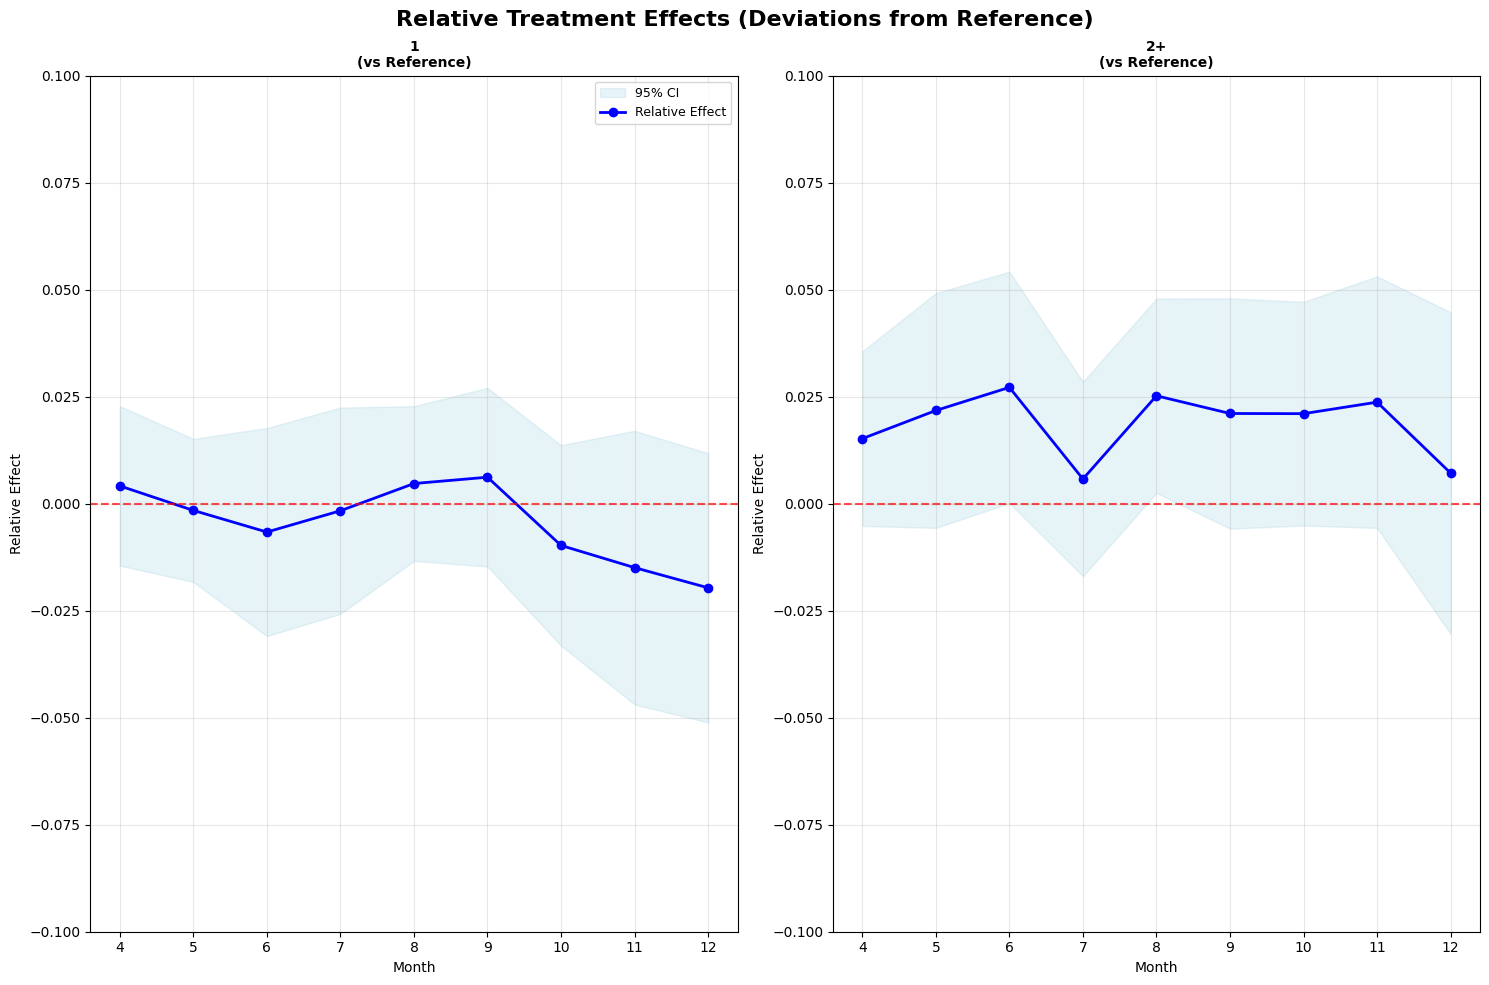

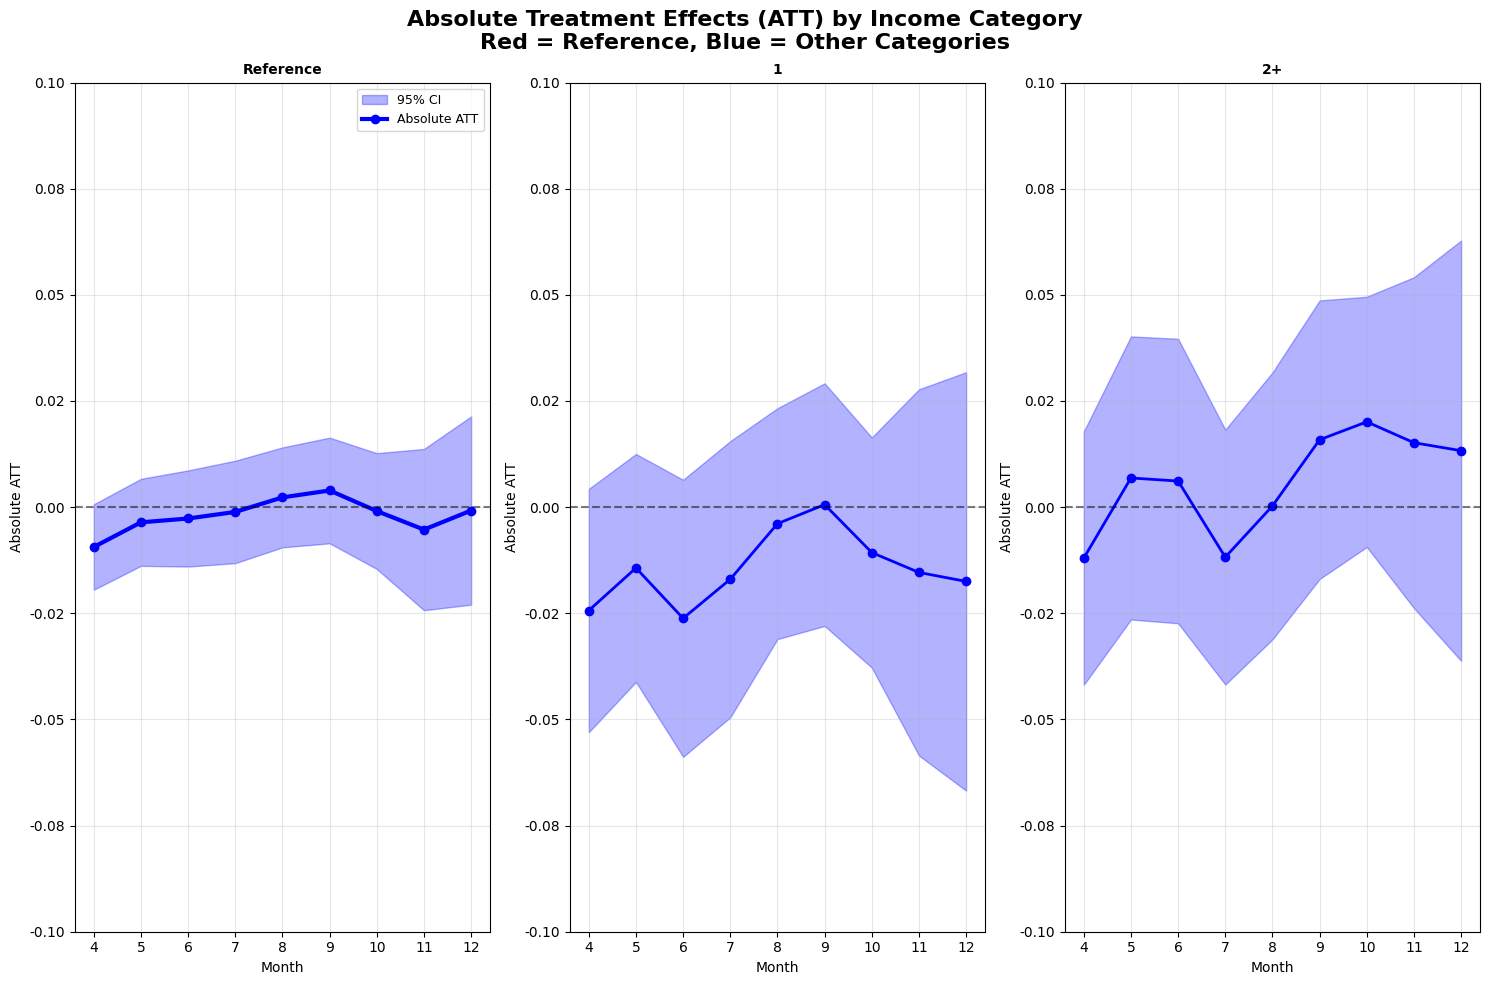


HETEROGENEITY SUMMARY:
0                  | Rel sig: 0/9 | Abs sig: 0/9
1                  | Rel sig: 0/9 | Abs sig: 0/9
2+                 | Rel sig: 2/9 | Abs sig: 2/9

Total effects tested: 27
Significant relative effects: 2
Significant absolute effects: 2


In [ ]:
# Run the enhanced robustness pipeline with CHILDREN_AT_HOME as the heterogeneity variable
heterogeneity_var = 'CHILDREN_AT_HOME'
pipeline_income, results_income, updated_df_income = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged,
    socio_df=socio_df,
    test_heterogeneity=True,
    heterogeneity_vars=['CHILDREN_AT_HOME'],
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP'],
    include_socio_post_controls=False,
    apply_uniform_bands=False,
    temp_var='Temp_avg'
)

# Extract heterogeneity results with controls
results_HTE_df_income = pipeline_income.get_heterogeneity_results_df(
    heterogeneity_var='CHILDREN_AT_HOME',
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP']
)

# Create the plots
pipeline_income.plot_heterogeneity_from_df(results_HTE_df_income, plot_type='both')

ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['INCOME_CATEGORY']
✓ Temperature variable: Temp_avg
Data shape: (251248, 11)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: peak_kwh ~ Treatment + Post + Temp_avg + Treatment:Post
✓ Success: N=251248.0, R²=0.0274

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:      

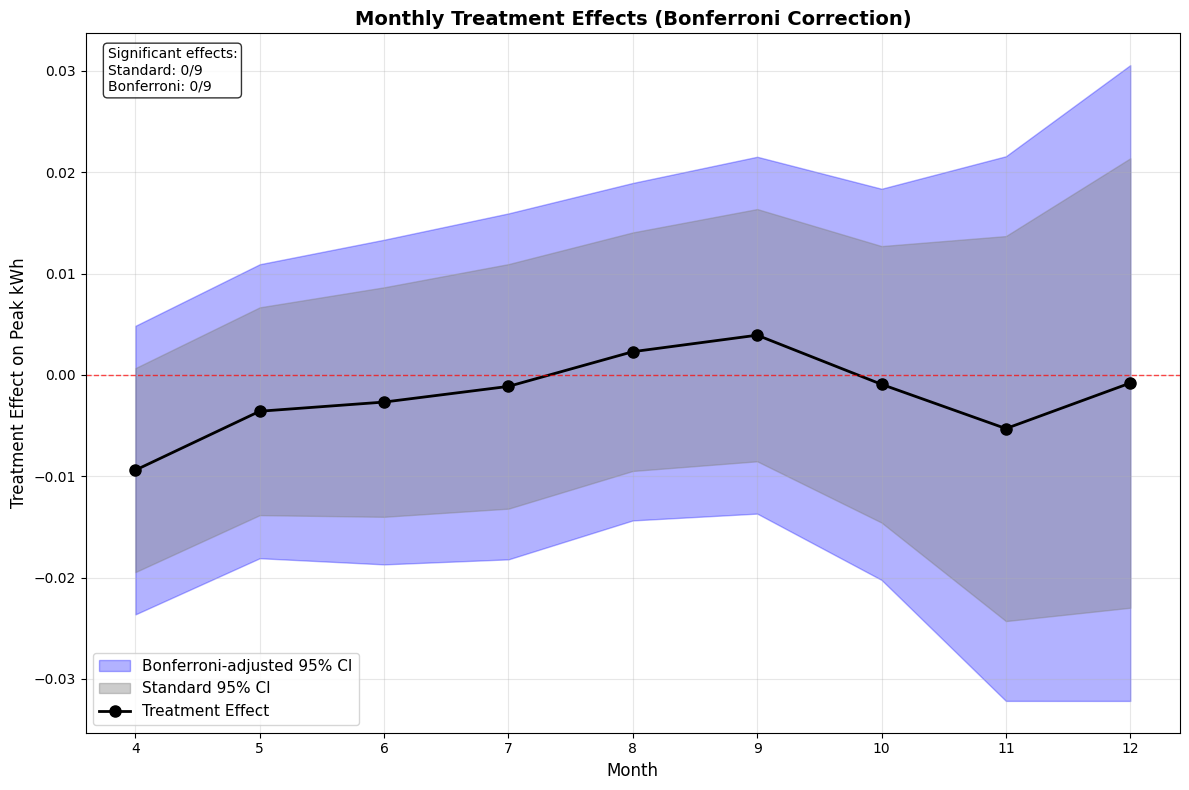


MONTHLY TREATMENT EFFECTS SUMMARY (BONFERRONI CORRECTION):
Month  Effect   SE     P-val    95%CI            Bonferroni       Sig
----------------------------------------------------------------------
4      -0.0094  0.0051 0.6057   [-0.019, 0.001]  [-0.024, 0.005]  
5      -0.0036  0.0052 1.0000   [-0.014, 0.007]  [-0.018, 0.011]  
6      -0.0027  0.0058 1.0000   [-0.014, 0.009]  [-0.019, 0.013]  
7      -0.0011  0.0062 1.0000   [-0.013, 0.011]  [-0.018, 0.016]  
8      0.0023   0.0060 1.0000   [-0.009, 0.014]  [-0.014, 0.019]  
9      0.0039   0.0063 1.0000   [-0.009, 0.016]  [-0.014, 0.022]  
10     -0.0009  0.0070 1.0000   [-0.015, 0.013]  [-0.020, 0.018]  
11     -0.0053  0.0097 1.0000   [-0.024, 0.014]  [-0.032, 0.022]  
12     -0.0008  0.0113 1.0000   [-0.023, 0.021]  [-0.032, 0.031]  
Enhanced diagnostic plots:


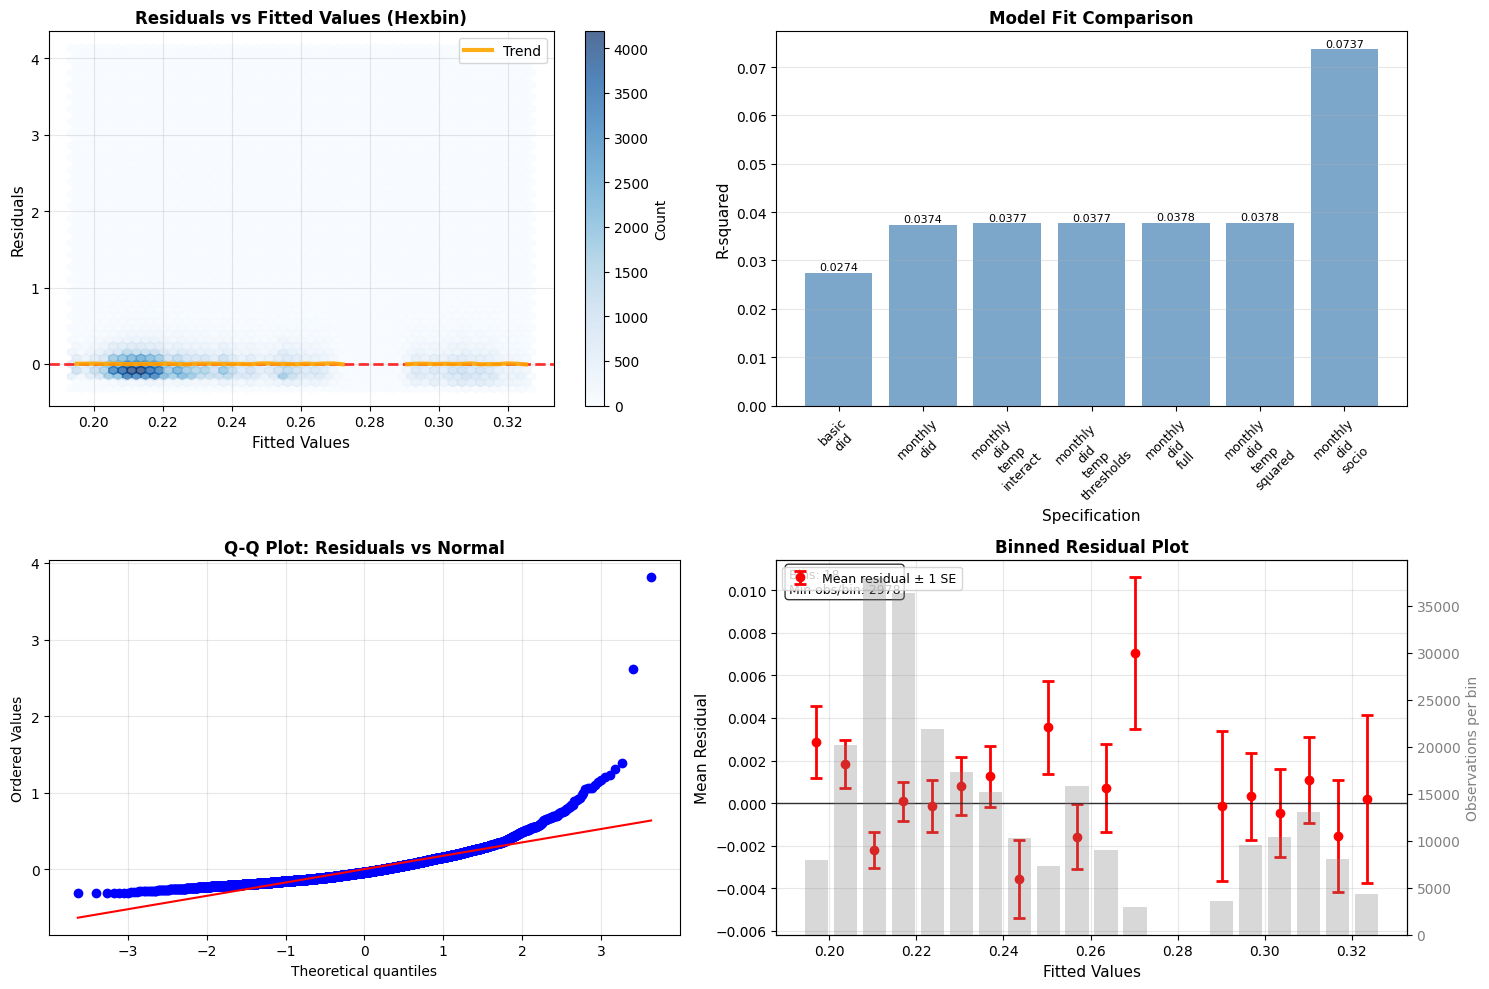


DIAGNOSTIC SUMMARY:
Model: monthly_did_socio
Observations: 251,248
Residual std: 0.185782
Mean absolute residual: 0.132623
Fitted-|Residual| correlation: 0.1296
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 251248 | R²: 0.0274 | AIC: -130178.5 | Monthly Sig: N/A
monthly_did               | N: 251248 | R²: 0.0374 | AIC: -132723.6 | Monthly Sig: 0/9
monthly_did_temp_interact | N: 251248 | R²: 0.0377 | AIC: -132766.3 | Monthly Sig: 0/9
monthly_did_temp_thresholds | N: 251248 | R²: 0.0377 | AIC: -132764.0 | Monthly Sig: 0/9
monthly_did_full          | N: 250000 | R²: 0.0378 | AIC: -131810.2 | Monthly Sig: 0/9
monthly_did_temp_squared  | N: 250000 | R²: 0.0378 | AIC: -131808.5 | Monthly Sig: 0/9
monthly_did_socio         | N: 250000 | R²: 0.0737 | AIC: -141297.1 | Monthly Sig: 0/9

MULTIP

In [ ]:
# Basic usage
# key_controls = ['INCOME_CATEGORY', 'AGE_GROUP']
# heterogeneity_vars=['Cluster_Comp06_k07']
# Complete pipeline with key controls
pipeline, results, updated_df = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged,
    socio_df=socio_df,
    test_heterogeneity=True,
    heterogeneity_vars=['Cluster_Comp06_k07'],
    key_controls=['INCOME_CATEGORY'],
    include_socio_post_controls=False,
    apply_uniform_bands=False,
    temp_var='Temp_avg'
)

# Then extract heterogeneity results with controls
results_HTE_df = pipeline.get_heterogeneity_results_df(
    heterogeneity_var='Cluster_Comp06_k07',
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE', 'AGE_GROUP']
)

# Create the plots

pipeline.plot_heterogeneity_from_df(results_HTE_df, plot_type='both')

### 3.2.3 No covariate

ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['HOUSEHOLD_SIZE', 'AGE_GROUP']
✓ Temperature variable: Temp_avg
Data shape: (251248, 11)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: peak_kwh ~ Treatment + Post + Temp_avg + Treatment:Post
✓ Success: N=251248.0, R²=0.0274

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:               peak_kwh   R-squared:                       0.027
Model:                            OLS   Adj. R-sq

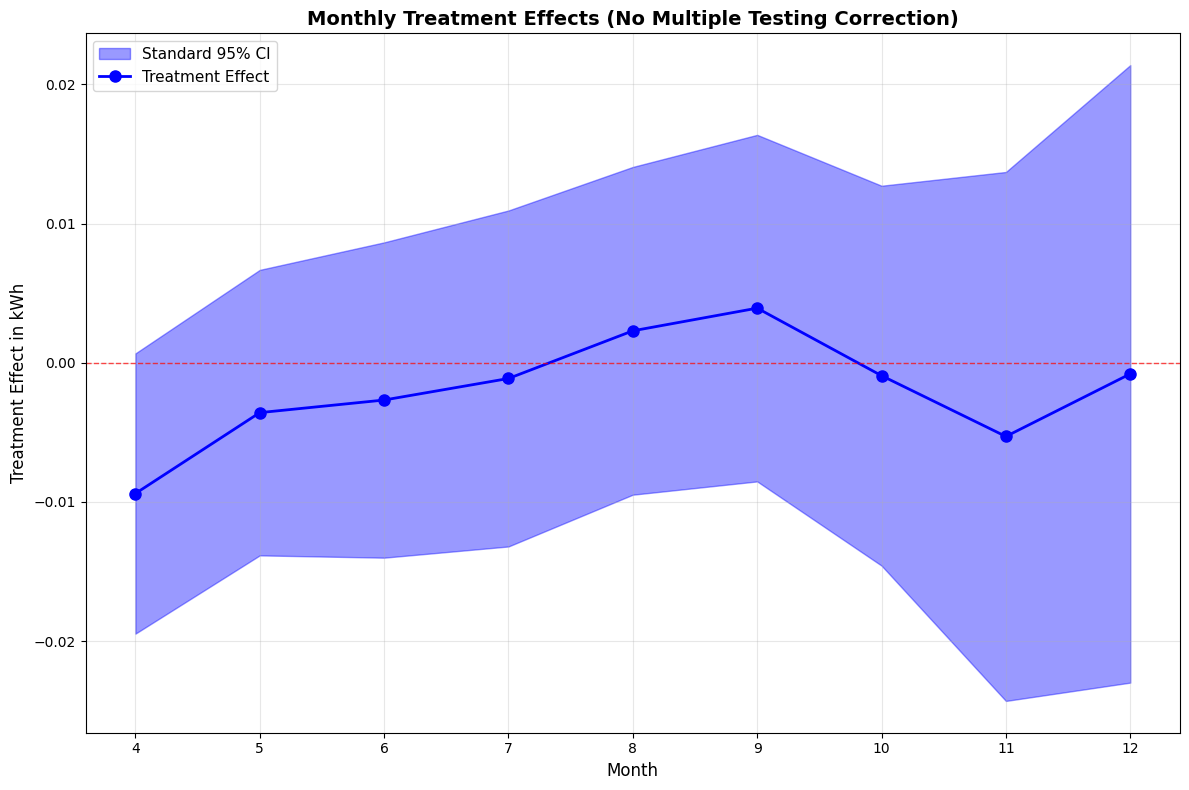


MONTHLY TREATMENT EFFECTS SUMMARY (NO CORRECTION):
Month  Effect   SE     P-val    95%CI            Sig
------------------------------------------------------------
4      -0.0094  0.0051 0.0673   [-0.019, 0.001]  
5      -0.0036  0.0052 0.4933   [-0.014, 0.007]  
6      -0.0027  0.0058 0.6429   [-0.014, 0.009]  
7      -0.0011  0.0062 0.8542   [-0.013, 0.011]  
8      0.0023   0.0060 0.7026   [-0.009, 0.014]  
9      0.0039   0.0063 0.5369   [-0.009, 0.016]  
10     -0.0009  0.0070 0.8938   [-0.015, 0.013]  
11     -0.0053  0.0097 0.5848   [-0.024, 0.014]  
12     -0.0008  0.0113 0.9436   [-0.023, 0.021]  
Enhanced diagnostic plots:


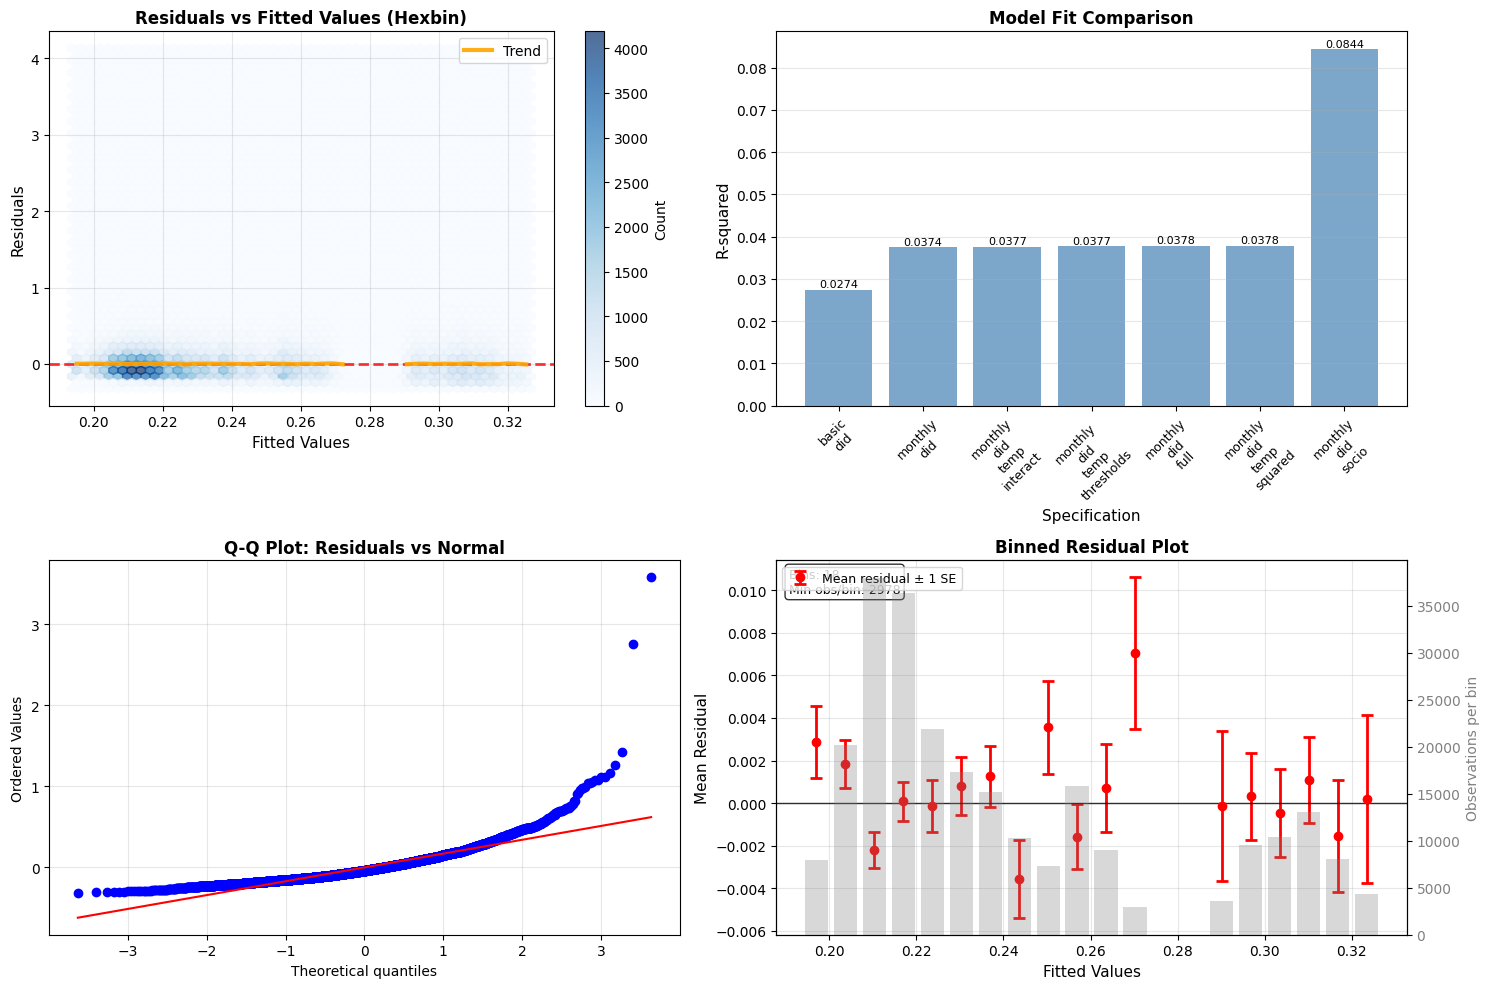


DIAGNOSTIC SUMMARY:
Model: monthly_did_socio
Observations: 251,248
Residual std: 0.185782
Mean absolute residual: 0.132623
Fitted-|Residual| correlation: 0.1296
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 251248 | R²: 0.0274 | AIC: -130178.5 | Monthly Sig: N/A
monthly_did               | N: 251248 | R²: 0.0374 | AIC: -132723.6 | Monthly Sig: 0/9
monthly_did_temp_interact | N: 251248 | R²: 0.0377 | AIC: -132766.3 | Monthly Sig: 0/9
monthly_did_temp_thresholds | N: 251248 | R²: 0.0377 | AIC: -132764.0 | Monthly Sig: 0/9
monthly_did_full          | N: 250000 | R²: 0.0378 | AIC: -131810.2 | Monthly Sig: 0/9
monthly_did_temp_squared  | N: 250000 | R²: 0.0378 | AIC: -131808.5 | Monthly Sig: 0/9
monthly_did_socio         | N: 250000 | R²: 0.0844 | AIC: -144191.5 | Monthly Sig: 0/9

MULTIP

In [ ]:
# Run the enhanced robustness pipeline with INCOME_CATEGORY as the heterogeneity variable
pipeline_income, results_income, updated_df_income = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged,
    socio_df=socio_df,
    test_heterogeneity=None, # None = No specific covariate
    heterogeneity_vars=['INCOME_CATEGORY'],
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP'],
    include_socio_post_controls=False,
    apply_uniform_bands=False,
    correction_method='none',
    temp_var='Temp_avg'
)

# Extract heterogeneity results with controls
results_HTE_df_income = pipeline_income.get_heterogeneity_results_df(
    heterogeneity_var='INCOME_CATEGORY',
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP']  # Don't include INCOME_CATEGORY here since it's the heterogeneity variable
)

# Create the plots
pipeline_income.plot_heterogeneity_from_df(results_HTE_df_income, plot_type='both')

### 3.2.4 Clusters

In [ ]:
# Run the enhanced robustness pipeline with CHILDREN_AT_HOME as the heterogeneity variable

pipeline_income, results_income, updated_df_income = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged,
    socio_df=socio_df,
    test_heterogeneity=True,
    heterogeneity_vars=['Cluster_Comp06_k07'],
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP'],
    include_socio_post_controls=False,
    apply_uniform_bands=False,
    temp_var='Temp_avg'
)

# Extract heterogeneity results with controls
results_HTE_df_income = pipeline_income.get_heterogeneity_results_df(
    heterogeneity_var='Cluster_Comp06_k07',
    key_controls=['HOUSEHOLD_SIZE', 'AGE_GROUP']
)

# Create the plots
pipeline_income.plot_heterogeneity_from_df(results_HTE_df_income, plot_type='both')

## 3.3 Results for Sunday

Sunday dataframe is df_peak_merged_masked_sunday

**Target options**

1.   sunday8_12 = average consumption for sundays between 8am and 12pm.
2.   sunday8_16 = idem.
3.   sunday8_20 = idem.
4.   sunday8_24 = idem.


**Temperature options**

1.   Daily_Temp = Average temperature in that day



### 3.3.1 Clusters / 8 to 16


ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['INCOME_CATEGORY', 'HOUSEHOLD_SIZE']
✓ Temperature variable: Daily_Temp
Data shape: (45824, 12)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: sunday8_16 ~ Treatment + Post + Daily_Temp + Treatment:Post
✓ Success: N=45824.0, R²=0.0288

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:             sunday8_16   R-squared:                       0.029
Model:                            OLS  

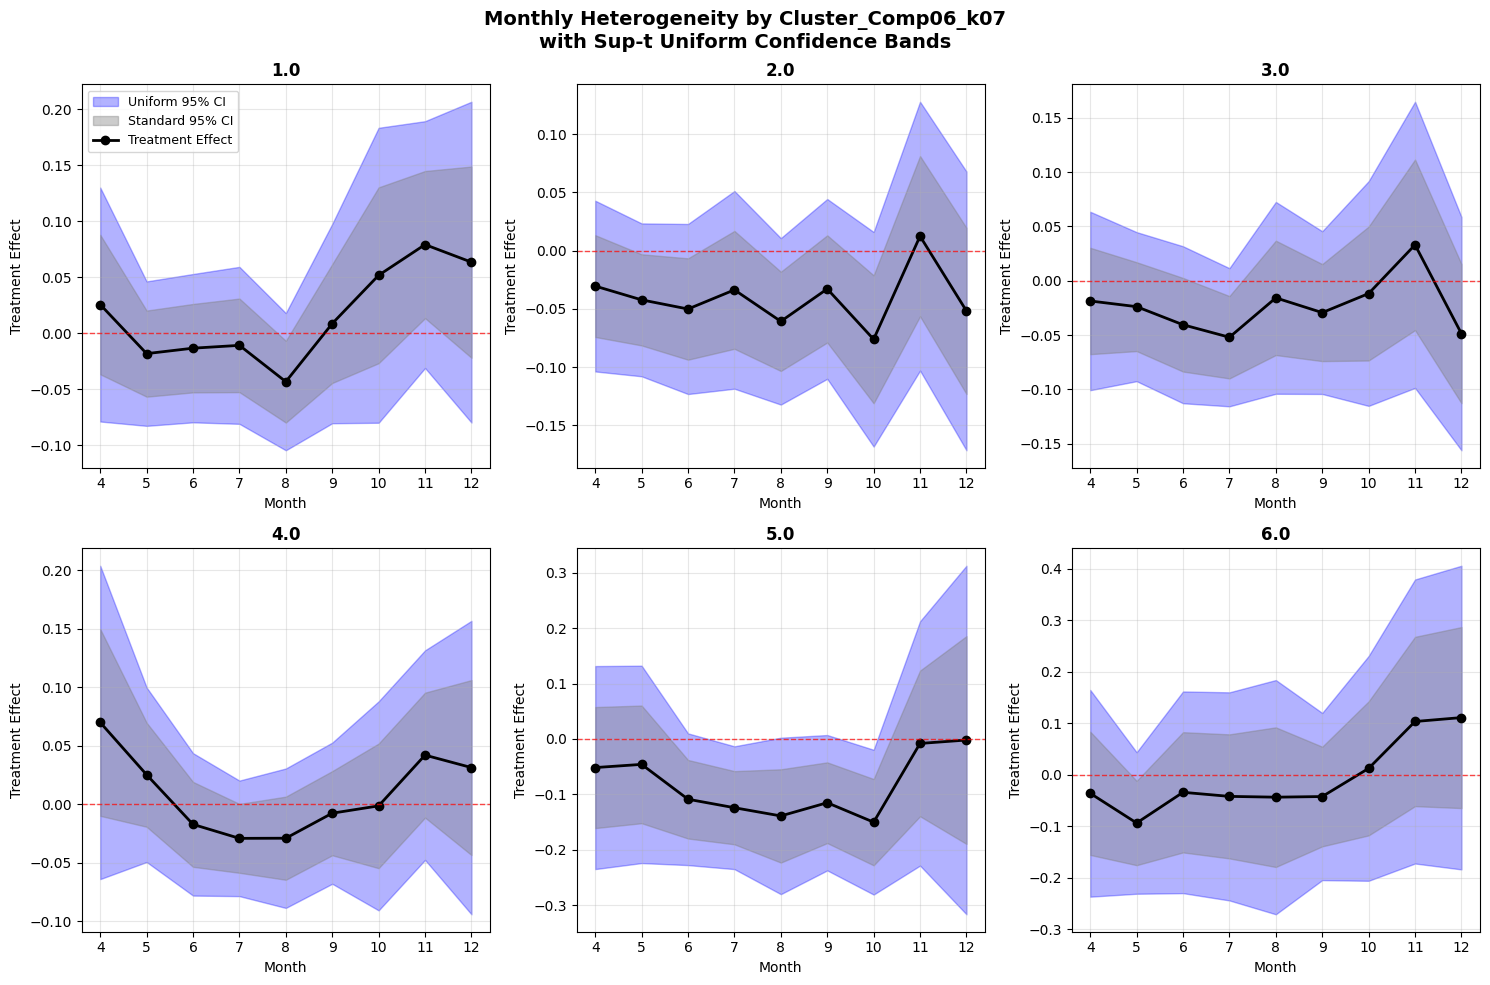


HETEROGENEITY SUMMARY FOR Cluster_Comp06_k07:
Total monthly×category effects: 54
Significant (standard CI): 11
Significant (uniform bands): 2
Reduction due to multiple testing: 9
Enhanced diagnostic plots:


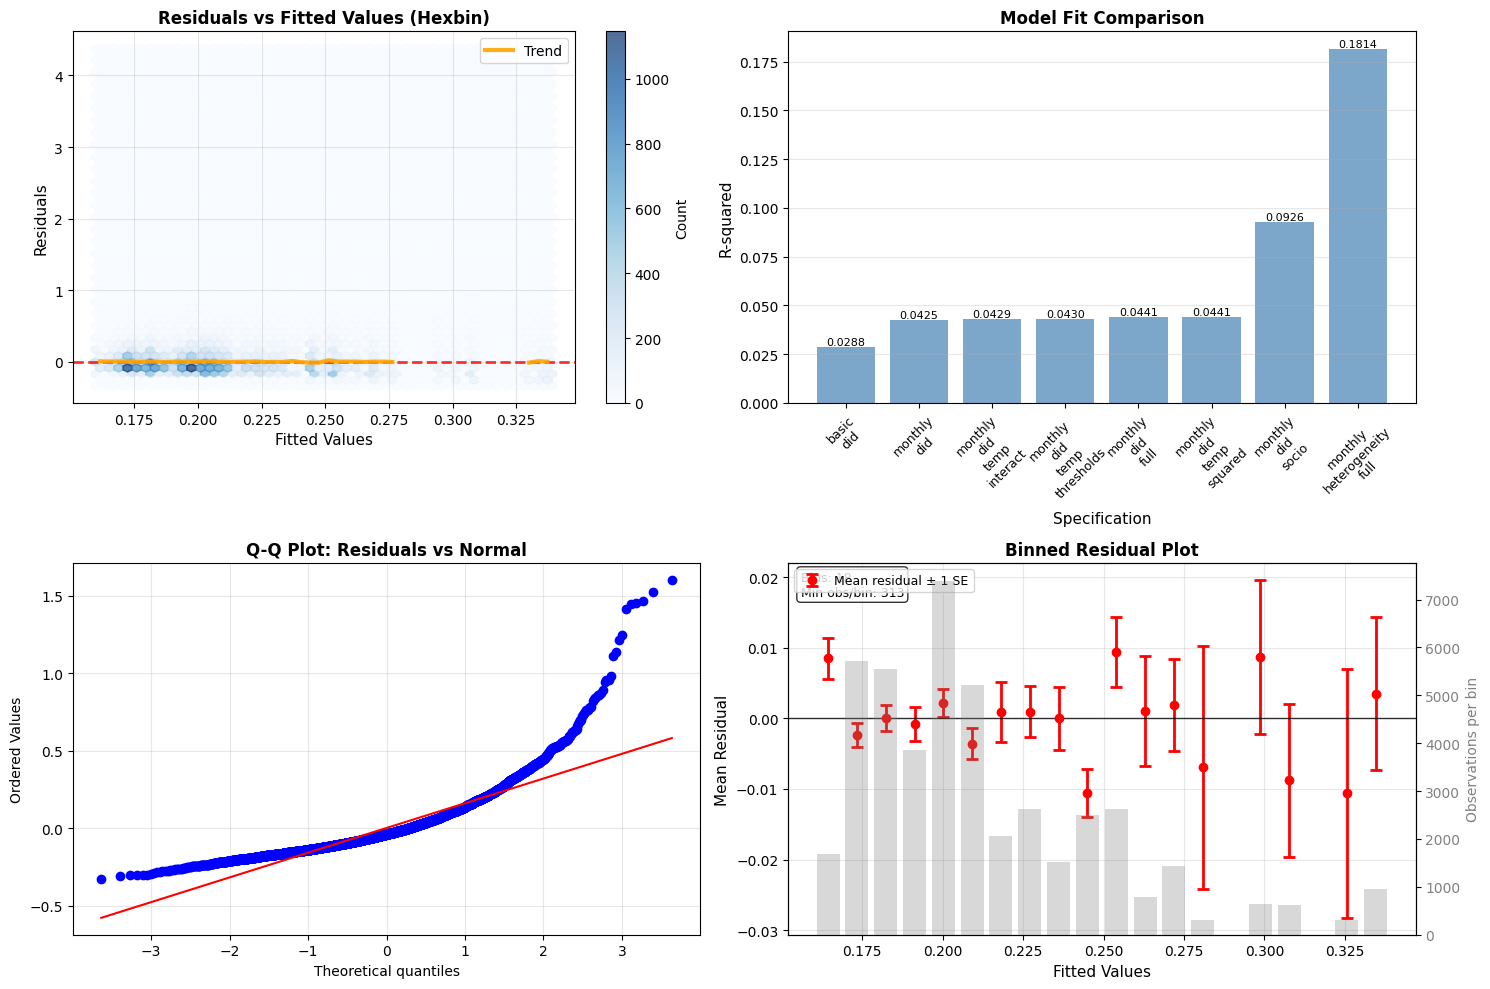


DIAGNOSTIC SUMMARY:
Model: monthly_heterogeneity_full
Observations: 45,824
Residual std: 0.181606
Mean absolute residual: 0.123471
Fitted-|Residual| correlation: 0.2055
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 45824  | R²: 0.0288 | AIC: -25639.8 | Monthly Sig: N/A
monthly_did               | N: 45824  | R²: 0.0425 | AIC: -26243.8 | Monthly Sig: 9/9
monthly_did_temp_interact | N: 45824  | R²: 0.0429 | AIC: -26244.1 | Monthly Sig: 9/9
monthly_did_temp_thresholds | N: 45824  | R²: 0.0430 | AIC: -26244.4 | Monthly Sig: 9/9
monthly_did_full          | N: 44576  | R²: 0.0441 | AIC: -25164.3 | Monthly Sig: 9/9
monthly_did_temp_squared  | N: 44576  | R²: 0.0441 | AIC: -25163.6 | Monthly Sig: 9/9
monthly_did_socio         | N: 44576  | R²: 0.0926 | AIC: -27462.5 | Monthly Sig: 9/9
monthl

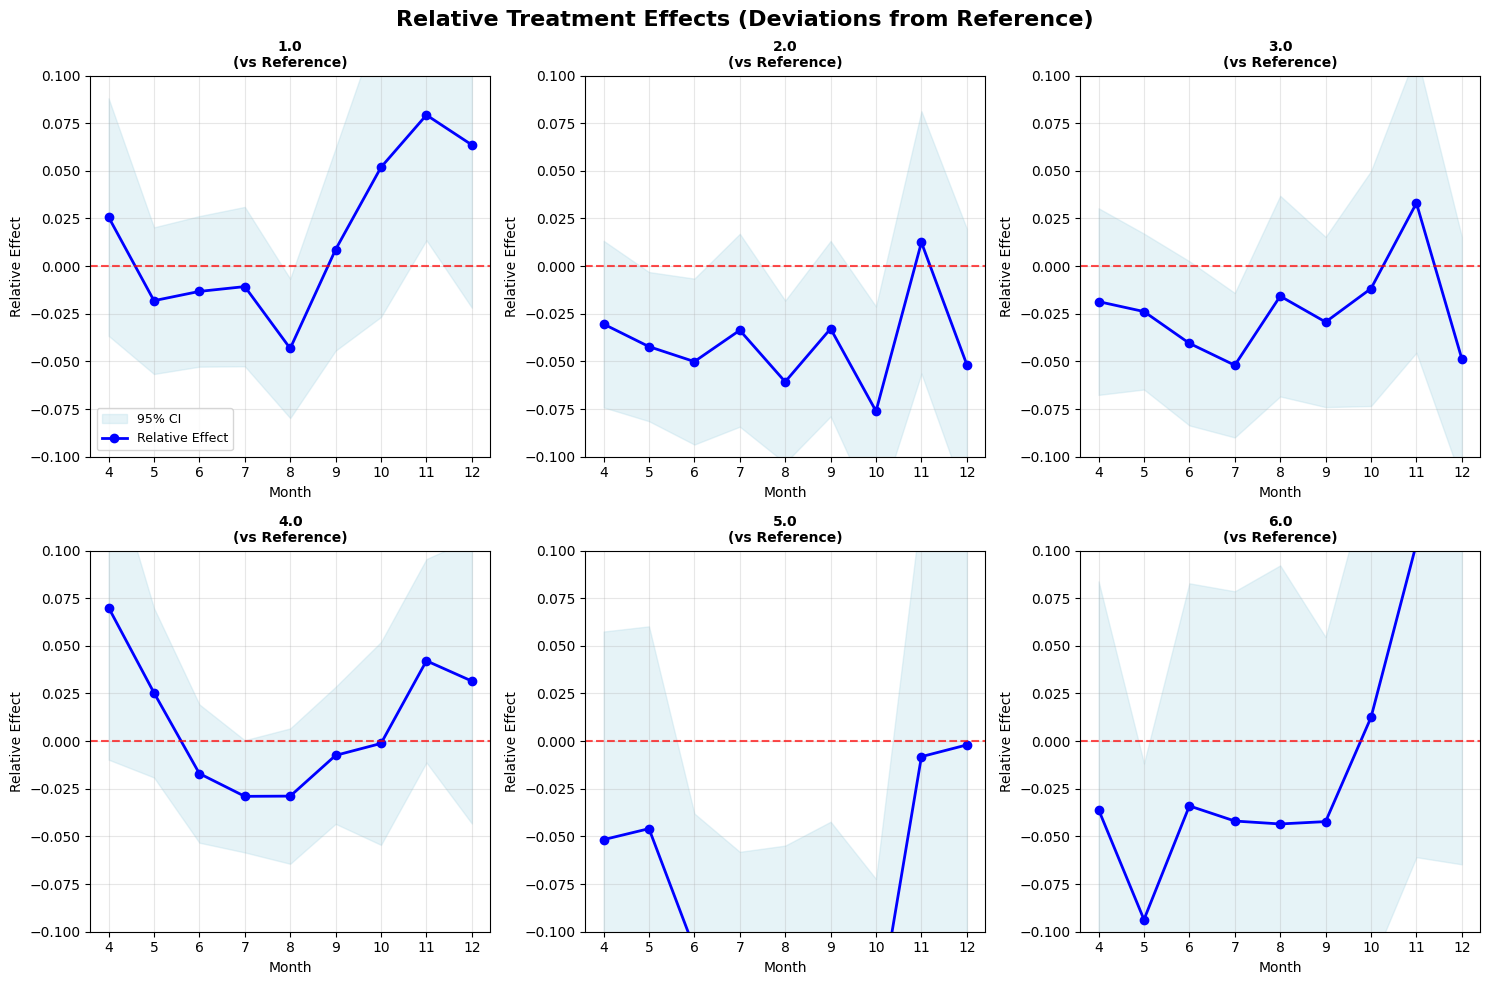

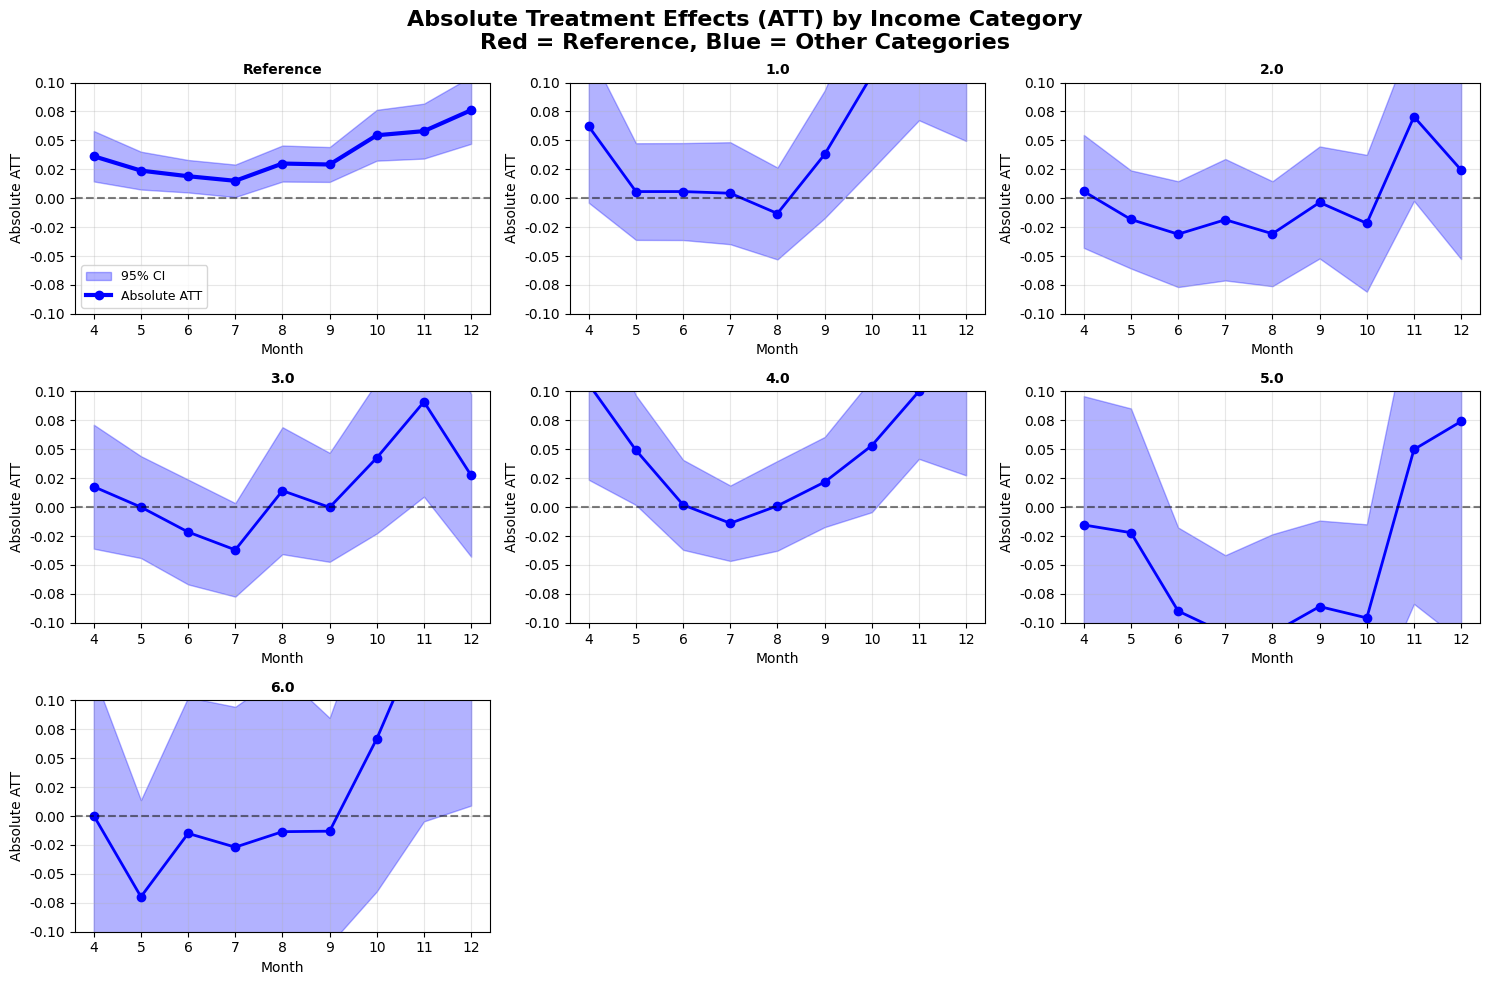


HETEROGENEITY SUMMARY:
0                  | Rel sig: 0/9 | Abs sig: 9/9
1.0                | Rel sig: 2/9 | Abs sig: 2/9
2.0                | Rel sig: 4/9 | Abs sig: 4/9
3.0                | Rel sig: 1/9 | Abs sig: 1/9
4.0                | Rel sig: 0/9 | Abs sig: 0/9
5.0                | Rel sig: 5/9 | Abs sig: 5/9
6.0                | Rel sig: 1/9 | Abs sig: 1/9

Total effects tested: 63
Significant relative effects: 13
Significant absolute effects: 22


In [ ]:

# Complete pipeline with key controls
pipeline, results, updated_df = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged_masked_sunday,
    socio_df=socio_df,
    test_heterogeneity=True,
    heterogeneity_vars=['Cluster_Comp06_k07'],
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE'],
    include_socio_post_controls=False,outcome_var='sunday8_16',
    apply_uniform_bands=True,temp_var='Daily_Temp', correction_method = 'none'
)

# Then extract heterogeneity results with controls
results_HTE_df = pipeline.get_heterogeneity_results_df(
    heterogeneity_var='Cluster_Comp06_k07',
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE', 'AGE_GROUP']
)

# Create the plots
pipeline.plot_heterogeneity_from_df(results_HTE_df, plot_type='both')

### 3.3.2 Clusters / 8 - 24

ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['INCOME_CATEGORY', 'HOUSEHOLD_SIZE']
✓ Temperature variable: Daily_Temp
Data shape: (45824, 12)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: sunday8_24 ~ Treatment + Post + Daily_Temp + Treatment:Post
✓ Success: N=45824.0, R²=0.0307

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:             sunday8_24   R-squared:                       0.031
Model:                            OLS  

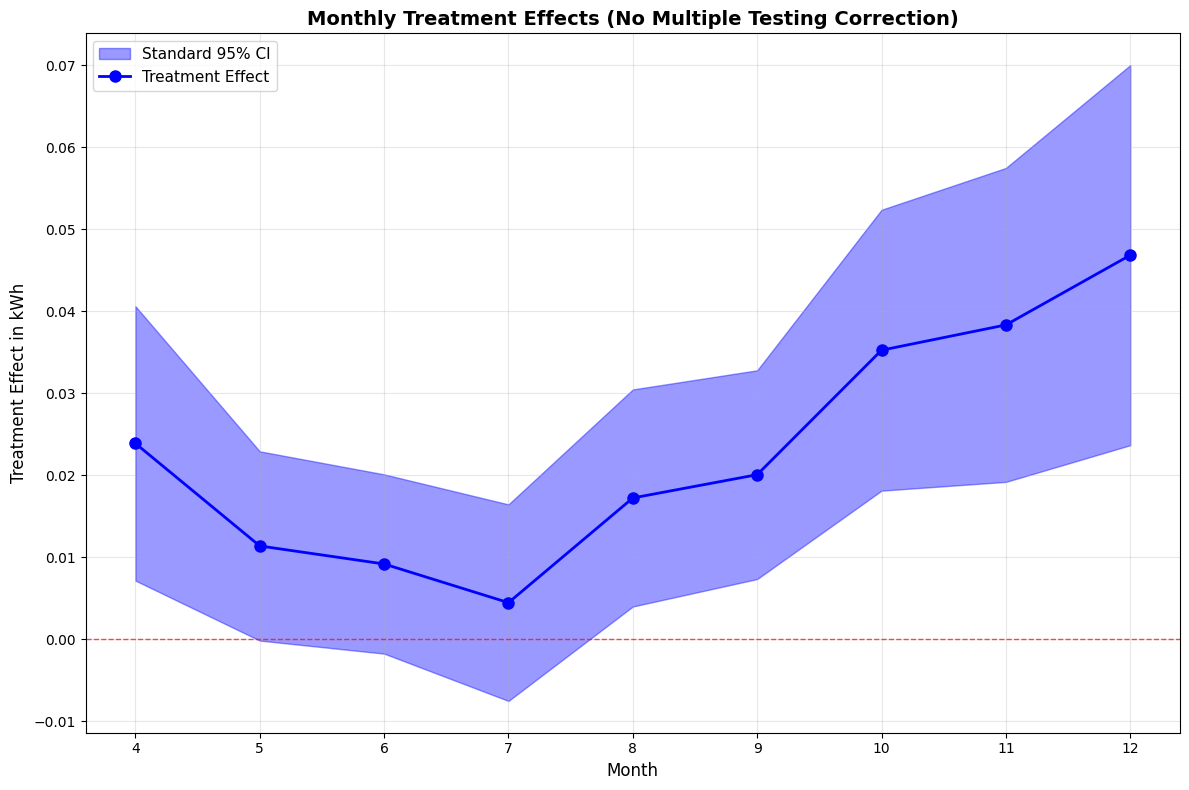


MONTHLY TREATMENT EFFECTS SUMMARY (NO CORRECTION):
Month  Effect   SE     P-val    95%CI            Sig
------------------------------------------------------------
4      0.0239   0.0085 0.0052   [0.007, 0.041]   **
5      0.0114   0.0059 0.0535   [-0.000, 0.023]  
6      0.0092   0.0056 0.1001   [-0.002, 0.020]  
7      0.0045   0.0061 0.4664   [-0.008, 0.016]  
8      0.0172   0.0068 0.0108   [0.004, 0.030]   *
9      0.0201   0.0065 0.0020   [0.007, 0.033]   **
10     0.0352   0.0087 0.0001   [0.018, 0.052]   **
11     0.0383   0.0098 0.0001   [0.019, 0.057]   **
12     0.0468   0.0118 0.0001   [0.024, 0.070]   **
Enhanced diagnostic plots:


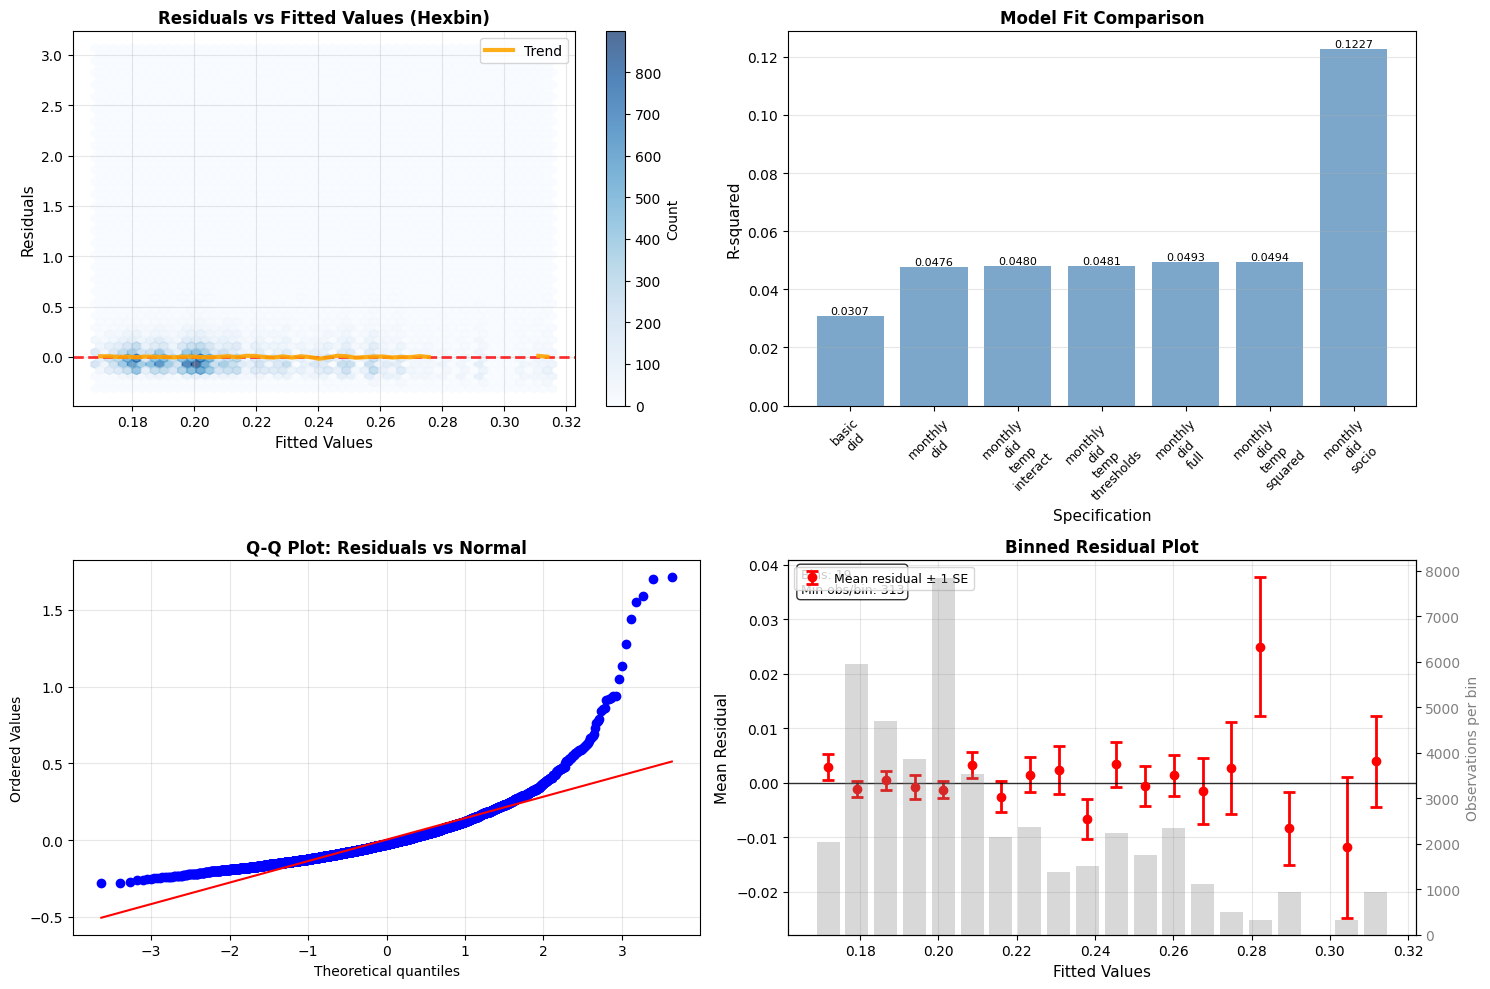


DIAGNOSTIC SUMMARY:
Model: monthly_did_socio
Observations: 45,824
Residual std: 0.150267
Mean absolute residual: 0.105878
Fitted-|Residual| correlation: 0.1797
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 45824  | R²: 0.0307 | AIC: -42847.3 | Monthly Sig: N/A
monthly_did               | N: 45824  | R²: 0.0476 | AIC: -43604.6 | Monthly Sig: 6/9
monthly_did_temp_interact | N: 45824  | R²: 0.0480 | AIC: -43608.9 | Monthly Sig: 6/9
monthly_did_temp_thresholds | N: 45824  | R²: 0.0481 | AIC: -43606.5 | Monthly Sig: 6/9
monthly_did_full          | N: 44576  | R²: 0.0493 | AIC: -42055.9 | Monthly Sig: 6/9
monthly_did_temp_squared  | N: 44576  | R²: 0.0494 | AIC: -42055.2 | Monthly Sig: 6/9
monthly_did_socio         | N: 44576  | R²: 0.1227 | AIC: -45611.6 | Monthly Sig: 7/9

MULTIPLE TESTI

In [ ]:
# Complete pipeline with key controls
pipeline, results, updated_df = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged_masked_sunday,
    socio_df=socio_df,
    test_heterogeneity=False,
    heterogeneity_vars=['Cluster_Comp06_k07'],
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE'],
    include_socio_post_controls=False,outcome_var='sunday8_24',
    apply_uniform_bands=True,temp_var='Daily_Temp', correction_method = 'none'
)

# Then extract heterogeneity results with controls
results_HTE_df = pipeline.get_heterogeneity_results_df(
    heterogeneity_var='Cluster_Comp06_k07',
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE', 'AGE_GROUP']
)

# Create the plots
pipeline.plot_heterogeneity_from_df(results_HTE_df, plot_type='both')

## 3.4 Results for Mon-Fri Out of Peak

###  3.4.1 Clusters - Out-Mid Peak (less restrictive)

ENHANCED DiD ROBUSTNESS PIPELINE
Features:
✓ Progressive model complexity (Steps 1-6)
✓ Improved diagnostic plots (hexbin, binned residuals)
✓ Full monthly heterogeneity analysis
✓ Optional socio×post controls
✓ Sup-t uniform confidence bands
✓ Key controls: ['INCOME_CATEGORY', 'HOUSEHOLD_SIZE']
✓ Temperature variable: Daily_Temp
Data shape: (251248, 11)
Months available: ['10', '11', '12', '4', '5', '6', '7', '8', '9']

STEP 1-6: BASIC ROBUSTNESS PROGRESSION
----------------------------------------
RUNNING BASIC ROBUSTNESS PIPELINE (STEPS 1-7)
STEP 1: BASIC DIFFERENCE-IN-DIFFERENCES

Running: basic_did
Description: Basic DiD treating entire post period as single treatment
Formula: out_mid_peak ~ Treatment + Post + Daily_Temp + Treatment:Post
✓ Success: N=251248.0, R²=0.0164

FULL MODEL SUMMARY:
                            OLS Regression Results                            
Dep. Variable:           out_mid_peak   R-squared:                       0.016
Model:                            O

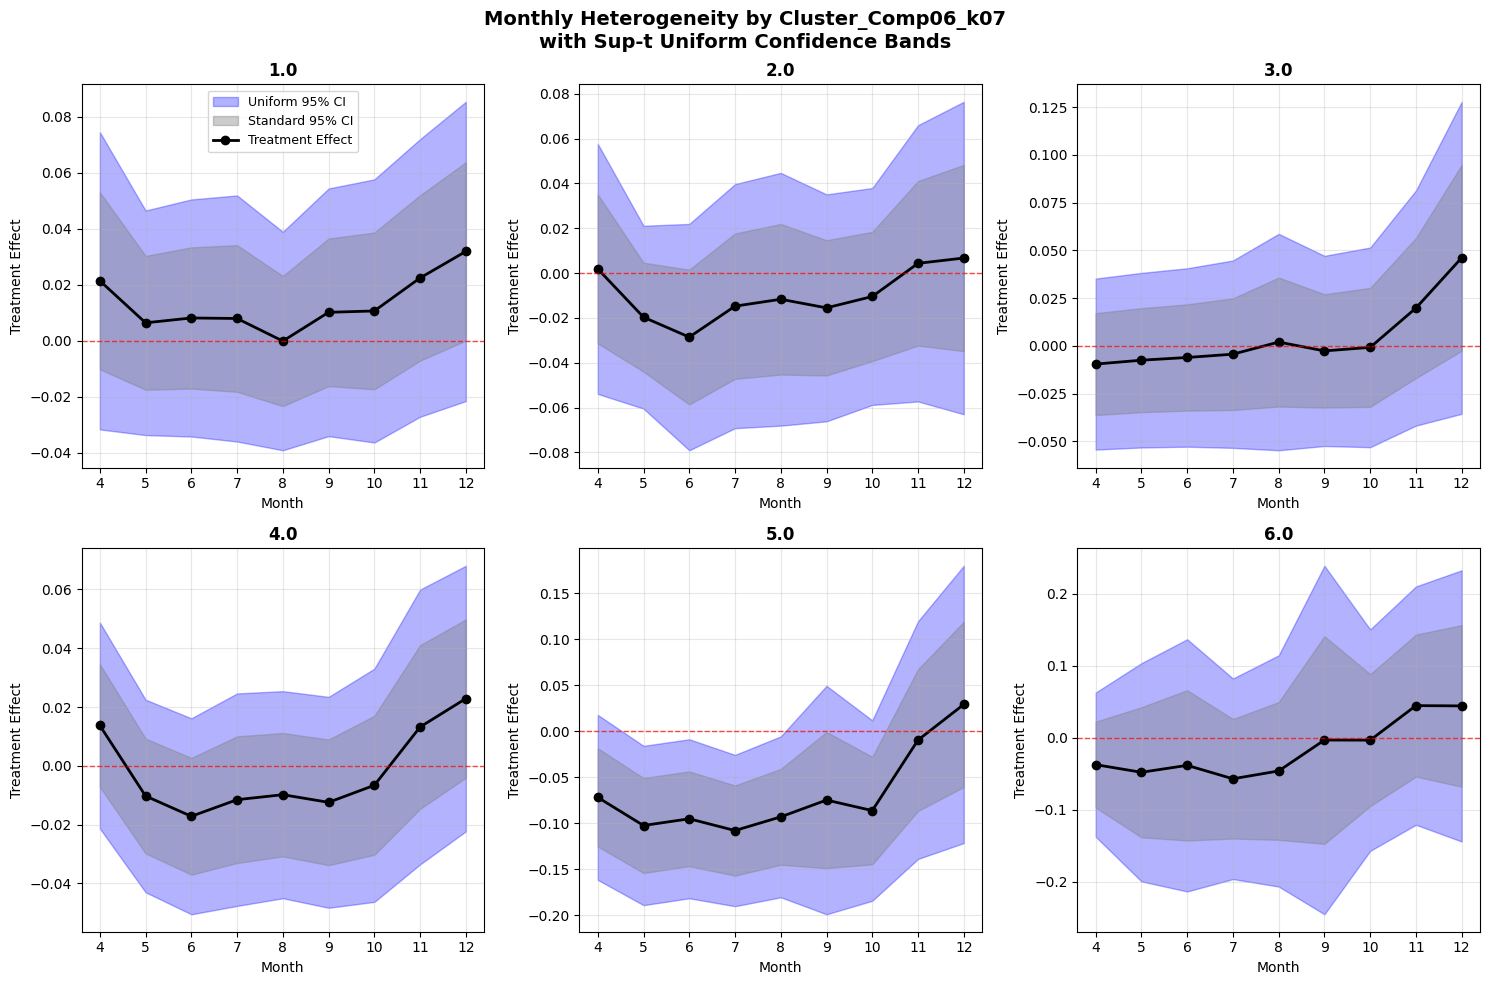


HETEROGENEITY SUMMARY FOR Cluster_Comp06_k07:
Total monthly×category effects: 54
Significant (standard CI): 4
Significant (uniform bands): 4
Reduction due to multiple testing: 0
Enhanced diagnostic plots:


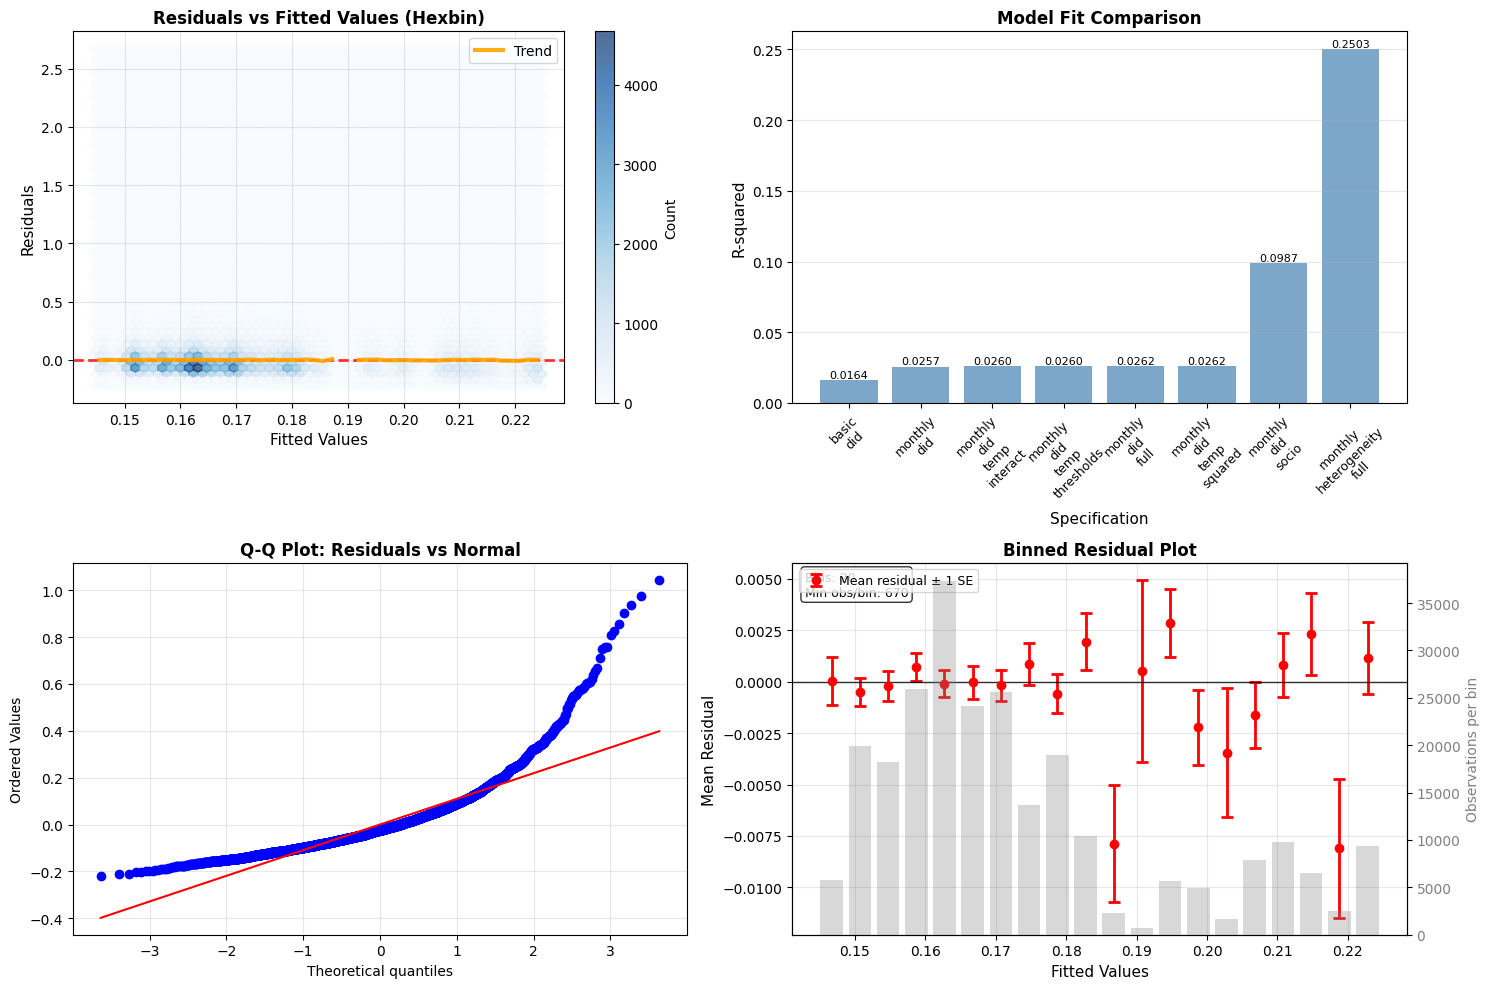


DIAGNOSTIC SUMMARY:
Model: monthly_heterogeneity_full
Observations: 251,248
Residual std: 0.124715
Mean absolute residual: 0.085481
Fitted-|Residual| correlation: 0.1287
  → Potential heteroskedasticity detected

FINAL SPECIFICATION COMPARISON

SPECIFICATION COMPARISON

Model Comparison:
----------------------------------------------------------------------------------------------------
basic_did                 | N: 251248 | R²: 0.0164 | AIC: -330656.6 | Monthly Sig: N/A
monthly_did               | N: 251248 | R²: 0.0257 | AIC: -332989.7 | Monthly Sig: 0/9
monthly_did_temp_interact | N: 251248 | R²: 0.0260 | AIC: -333048.5 | Monthly Sig: 0/9
monthly_did_temp_thresholds | N: 251248 | R²: 0.0260 | AIC: -333046.7 | Monthly Sig: 0/9
monthly_did_full          | N: 250000 | R²: 0.0262 | AIC: -331161.4 | Monthly Sig: 0/9
monthly_did_temp_squared  | N: 250000 | R²: 0.0262 | AIC: -331160.6 | Monthly Sig: 0/9
monthly_did_socio         | N: 250000 | R²: 0.0987 | AIC: -350490.6 | Monthly Sig: 0/

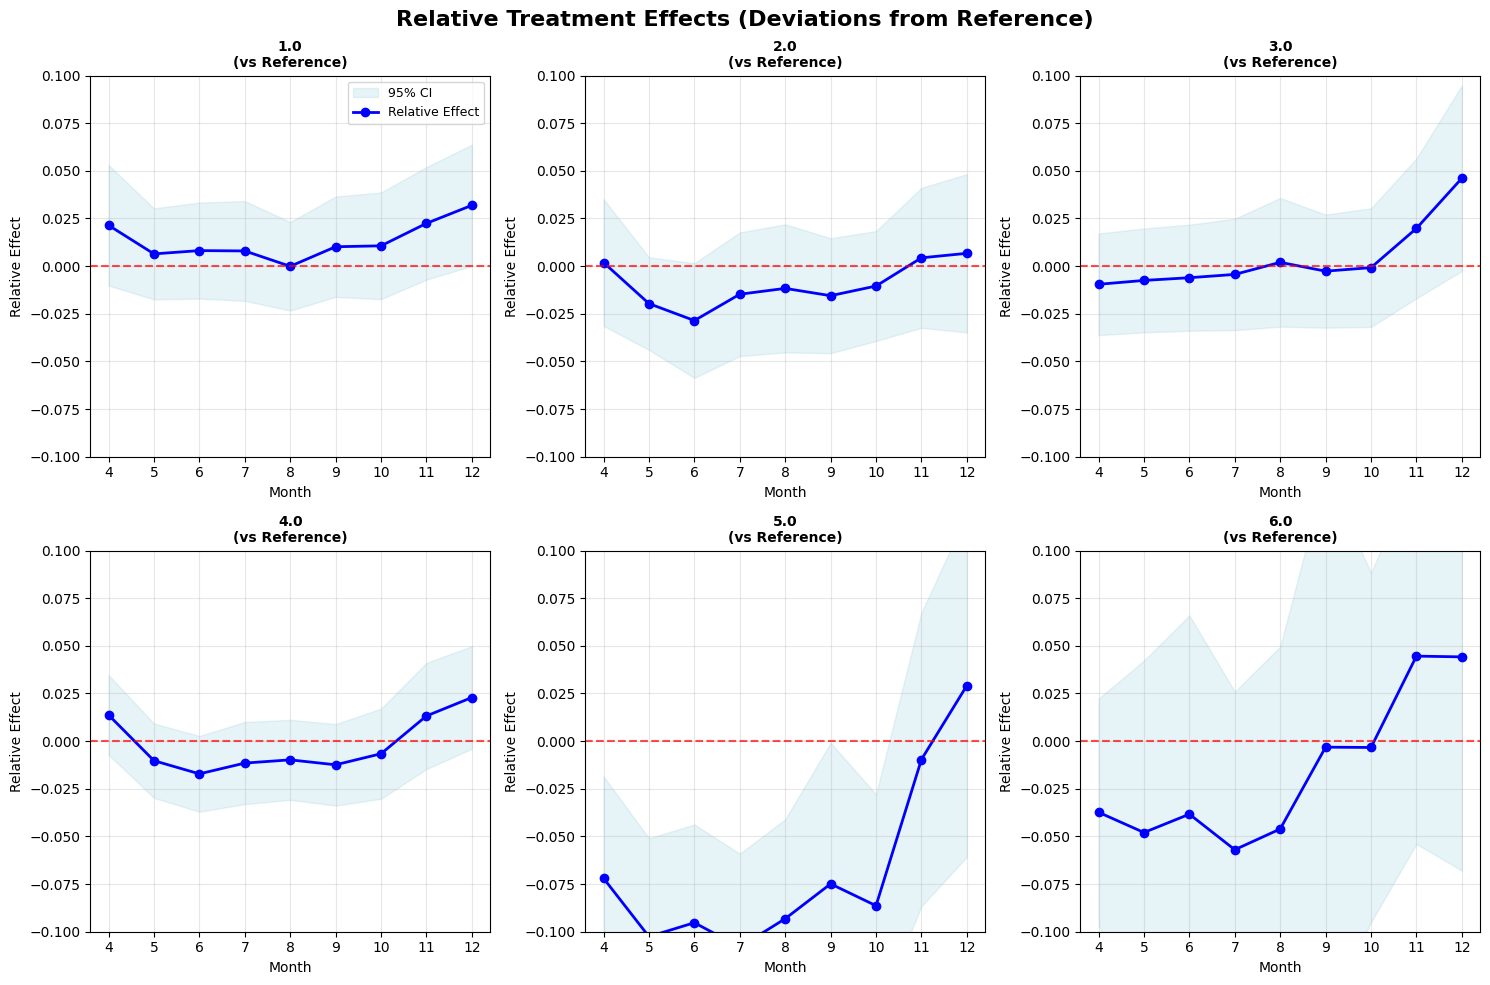

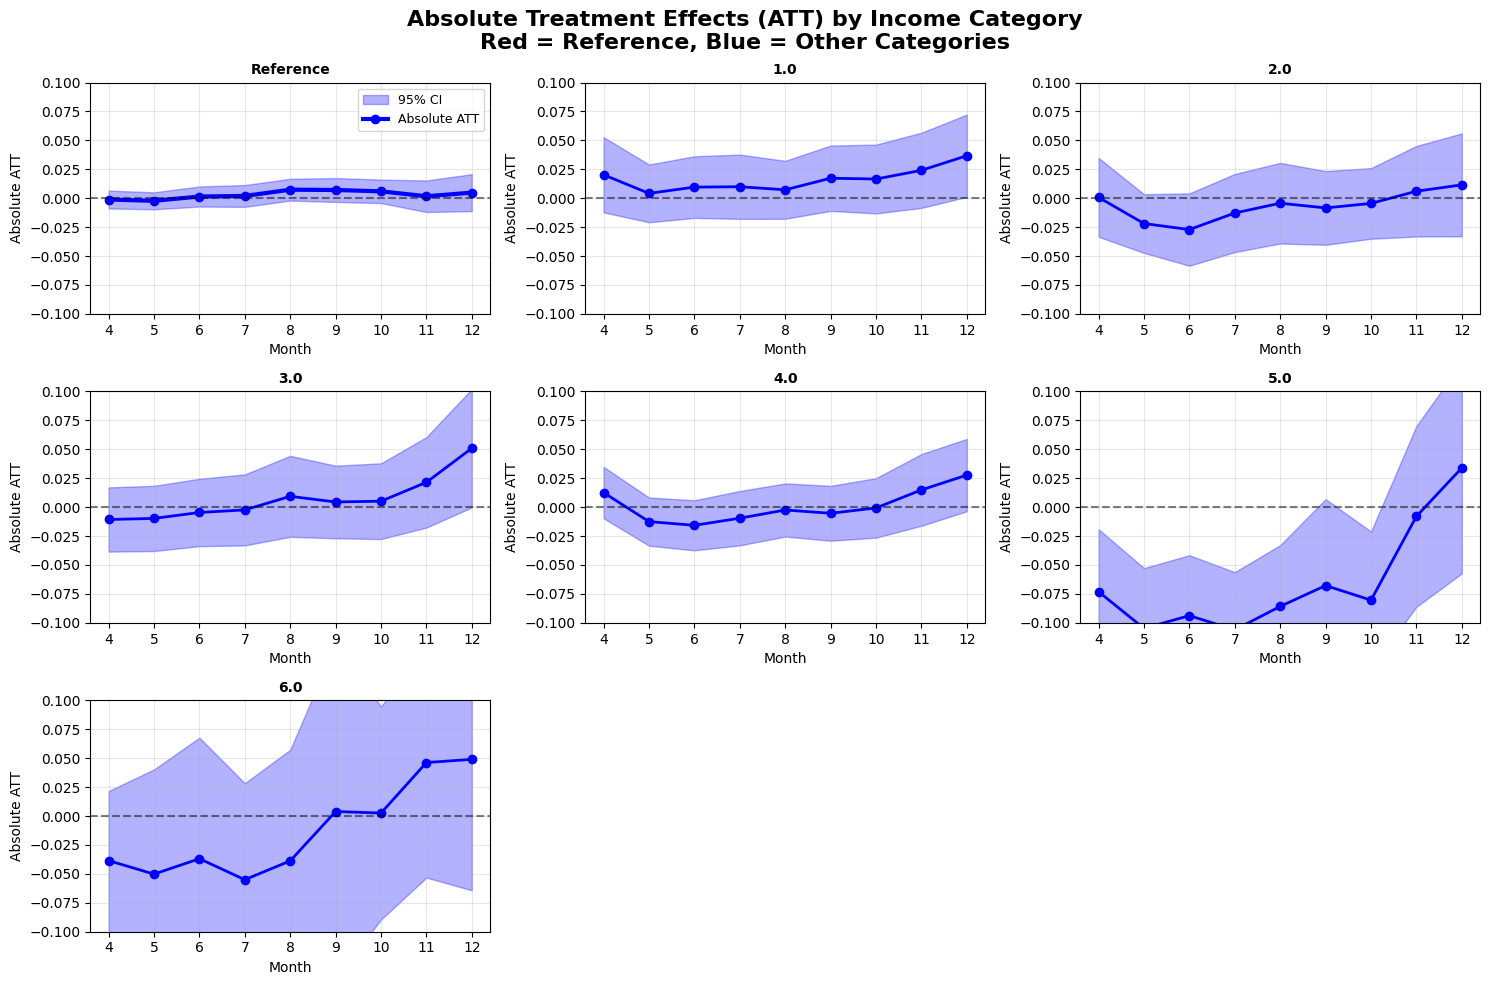


HETEROGENEITY SUMMARY:
0                  | Rel sig: 0/9 | Abs sig: 0/9
1.0                | Rel sig: 1/9 | Abs sig: 1/9
2.0                | Rel sig: 0/9 | Abs sig: 0/9
3.0                | Rel sig: 0/9 | Abs sig: 0/9
4.0                | Rel sig: 0/9 | Abs sig: 0/9
5.0                | Rel sig: 7/9 | Abs sig: 7/9
6.0                | Rel sig: 0/9 | Abs sig: 0/9

Total effects tested: 63
Significant relative effects: 8
Significant absolute effects: 8


In [ ]:
# Complete pipeline with key controls
pipeline, results, updated_df = run_enhanced_robustness_pipeline(
    df_peak_merged=df_peak_merged_masked,
    socio_df=socio_df,
    test_heterogeneity=True,
    heterogeneity_vars=['Cluster_Comp06_k07'],
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE'],
    include_socio_post_controls=False,outcome_var='out_mid_peak',
    apply_uniform_bands=True,temp_var='Daily_Temp',
)

# Then extract heterogeneity results with controls
results_HTE_df = pipeline.get_heterogeneity_results_df(
    heterogeneity_var='Cluster_Comp06_k07',
    key_controls=['INCOME_CATEGORY', 'HOUSEHOLD_SIZE', 'AGE_GROUP']
)

# Create the plots
pipeline.plot_heterogeneity_from_df(results_HTE_df, plot_type='both')

# Plots

In [ ]:
def show_or_save_plot(filename=None):
    """Helper function to handle plot display and saving based on settings"""
    if SAVE_PLOTS and filename:
        plt.savefig(os.path.join(output_dir, filename), dpi=SAVE_DPI, bbox_inches='tight')
        print(f"✓ Saved: {filename}")

    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close()  # Close the plot to free memory if not showing


SHOW_PLOTS = True  # Set to True to display plots, False to only save them
SAVE_PLOTS = False  # Set to True to save plots, False to only display them

# Optional: Set DPI for saved images
SAVE_DPI = 600

## 1. Electricity

## 1.1.1 Electricity Plot histogram on Treatment: Sunday Consumption difference

In [ ]:

# Filter for Treatment == 1 (intervention group only)
treatment_data = df_peak_merged_masked_sunday[df_peak_merged_masked_sunday['Treatment'] == 1].copy()

# Separate Pre and Post periods
pre_data = treatment_data[treatment_data['Post'] == 0]['sunday8_12']
post_data = treatment_data[treatment_data['Post'] == 1]['sunday8_12']

# Calculate means
pre_mean = pre_data.mean()
post_mean = post_data.mean()

# Create the plot
plt.figure(figsize=(12, 8))

# Plot histograms with transparency
plt.hist(pre_data, bins=80, alpha=0.7, label=f'Pre (Mean: {pre_mean:.3f} kWh)',
         color='skyblue', density=True, edgecolor='black', linewidth=0.5)
plt.hist(post_data, bins=80, alpha=0.7, label=f'Post (Mean: {post_mean:.3f} kWh)',
         color='lightcoral', density=True, edgecolor='black', linewidth=0.5)

# Add vertical lines for means
plt.axvline(pre_mean, color='blue', linestyle='--', linewidth=2,
           label=f'Pre Mean: {pre_mean:.3f} kWh')
plt.axvline(post_mean, color='red', linestyle='--', linewidth=2,
           label=f'Post Mean: {post_mean:.3f} kWh')

# Customize the plot
plt.xlabel('Average Sunday 8AM-12PM Electricity Consumption (kWh)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Sunday Morning (8AM-12PM) Electricity Consumption\nTreatment Group: Pre vs Post Intervention',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.2)

# Add statistics text box
diff = post_mean - pre_mean
pct_change = (diff / pre_mean) * 100

stats_text = f'''Statistics:
Pre Period: {len(pre_data)} observations
Post Period: {len(post_data)} observations
Mean Difference: {diff:.3f} kWh
Percentage Change: {pct_change:.1f}%'''

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("SUNDAY 8AM-12PM CONSUMPTION ANALYSIS (Treatment Group)")
print("=" * 60)
print(f"Pre Period Statistics:")
print(f"  Count: {len(pre_data)}")
print(f"  Mean: {pre_mean:.4f} kWh")
print(f"  Std: {pre_data.std():.4f} kWh")
print(f"  Min: {pre_data.min():.4f} kWh")
print(f"  Max: {pre_data.max():.4f} kWh")

print(f"\nPost Period Statistics:")
print(f"  Count: {len(post_data)}")
print(f"  Mean: {post_mean:.4f} kWh")
print(f"  Std: {post_data.std():.4f} kWh")
print(f"  Min: {post_data.min():.4f} kWh")
print(f"  Max: {post_data.max():.4f} kWh")

print(f"\nComparison:")
print(f"  Mean Difference (Post - Pre): {diff:.4f} kWh")
print(f"  Percentage Change: {pct_change:.2f}%")
print(f"  Effect Direction: {'Increase' if diff > 0 else 'Decrease'} in consumption")

## 1.1.2 Monthly Mean peak_kwh

In [ ]:
# 1. Compute monthly mean peak_kwh per household
monthly_means = (
    df_peak_merged_masked
    .groupby(['ANON_ID', 'Month'])['peak_kwh']
    .mean()
    .reset_index(name='monthly_avg_peak_kwh')
)

# 2. Plot histogram of these household-month averages
plt.figure(figsize=(10, 6))
sns.histplot(data=monthly_means, x='monthly_avg_peak_kwh', bins=40, kde=True, color='skyblue')

# Optional: limit x-axis
plt.xlim(0, 2.0)  # adjust as needed

plt.title('Histogram of Monthly Mean Peak kWh per Household')
plt.xlabel('kWh')
plt.ylabel('Number of Obs.')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(0,1)
plt.show()

# 1. Compute monthly mean peak_kwh per household
monthly_means = (
    df_peak_merged_masked
    .groupby(['ANON_ID', 'Month'])['out_mid_peak']
    .mean()
    .reset_index(name='monthly_avg_peak_kwh')
)

# 2. 12 to 16 and 19 to midnight: Plot histogram of these household-month averages
plt.figure(figsize=(10, 6))
sns.histplot(data=monthly_means, x='monthly_avg_peak_kwh', bins=40, kde=True, color='skyblue')

# Optional: limit x-axis
plt.xlim(0, 2.0)  # adjust as needed

plt.title('Histogram of Monthly Outside Peak kWh per Household')
plt.xlabel('kWh')
plt.ylabel('Number of Obs.')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(0,1)
plt.show()

# 3. SUNDAY Compute monthly mean peak_kwh per household
monthly_means_sun = (
    df_peak_merged_masked_sunday
    .groupby(['ANON_ID', 'Month'])['sunday8_12']
    .mean()
    .reset_index(name='monthly_avg_peak_kwh')
)

# 2. Plot histogram of these household-month averages
plt.figure(figsize=(10, 6))
sns.histplot(data=monthly_means_sun, x='monthly_avg_peak_kwh', bins=40, kde=True, color='skyblue')

# Optional: limit x-axis
plt.xlim(0, 2.0)  # adjust as needed

plt.title('Histogram of Sunday 8am - 12pm kWh per Household')
plt.xlabel('kWh')
plt.ylabel('Number of Obs.')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(0,1)
plt.show()

## 1.1.3 Temperature vs Peak PLOT

In [ ]:

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# Create the 2D hex plot
def create_temp_vs_peak_hexplot(df, title_suffix=""):
    """
    Create a 2D hexbin plot showing relationship between temperature and peak electricity consumption

    Parameters:
    df: DataFrame with 'Temp_avg' and 'peak_kwh' columns
    title_suffix: Additional text for the title
    """

    # Remove any missing values and filter out extreme values at 2.5% and 97.5% percentiles
    df_clean = df.dropna(subset=['Temp_avg', 'peak_kwh'])

    # Filter out extreme values (remove observations outside 2.5% - 97.5% range)
    q_low = df_clean['peak_kwh'].quantile(0.025)
    q_high = df_clean['peak_kwh'].quantile(0.975)
    df_clean = df_clean[(df_clean['peak_kwh'] >= q_low) & (df_clean['peak_kwh'] <= q_high)]

    # Create figure with subplots for different views
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Peak Electricity Usage vs Temperature{title_suffix}',
                 fontsize=20, fontweight='bold', y=0.98)

    # 1. Main hexbin plot
    ax1 = axes[0, 0]
    hb = ax1.hexbin(df_clean['peak_kwh'], df_clean['Temp_avg'],
                    gridsize=30, cmap='YlOrRd', mincnt=1, alpha=0.8)
    ax1.set_xlabel('Peak Electricity Usage (kWh)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Average Temperature (°C)', fontsize=12, fontweight='bold')
    ax1.set_title('2D Hexbin Plot - All Data', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Add colorbar
    cb1 = plt.colorbar(hb, ax=ax1)
    cb1.set_label('Density', fontsize=11)

    # 2. Hexbin plot with log scale for colors
    ax2 = axes[0, 1]
    hb2 = ax2.hexbin(df_clean['peak_kwh'], df_clean['Temp_avg'],
                     gridsize=30, cmap='plasma', mincnt=1,
                     norm=LogNorm(), alpha=0.8)
    ax2.set_xlabel('Peak Electricity Usage (kWh)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Average Temperature (°C)', fontsize=12, fontweight='bold')
    ax2.set_title('2D Hexbin Plot - Log Scale', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add colorbar
    cb2 = plt.colorbar(hb2, ax=ax2)
    cb2.set_label('Density (Log Scale)', fontsize=11)

    # 3. Scatter plot with trend line
    ax3 = axes[1, 0]

    # Sample data for scatter plot if too many points
    if len(df_clean) > 5000:
        df_sample = df_clean.sample(n=5000, random_state=42)
    else:
        df_sample = df_clean

    ax3.scatter(df_sample['peak_kwh'], df_sample['Temp_avg'],
               alpha=0.4, s=20, c='steelblue', edgecolors='none')

    # Add trend line
    z = np.polyfit(df_clean['peak_kwh'], df_clean['Temp_avg'], 1)
    p = np.poly1d(z)
    ax3.plot(df_clean['peak_kwh'].sort_values(),
             p(df_clean['peak_kwh'].sort_values()),
             "r--", alpha=0.8, linewidth=2, label=f'Trend: y = {z[0]:.3f}x + {z[1]:.3f}')

    ax3.set_xlabel('Peak Electricity Usage (kWh)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Average Temperature (°C)', fontsize=12, fontweight='bold')
    ax3.set_title('Scatter Plot with Trend Line', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # 4. Statistical summary
    ax4 = axes[1, 1]
    ax4.axis('off')

    # Calculate correlation
    correlation = df_clean['peak_kwh'].corr(df_clean['Temp_avg'])

    # Calculate peak_kwh bins for summary
    peak_bins = pd.cut(df_clean['peak_kwh'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    peak_summary = df_clean.groupby(peak_bins)['Temp_avg'].agg(['count', 'mean', 'std']).round(3)

    # Create summary text
    summary_text = f"""
    STATISTICAL SUMMARY
    {'='*30}

    Total Observations: {len(df_clean):,}

    Peak Usage Range: {df_clean['peak_kwh'].min():.3f} to {df_clean['peak_kwh'].max():.3f} kWh
    Temperature Range: {df_clean['Temp_avg'].min():.1f}°C to {df_clean['Temp_avg'].max():.1f}°C

    Peak Usage Bins Summary:
    {peak_summary.to_string()}

    Peak Hours: 4pm - 7pm (16:00 - 19:00)
    Study Period: Apr 2023 - Dec 2024
    Data filtered: removed 2.5% and 97.5% extreme values
    """

    ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))

    plt.tight_layout()
    return fig

# Create separate plots for different groups
def create_treatment_comparison_hexplot(df):
    """
    Create hexbin plots comparing treatment and control groups
    """
    df_clean = df.dropna(subset=['Temp_avg', 'peak_kwh', 'Treatment'])

    # Filter out extreme values (remove observations outside 2.5% - 97.5% range)
    q_low = df_clean['peak_kwh'].quantile(0.025)
    q_high = df_clean['peak_kwh'].quantile(0.975)
    df_clean = df_clean[(df_clean['peak_kwh'] >= q_low) & (df_clean['peak_kwh'] <= q_high)]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Peak Electricity Usage vs Temperature by Treatment Group',
                 fontsize=18, fontweight='bold', y=1.02)

    # Treatment group
    df_treatment = df_clean[df_clean['Treatment'] == 1]
    if len(df_treatment) > 0:
        hb1 = axes[0].hexbin(df_treatment['peak_kwh'], df_treatment['Temp_avg'],
                            gridsize=25, cmap='Reds', mincnt=1, alpha=0.8)
        axes[0].set_title(f'Treatment Group (n={len(df_treatment):,})', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Peak Electricity Usage (kWh)', fontsize=12)
        axes[0].set_ylabel('Average Temperature (°C)', fontsize=12)
        axes[0].grid(True, alpha=0.3)
        plt.colorbar(hb1, ax=axes[0], label='Density')

    # Control group
    df_control = df_clean[df_clean['Treatment'] == 0]
    if len(df_control) > 0:
        hb2 = axes[1].hexbin(df_control['peak_kwh'], df_control['Temp_avg'],
                            gridsize=25, cmap='Blues', mincnt=1, alpha=0.8)
        axes[1].set_title(f'Control Group (n={len(df_control):,})', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Peak Electricity Usage (kWh)', fontsize=12)
        axes[1].set_ylabel('Average Temperature (°C)', fontsize=12)
        axes[1].grid(True, alpha=0.3)
        plt.colorbar(hb2, ax=axes[1], label='Density')

    # Combined overlay
    axes[2].hexbin(df_treatment['peak_kwh'], df_treatment['Temp_avg'],
                   gridsize=25, cmap='Reds', mincnt=1, alpha=0.6, label='Treatment')
    axes[2].hexbin(df_control['peak_kwh'], df_control['Temp_avg'],
                   gridsize=25, cmap='Blues', mincnt=1, alpha=0.6, label='Control')
    axes[2].set_title('Combined View', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Peak Electricity Usage (kWh)', fontsize=12)
    axes[2].set_ylabel('Average Temperature (°C)', fontsize=12)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Create seasonal analysis
def create_seasonal_hexplot(df):
    """
    Create hexbin plots by season
    """
    df_clean = df.dropna(subset=['Temp_avg', 'peak_kwh', 'Month'])

    # Filter out extreme values (remove observations outside 2.5% - 97.5% range)
    q_low = df_clean['peak_kwh'].quantile(0.025)
    q_high = df_clean['peak_kwh'].quantile(0.975)
    df_clean = df_clean[(df_clean['peak_kwh'] >= q_low) & (df_clean['peak_kwh'] <= q_high)]

    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    df_clean['Season'] = df_clean['Month'].apply(get_season)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Peak Electricity Usage vs Temperature by Season',
                 fontsize=18, fontweight='bold', y=0.98)

    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
    colors = ['Greens', 'Oranges', 'Reds', 'Blues']

    for i, (season, cmap) in enumerate(zip(seasons, colors)):
        ax = axes[i//2, i%2]
        df_season = df_clean[df_clean['Season'] == season]

        if len(df_season) > 0:
            hb = ax.hexbin(df_season['peak_kwh'], df_season['Temp_avg'],
                          gridsize=20, cmap=cmap, mincnt=1, alpha=0.8)
            ax.set_title(f'{season} (n={len(df_season):,})', fontsize=14, fontweight='bold')
            ax.set_xlabel('Peak Electricity Usage (kWh)', fontsize=12)
            ax.set_ylabel('Average Temperature (°C)', fontsize=12)
            ax.grid(True, alpha=0.3)
            plt.colorbar(hb, ax=ax, label='Density')
        else:
            ax.text(0.5, 0.5, f'No data for {season}',
                   transform=ax.transAxes, ha='center', va='center', fontsize=14)

    plt.tight_layout()
    return fig

# Usage examples:
"""
# After running your pipeline, use these functions:

# 1. Basic hexbin plot
fig1 = create_temp_vs_peak_hexplot(df_peak_merged_masked, " - Weekday Data")
plt.show()

# 2. Treatment vs Control comparison
fig2 = create_treatment_comparison_hexplot(df_peak_merged_masked)
plt.show()

# 3. Seasonal analysis
fig3 = create_seasonal_hexplot(df_peak_merged_masked)
plt.show()

# Save plots
fig1.savefig('temp_vs_peak_hexplot.png', dpi=300, bbox_inches='tight')
fig2.savefig('treatment_comparison_hexplot.png', dpi=300, bbox_inches='tight')
fig3.savefig('seasonal_hexplot.png', dpi=300, bbox_inches='tight')
"""

# Quick single hexbin plot function
def quick_hexplot(df, x_col='peak_kwh', y_col='Temp_avg', title='Peak Electricity Usage vs Temperature'):
    """
    Quick and simple hexbin plot
    """
    plt.figure(figsize=(10, 8))

    df_clean = df.dropna(subset=[x_col, y_col])

    # Filter out extreme values if peak_kwh is being used
    if x_col == 'peak_kwh':
        q_low = df_clean[x_col].quantile(0.025)
        q_high = df_clean[x_col].quantile(0.975)
        df_clean = df_clean[(df_clean[x_col] >= q_low) & (df_clean[x_col] <= q_high)]

    plt.hexbin(df_clean[x_col], df_clean[y_col],
               gridsize=30, cmap='YlOrRd', mincnt=1, alpha=0.8)

    plt.xlabel('Peak Electricity Usage (kWh)', fontsize=12, fontweight='bold')
    plt.ylabel('Average Temperature (°C)', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.colorbar(label='Density')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    return plt.gcf()

# Example usage:
fig = quick_hexplot(df_peak_merged_masked)
plt.show()

## Socioeconomic

## 1.2.1 Extensive Socioeconomic covariate analysis

In [ ]:

def comprehensive_socio_eda(socio_df, energy_df=None, figsize_large=(20, 15), figsize_medium=(15, 10)):
    """
    Comprehensive exploratory data analysis for socioeconomic data
    Focuses on core variables and compares Control vs Intervention groups

    Parameters:
    - socio_df: DataFrame with socioeconomic variables
    - energy_df: Optional energy DataFrame to merge for correlations
    - figsize_large: Figure size for large plots
    - figsize_medium: Figure size for medium plots
    """

    # Define core columns and ordinal orders
    core_columns = ['ANON_ID', 'AGE_GROUP', 'INCOME_CATEGORY', 'HOUSEHOLD_OCCUPANCY',
                   'CHILDREN_AT_HOME', 'HOUSEHOLD_SIZE', 'NUMBER_OF_BEDROOMS',
                   'OCCUPATION', 'EMPLOYMENT_STATUS', 'HIGHEST_QUALIFICATION',
                   'HOME_OWNERSHIP', 'HOME_TYPE', 'HOME_VALUE', 'SOCIAL_GRADE',
                   'TARIFF_GROUP', 'Cluster_Comp06_k07','Group']

    feature_orders = {
        'INCOME_CATEGORY': ['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999',
                           '40,000-49,999', '50,000-74,999', '75,000-99,999', '100,000+'],
        'HOUSEHOLD_OCCUPANCY': ['Single Adult Household', 'Couple Household', 'Multi-Occupancy Household'],
        'CHILDREN_AT_HOME': ['0', '1', '2+'],
        'HOUSEHOLD_SIZE': ['1', '2', '3-4', '5+'],
        'NUMBER_OF_BEDROOMS': ['1', '2', '3', '4', '5+'],
        'HIGHEST_QUALIFICATION': ['GCSE Equivalent', 'A Level Equivalent',
                                 'Secondary Education or Less', 'University Degree or Higher'],
        'HOME_VALUE': ['0-100k', '100-150k', '150-250k', '250-500k', '500k+'],
        'SOCIAL_GRADE': ['Social grade A', 'Social grade B', 'Social grade C1',
                        'Social grade C2', 'Social grade D']
    }

    # Filter to core columns only
    available_columns = [col for col in core_columns if col in socio_df.columns]
    socio_core = socio_df[available_columns].copy()

    print("="*80)
    print("COMPREHENSIVE SOCIOECONOMIC DATA ANALYSIS")
    print("="*80)

    # Basic data overview
    print(f"\nDATASET OVERVIEW:")
    print(f"Shape: {socio_core.shape}")
    print(f"Core columns analyzed: {len(available_columns)-1}")  # -1 for ANON_ID
    print(f"Memory usage: {socio_core.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Group distribution (DiD groups)
    if 'Group' in socio_core.columns:
        group_counts = socio_core['Group'].value_counts().sort_index()
        print(f"\nTREATMENT GROUP DISTRIBUTION:")
        print(f"Control (Group=0): {group_counts.get(0, 0):,} households")
        print(f"Intervention (Group=1): {group_counts.get(1, 0):,} households")
        if len(group_counts) > 0:
            pct_intervention = group_counts.get(1, 0) / group_counts.sum() * 100
            print(f"Intervention percentage: {pct_intervention:.1f}%")

    # Data types and missing values
    analysis_columns = [col for col in available_columns if col not in ['ANON_ID', 'Group']]

    print(f"\nDATA QUALITY OVERVIEW:")
    info_df = pd.DataFrame({
        'Column': analysis_columns,
        'Data_Type': [socio_core[col].dtype for col in analysis_columns],
        'Non_Null_Count': [socio_core[col].count() for col in analysis_columns],
        'Null_Count': [socio_core[col].isnull().sum() for col in analysis_columns],
        'Null_Percentage': [(socio_core[col].isnull().sum() / len(socio_core) * 100).round(2) for col in analysis_columns],
        'Unique_Values': [socio_core[col].nunique() for col in analysis_columns]
    })
    print(info_df.to_string(index=False))

    # Identify ordinal vs nominal variables
    ordinal_vars = [col for col in analysis_columns if col in feature_orders]
    nominal_vars = [col for col in analysis_columns if col not in feature_orders]

    print(f"\nVARIABLE CLASSIFICATION:")
    print(f"Ordinal variables ({len(ordinal_vars)}): {ordinal_vars}")
    print(f"Nominal variables ({len(nominal_vars)}): {nominal_vars}")

    return (analyze_group_balance(socio_core, ordinal_vars, nominal_vars, feature_orders, figsize_large),
            analyze_variable_distributions(socio_core, ordinal_vars, nominal_vars, feature_orders, figsize_large),
            analyze_within_group_correlations(socio_core, ordinal_vars, nominal_vars, feature_orders, figsize_medium),
            analyze_energy_correlations(socio_core, energy_df, ordinal_vars, nominal_vars, feature_orders, figsize_medium) if energy_df is not None else None)

def analyze_group_balance(socio_df, ordinal_vars, nominal_vars, feature_orders, figsize=(35, 25)):
    """Analyze balance between Control and Intervention groups - crucial for DiD assumptions"""

    print("\n" + "="*60)
    print("GROUP BALANCE ANALYSIS (DiD ASSUMPTION CHECKING)")
    print("="*60)

    if 'Group' not in socio_df.columns:
        print("No 'Group' column found - cannot perform group balance analysis")
        return None

    balance_results = {}
    all_vars = ordinal_vars + nominal_vars

    # Calculate number of subplots needed
    n_vars = len(all_vars)
    n_cols = 4
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_vars == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)

    print(f"\nGROUP BALANCE TESTS:")
    print(f"{'Variable':<25} {'Test':<15} {'Statistic':<12} {'P-value':<10} {'Balanced?'}")
    print("-" * 70)

    for i, var in enumerate(all_vars):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]

        # Clean data
        clean_data = socio_df[[var, 'Group']].dropna()

        if len(clean_data) == 0:
            continue

        # Create crosstab for visualization
        if var in ordinal_vars and var in feature_orders:
            # Ordinal variable - preserve order
            categories = feature_orders[var]
            # Filter to only categories present in data
            present_categories = [cat for cat in categories if cat in clean_data[var].values]
        else:
            # Nominal variable
            present_categories = sorted(clean_data[var].unique())

        # Create balanced crosstab
        crosstab = pd.crosstab(clean_data[var], clean_data['Group'], normalize='columns')

        # Reindex to preserve order
        if var in ordinal_vars:
            crosstab = crosstab.reindex(present_categories, fill_value=0)

        # Plot
        crosstab.plot(kind='bar', ax=ax, width=0.8)
        ax.set_title(f'{var}\n', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Proportion')
        ax.legend(['Control', 'Intervention'], fontsize=8)
        ax.tick_params(axis='x', rotation=45, labelsize=8)

        # Statistical test
        contingency_table = pd.crosstab(clean_data[var], clean_data['Group'])

        try:
            if var in ordinal_vars:
                # For ordinal variables, use Mann-Whitney U test
                control_data = clean_data[clean_data['Group'] == 0][var]
                intervention_data = clean_data[clean_data['Group'] == 1][var]

                # Convert to numeric for Mann-Whitney test
                if var in feature_orders:
                    order_mapping = {cat: i for i, cat in enumerate(feature_orders[var])}
                    control_numeric = control_data.map(order_mapping).dropna()
                    intervention_numeric = intervention_data.map(order_mapping).dropna()

                    if len(control_numeric) > 0 and len(intervention_numeric) > 0:
                        statistic, p_value = mannwhitneyu(control_numeric, intervention_numeric, alternative='two-sided')
                        test_name = "Mann-Whitney U"
                    else:
                        statistic, p_value = np.nan, np.nan
                        test_name = "Mann-Whitney U"
                else:
                    statistic, p_value = np.nan, np.nan
                    test_name = "Mann-Whitney U"
            else:
                # For nominal variables, use Chi-square test
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                statistic = chi2
                test_name = "Chi-square"

            # Determine if balanced (using p > 0.05 as threshold)
            is_balanced = "Yes" if p_value > 0.05 else "No"

            balance_results[var] = {
                'test': test_name,
                'statistic': statistic,
                'p_value': p_value,
                'balanced': is_balanced,
                'contingency_table': contingency_table
            }

            print(f"{var:<25} {test_name:<15} {statistic:<12.3f} {p_value:<10.4f} {is_balanced}")

        except Exception as e:
            print(f"{var:<25} {'Error':<15} {'-':<12} {'-':<10} {'-'}")
            balance_results[var] = {
                'test': 'Error',
                'statistic': np.nan,
                'p_value': np.nan,
                'balanced': 'Unknown',
                'error': str(e)
            }

    # Hide empty subplots
    for i in range(n_vars, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        if n_rows > 1:
            axes[row, col_idx].set_visible(False)
        else:
            axes[col_idx].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Summary
    balanced_vars = [var for var, result in balance_results.items()
                    if result['balanced'] == 'Yes']
    unbalanced_vars = [var for var, result in balance_results.items()
                      if result['balanced'] == 'No']

    print(f"\nBALANCE SUMMARY:")
    print(f"Balanced variables ({len(balanced_vars)}): {balanced_vars}")
    print(f"Unbalanced variables ({len(unbalanced_vars)}): {unbalanced_vars}")

    if unbalanced_vars:
        print(f"\n⚠️  WARNING: {len(unbalanced_vars)} variables show significant imbalance between groups.")
        print(f"   This may violate DiD assumptions. Consider including these as controls.")
    else:
        print(f"\n✅ All variables are balanced between groups - good for DiD assumptions!")

    return balance_results

def analyze_variable_distributions(socio_df, ordinal_vars, nominal_vars, feature_orders, figsize=(20, 15)):
    """Analyze distributions of all variables"""

    print("\n" + "="*60)
    print("VARIABLE DISTRIBUTIONS ANALYSIS")
    print("="*60)

    all_vars = [var for var in ordinal_vars + nominal_vars if var in socio_df.columns]
    distribution_summary = {}

    # Calculate number of subplots needed
    n_vars = len(all_vars)
    n_cols = 4
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_vars == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.reshape(1, -1)

    for i, var in enumerate(all_vars):
        row = i // n_cols
        col_idx = i % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]

        # Get value counts
        value_counts = socio_df[var].value_counts()

        # Apply ordering if ordinal
        if var in ordinal_vars and var in feature_orders:
            # Preserve order for ordinal variables
            ordered_counts = pd.Series(index=feature_orders[var], dtype=int).fillna(0)
            for cat in value_counts.index:
                if cat in ordered_counts.index:
                    ordered_counts[cat] = value_counts[cat]
            # Remove categories with 0 counts
            ordered_counts = ordered_counts[ordered_counts > 0]
            value_counts = ordered_counts

        # Store summary
        distribution_summary[var] = {
            'unique_values': len(value_counts),
            'most_common': value_counts.index[0],
            'most_common_count': value_counts.iloc[0],
            'most_common_pct': (value_counts.iloc[0] / len(socio_df) * 100),
            'value_counts': value_counts.to_dict(),
            'variable_type': 'ordinal' if var in ordinal_vars else 'nominal'
        }

        # Plot
        if len(value_counts) <= 15:
            # Bar plot for manageable number of categories
            value_counts.plot(kind='bar', ax=ax, rot=45, color='skyblue', edgecolor='black')
            ax.set_title(f'{var}\n({len(value_counts)} categories)', fontsize=10)
            ax.set_ylabel('Count')

            # Add percentage labels
            total = value_counts.sum()
            for j, v in enumerate(value_counts.values):
                ax.text(j, v + total*0.01, f'{v/total:.1%}',
                       ha='center', va='bottom', fontsize=8)
        else:
            # Show only top 10 for too many categories
            top_10 = value_counts.head(10)
            others_count = value_counts.iloc[10:].sum() if len(value_counts) > 10 else 0

            if others_count > 0:
                top_10_with_others = pd.concat([top_10, pd.Series({'Others': others_count})])
            else:
                top_10_with_others = top_10

            top_10_with_others.plot(kind='bar', ax=ax, rot=45, color='lightcoral', edgecolor='black')
            ax.set_title(f'{var}\n({len(value_counts)} total, showing top 10)', fontsize=10)
            ax.set_ylabel('Count')

        # Print detailed summary
        var_type = "ORDINAL" if var in ordinal_vars else "NOMINAL"
        print(f"\n{var} ({var_type}):")
        print(f"  Unique values: {len(value_counts)}")
        print(f"  Most common: '{value_counts.index[0]}' ({value_counts.iloc[0]:,} obs, {value_counts.iloc[0]/len(socio_df)*100:.1f}%)")
        if len(value_counts) <= 20:
            print(f"  All categories:")
            for idx, (cat, count) in enumerate(value_counts.items()):
                print(f"    {cat}: {count:,} ({count/len(socio_df)*100:.1f}%)")
        else:
            print(f"  Top 3 categories:")
            for idx, (cat, count) in enumerate(value_counts.head(3).items()):
                print(f"    {idx+1}. {cat}: {count:,} ({count/len(socio_df)*100:.1f}%)")

    # Hide empty subplots
    for i in range(n_vars, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        if n_rows > 1:
            axes[row, col_idx].set_visible(False)
        else:
            axes[col_idx].set_visible(False)

    plt.tight_layout()
    plt.show()

    return distribution_summary

def analyze_within_group_correlations(socio_df, ordinal_vars, nominal_vars, feature_orders, figsize=(15, 10)):
    """Analyze correlations between socioeconomic variables"""

    print("\n" + "="*60)
    print("WITHIN-GROUP CORRELATION ANALYSIS")
    print("="*60)

    correlations = {}

    # 1. Ordinal-Ordinal correlations (Spearman)
    if len(ordinal_vars) > 1:
        print(f"\nORDINAL-ORDINAL CORRELATIONS (Spearman):")

        # Convert ordinal variables to numeric
        ordinal_numeric = socio_df[ordinal_vars].copy()
        for var in ordinal_vars:
            if var in feature_orders:
                order_mapping = {cat: i for i, cat in enumerate(feature_orders[var])}
                ordinal_numeric[var] = socio_df[var].map(order_mapping)

        # Calculate correlations
        ordinal_corr = ordinal_numeric.corr(method='spearman')
        print(ordinal_corr.round(3))

        # Plot correlation heatmap
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(ordinal_corr, dtype=bool))
        sns.heatmap(ordinal_corr, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, fmt='.3f')
        plt.title('Ordinal Variables Correlation Matrix (Spearman)')
        plt.tight_layout()
        plt.show()

        correlations['ordinal'] = ordinal_corr

    # 2. Nominal-Nominal associations (Cramér's V)
    if len(nominal_vars) > 1:
        print(f"\nNOMINAL-NOMINAL ASSOCIATIONS (Cramér's V):")
        nominal_associations = pd.DataFrame(index=nominal_vars, columns=nominal_vars)

        for i, var1 in enumerate(nominal_vars):
            for j, var2 in enumerate(nominal_vars):
                if i <= j:
                    if i == j:
                        nominal_associations.loc[var1, var2] = 1.0
                    else:
                        try:
                            # Create contingency table
                            contingency = pd.crosstab(socio_df[var1], socio_df[var2])
                            chi2, p_val, dof, expected = chi2_contingency(contingency)

                            # Calculate Cramér's V
                            n = contingency.sum().sum()
                            cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
                            nominal_associations.loc[var1, var2] = cramers_v
                            nominal_associations.loc[var2, var1] = cramers_v

                            if cramers_v > 0.3:  # Strong association
                                print(f"  {var1} vs {var2}: Cramér's V = {cramers_v:.3f} (Strong)")
                        except:
                            nominal_associations.loc[var1, var2] = np.nan
                            nominal_associations.loc[var2, var1] = np.nan

        # Plot nominal associations
        plt.figure(figsize=(10, 8))
        sns.heatmap(nominal_associations.astype(float), annot=True, cmap='viridis',
                   square=True, linewidths=0.5, vmin=0, vmax=1, fmt='.3f')
        plt.title('Nominal Variables Association Matrix (Cramér\'s V)')
        plt.tight_layout()
        plt.show()

        correlations['nominal'] = nominal_associations

    # 3. Mixed correlations (Ordinal-Nominal)
    if len(ordinal_vars) > 0 and len(nominal_vars) > 0:
        print(f"\nORDINAL-NOMINAL ASSOCIATIONS (η²):")

        mixed_results = []
        for ordinal_var in ordinal_vars:
            for nominal_var in nominal_vars:
                try:
                    # Convert ordinal to numeric
                    if ordinal_var in feature_orders:
                        order_mapping = {cat: i for i, cat in enumerate(feature_orders[ordinal_var])}
                        ordinal_numeric = socio_df[ordinal_var].map(order_mapping).dropna()

                        # Get corresponding nominal values
                        valid_indices = ordinal_numeric.index
                        nominal_values = socio_df.loc[valid_indices, nominal_var].dropna()
                        ordinal_values = ordinal_numeric.loc[nominal_values.index]

                        # ANOVA test
                        groups = [ordinal_values[nominal_values == cat]
                                 for cat in nominal_values.unique()]
                        groups = [g for g in groups if len(g) > 0]

                        if len(groups) > 1:
                            f_stat, p_val = stats.f_oneway(*groups)
                            eta_squared = f_stat / (f_stat + len(ordinal_values) - len(groups))

                            mixed_results.append({
                                'Ordinal': ordinal_var,
                                'Nominal': nominal_var,
                                'F_statistic': f_stat,
                                'p_value': p_val,
                                'eta_squared': eta_squared
                            })

                            if eta_squared > 0.1:  # Medium effect
                                print(f"  {ordinal_var} vs {nominal_var}: η² = {eta_squared:.3f}, p = {p_val:.3f}")
                except:
                    continue

        if mixed_results:
            mixed_df = pd.DataFrame(mixed_results)
            correlations['mixed'] = mixed_df

    return correlations

def analyze_energy_correlations(socio_df, energy_df, ordinal_vars, nominal_vars, feature_orders, figsize=(15, 10)):
    """Analyze correlations between socioeconomic and energy variables"""

    print("\n" + "="*60)
    print("SOCIOECONOMIC-ENERGY CORRELATIONS")
    print("="*60)

    # Merge datasets
    merged_df = energy_df.merge(socio_df, on='ANON_ID', how='inner')
    print(f"Merged dataset shape: {merged_df.shape}")

    # Energy variables to analyze
    energy_vars = ['peak_kwh']
    if 'Temp_avg' in merged_df.columns:
        energy_vars.append('Temp_avg')

    print(f"Energy variables for correlation: {energy_vars}")

    energy_correlations = {}

    # 1. Ordinal socio vs Energy correlations (Spearman)
    if ordinal_vars and energy_vars:
        print(f"\nORDINAL SOCIO-ENERGY CORRELATIONS (Spearman):")

        corr_results = []
        for socio_var in ordinal_vars:
            if socio_var in merged_df.columns and socio_var in feature_orders:
                # Convert ordinal to numeric
                order_mapping = {cat: i for i, cat in enumerate(feature_orders[socio_var])}
                socio_numeric = merged_df[socio_var].map(order_mapping)

                for energy_var in energy_vars:
                    if energy_var in merged_df.columns:
                        # Remove missing values
                        clean_data = pd.DataFrame({
                            'socio': socio_numeric,
                            'energy': merged_df[energy_var]
                        }).dropna()

                        if len(clean_data) > 10:
                            # Spearman correlation (rank-based, appropriate for ordinal)
                            spearman_r, spearman_p = spearmanr(clean_data['socio'], clean_data['energy'])

                            corr_results.append({
                                'Socio_Variable': socio_var,
                                'Energy_Variable': energy_var,
                                'Spearman_r': spearman_r,
                                'Spearman_p': spearman_p,
                                'N': len(clean_data)
                            })

                            if abs(spearman_r) > 0.1 or spearman_p < 0.05:
                                print(f"  {socio_var} vs {energy_var}: ρ = {spearman_r:.3f} (p = {spearman_p:.3f})")

        if corr_results:
            energy_correlations['ordinal'] = pd.DataFrame(corr_results)

    # 2. Nominal socio vs Energy (ANOVA)
    if nominal_vars and energy_vars:
        print(f"\nNOMINAL SOCIO-ENERGY ASSOCIATIONS (ANOVA):")

        nominal_results = []
        for socio_var in nominal_vars:
            for energy_var in energy_vars:
                if socio_var in merged_df.columns and energy_var in merged_df.columns:
                    try:
                        # Group by nominal variable and test differences in energy variable
                        groups = [merged_df[merged_df[socio_var] == cat][energy_var].dropna()
                                 for cat in merged_df[socio_var].unique() if not pd.isna(cat)]
                        groups = [g for g in groups if len(g) > 0]

                        if len(groups) > 1:
                            f_stat, p_val = stats.f_oneway(*groups)
                            eta_squared = f_stat / (f_stat + len(merged_df) - len(groups))

                            nominal_results.append({
                                'Socio_Variable': socio_var,
                                'Energy_Variable': energy_var,
                                'F_statistic': f_stat,
                                'p_value': p_val,
                                'eta_squared': eta_squared
                            })

                            if eta_squared > 0.01 or p_val < 0.05:
                                print(f"  {socio_var} vs {energy_var}: η² = {eta_squared:.3f} (p = {p_val:.3f})")
                    except:
                        continue

        if nominal_results:
            energy_correlations['nominal'] = pd.DataFrame(nominal_results)

    # 3. Create visualization for strongest correlations
    if 'ordinal' in energy_correlations:
        strong_corrs = energy_correlations['ordinal'][
            (abs(energy_correlations['ordinal']['Spearman_r']) > 0.1) |
            (energy_correlations['ordinal']['Spearman_p'] < 0.05)
        ]

        if not strong_corrs.empty:
            plt.figure(figsize=figsize)

            # Create box plots for strongest correlations
            n_plots = min(6, len(strong_corrs))
            n_cols = 3
            n_rows = (n_plots + n_cols - 1) // n_cols

            for i in range(n_plots):
                plt.subplot(n_rows, n_cols, i+1)

                row = strong_corrs.iloc[i]
                socio_var = row['Socio_Variable']
                energy_var = row['Energy_Variable']
                r_val = row['Spearman_r']
                p_val = row['Spearman_p']

                # Create box plot
                plot_data = merged_df[[socio_var, energy_var]].dropna()

                # Order categories if ordinal
                if socio_var in feature_orders:
                    category_order = [cat for cat in feature_orders[socio_var]
                                    if cat in plot_data[socio_var].values]
                else:
                    category_order = None

                sns.boxplot(data=plot_data, x=socio_var, y=energy_var, order=category_order)
                plt.xlabel(socio_var)
                plt.ylabel(energy_var)
                plt.title(f'ρ = {r_val:.3f} (p = {p_val:.3f})')
                plt.xticks(rotation=45)
                plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    return energy_correlations

# Main function to run complete EDA
def run_complete_socio_eda(socio_df, energy_df=None):
    """
    Run complete socioeconomic EDA focused on core variables and DiD assumptions

    Usage:
    balance_results, distributions, correlations, energy_corrs = run_complete_socio_eda(socio_df, df_peak_merged)
    """

    results = comprehensive_socio_eda(socio_df, energy_df)

    return results

# Function to get recommendations for DiD controls based on balance analysis
def recommend_did_controls_from_balance(balance_results, max_controls=5):
    """
    Recommend DiD controls based on group balance analysis

    Parameters:
    - balance_results: Results from analyze_group_balance()
    - max_controls: Maximum number of controls to recommend

    Returns:
    - Dictionary with recommendations
    """

    print("="*60)
    print("DiD CONTROL RECOMMENDATIONS BASED ON BALANCE ANALYSIS")
    print("="*60)

    if not balance_results:
        print("No balance results available")
        return None

    recommendations = {
        'must_include': [],      # Unbalanced variables (p < 0.05)
        'should_include': [],    # Marginally balanced (0.05 ≤ p < 0.1)
        'optional': [],          # Well balanced (p ≥ 0.1)
        'final_recommendation': []
    }

    for var, result in balance_results.items():
        if result.get('p_value') is None or np.isnan(result.get('p_value', np.nan)):
            continue

        p_val = result['p_value']

        if p_val < 0.05:
            recommendations['must_include'].append((var, f"Unbalanced (p = {p_val:.3f})"))
        elif p_val < 0.1:
            recommendations['should_include'].append((var, f"Marginally balanced (p = {p_val:.3f})"))
        else:
            recommendations['optional'].append((var, f"Well balanced (p = {p_val:.3f})"))

    # Print recommendations
    print(f"\nMUST INCLUDE (Unbalanced - Required for valid DiD):")
    for var, reason in recommendations['must_include']:
        print(f"  🔴 {var}: {reason}")

    print(f"\nSHOULD INCLUDE (Marginally balanced):")
    for var, reason in recommendations['should_include']:
        print(f"  🟡 {var}: {reason}")

    print(f"\nOPTIONAL (Well balanced):")
    for var, reason in recommendations['optional']:
        print(f"  🟢 {var}: {reason}")

    # Create final recommendation
    must_vars = [var for var, _ in recommendations['must_include']]
    should_vars = [var for var, _ in recommendations['should_include']]
    optional_vars = [var for var, _ in recommendations['optional']]

    # Prioritize: must include all unbalanced, then marginally balanced, then optional
    final_controls = must_vars + should_vars
    remaining_slots = max_controls - len(final_controls)
    if remaining_slots > 0:
        final_controls.extend(optional_vars[:remaining_slots])
    else:
        final_controls = final_controls[:max_controls]

    recommendations['final_recommendation'] = final_controls

    print(f"\nFINAL RECOMMENDATION (Top {min(max_controls, len(final_controls))}):")
    for i, control in enumerate(final_controls, 1):
        priority = "🔴" if control in must_vars else "🟡" if control in should_vars else "🟢"
        print(f"  {i}. {priority} {control}")

    if len(recommendations['must_include']) > 0:
        print(f"\n⚠️  WARNING: {len(recommendations['must_include'])} variables are significantly unbalanced.")
        print(f"   Including these as controls is crucial for valid DiD estimation.")

    return recommendations

# 1. Complete EDA with focus on DiD assumptions
balance_results, distributions, correlations, energy_corrs = run_complete_socio_eda(socio_df, df_peak_merged)

# 2. Get control recommendations based on balance analysis
recommendations = recommend_did_controls_from_balance(balance_results, max_controls=5)